## Step 1: Setup


In [12]:
!nvidia-smi

Tue Nov  4 11:06:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.83                 Driver Version: 576.83         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0 Off |                  N/A |
| 36%   35C    P8             15W /  170W |    1610MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
# === CONFIGURATION (12GB GPU OPTIMIZED) ===

# API Keys (set if available, else will use Ollama)
GEMINI_API_KEY = None  # Set to your API key or leave None for Ollama

# Data paths
DATA_DIR = "data"
MSMARCO_DIR = f"{DATA_DIR}/msmarco"
TYDI_DIR = f"{DATA_DIR}/tydi"
MMARCO_DIR = f"{DATA_DIR}/mmarco"

# Model directories
MODEL_DIR = "./models"
BASE_MODEL = "bert-base-multilingual-cased"

# Training configuration for 12GB GPU
USE_MIXED_PRECISION = True   
GRADIENT_ACCUMULATION_STEPS = 2  
MAX_SEQ_LENGTH = 384         
TRAIN_BATCH_SIZE = 8    

# Sample sizes for development 
DEV_MODE = True             
DEV_SAMPLE_SIZE = 1000 if DEV_MODE else None 

# Languages for multilingual training
TYDI_LANGUAGES = [
        "swahili",
        "bengali",
        "telugu",
        "thai",
        "arabic",
        "finnish",
        "indonesian",
        "japanese",
        "korean"
]
# , "indonesian", "japanese",
#     "korean", "russian", "swahili", "telugu", "thai"

MMARCO_LANGUAGES = [
    "arabic", "chinese", "dutch", "french", "german",
    "hindi", "indonesian", "italian", "japanese", "portuguese",
    "russian", "spanish", "vietnamese"
]

print("✓ Configuration loaded for 12GB GPU")
print(f"  Batch size: {TRAIN_BATCH_SIZE}, Max seq: {MAX_SEQ_LENGTH}")
print(f"  Gradient accumulation: {GRADIENT_ACCUMULATION_STEPS}")
print(f"  Development Mode: {DEV_MODE} ({DEV_SAMPLE_SIZE if DEV_MODE else 'FULL'})")


✓ Configuration loaded for 12GB GPU
  Batch size: 8, Max seq: 384
  Gradient accumulation: 2
  Development Mode: True (1000)


In [14]:
# Run once to install required packages

import subprocess
import sys

def install_packages():
    packages = [
        "transformers",
        "datasets",
        "pandas",
        "tqdm",
        "simpletransformers",
        "faiss-cpu",  # Use faiss-cpu for 4GB GPU, or faiss-gpu if sufficient
        "rank-bm25",
        "sentence-transformers",
        "torch",
    ]
    
    for package in packages:
        try:
            __import__(package.replace('-', '_'))
            print(f"✓ {package} already installed")
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_packages()

# For Ollama (if not using Gemini API)
# Install separately: https://ollama.ai/download
# Then: ollama pull llama3.2:3b
print("\n✓ All dependencies installed")

✓ transformers already installed
✓ datasets already installed
✓ pandas already installed
✓ tqdm already installed
✓ simpletransformers already installed
Installing faiss-cpu...
✓ rank-bm25 already installed
✓ sentence-transformers already installed
✓ torch already installed

✓ All dependencies installed


In [15]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
from typing import List, Dict, Tuple
from dataclasses import dataclass

import torch

from datasets import load_dataset
from transformers import set_seed

# Set seeds for reproducibility
set_seed(42)
np.random.seed(42)
random.seed(42)

# Create directories
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs("./results", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

print("✓ Libraries imported")
print(f"  PyTorch version: {torch.__version__}")
print(f"  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ Libraries imported
  PyTorch version: 2.5.1
  CUDA available: True
  GPU Memory: 12.88 GB


In [16]:
import pandas as pd

print("=== Loading MS MARCO Training Data ===")

# Load training data
msmarco_train = pd.read_csv(
    f"{MSMARCO_DIR}/msmarco-train.tsv",
    sep="\t",
    nrows=DEV_SAMPLE_SIZE if DEV_MODE else None
)

# CRITICAL: Rename columns to match BEIR format requirements
msmarco_train = msmarco_train.rename(columns={
    "query": "query_text",
    "positive_passage": "gold_passage",
    "negative_passage": "hard_negative"
})

print(f"✓ MS MARCO Train: {len(msmarco_train):,} samples")
print("Columns:", msmarco_train.columns.tolist())
print("\nSample:")
print(msmarco_train.head(2))

# Statistics
print("\nStatistics:")
print(f"  Avg query length: {msmarco_train['query_text'].str.len().mean():.1f} chars")
print(f"  Avg passage length: {msmarco_train['gold_passage'].str.len().mean():.1f} chars")


=== Loading MS MARCO Training Data ===
✓ MS MARCO Train: 1,000 samples
Columns: ['query_text', 'gold_passage', 'hard_negative']

Sample:
                                          query_text  \
0                         what are the liberal arts?   
1  what is the mechanism of action of fibrinolyti...   

                                        gold_passage  \
0  liberal arts. 1. the academic course of instru...   
1  BailliÃ¨re's Clinical Haematology. 6 Mechanism...   

                                       hard_negative  
0  Liberal Education: An approach to college lear...  
1  Be able to diagram the coagulation and fibrino...  

Statistics:
  Avg query length: 33.3 chars
  Avg passage length: 345.9 chars


In [17]:
import os
import pandas as pd
from tqdm.auto import tqdm

print("\n=== Loading Mr. TyDi (BEIR Format) ===")

tydi_data = []

for lang in TYDI_LANGUAGES:
    base_dir = f"{TYDI_DIR}/{lang}"
    queries_file = os.path.join(base_dir, "queries.jsonl")
    corpus_file = os.path.join(base_dir, "corpus.jsonl")
    qrels_file = os.path.join(base_dir, "qrels/test.tsv")

    # Check required files
    if (os.path.exists(queries_file) and 
        os.path.exists(corpus_file) and 
        os.path.exists(qrels_file)):
        
        queries_df = pd.read_json(queries_file, lines=True)
        corpus_df = pd.read_json(corpus_file, lines=True)
        qrels_df = pd.read_csv(qrels_file, sep='\t')

        # Merge queries and corpus with qrels
        merged = qrels_df.merge(
            queries_df.rename(columns={"_id": "query-id"}),
            on="query-id"
        ).merge(
            corpus_df.rename(columns={"_id": "corpus-id", "text": "gold_passage"}),  # Changed here
            on="corpus-id"
        )

        # CRITICAL: Rename to BEIR format columns
        df = merged[['text', 'gold_passage']].rename(columns={'text': 'query_text'})  # Changed here
        df = df.dropna()

        # Sample if dev mode
        if DEV_SAMPLE_SIZE:
            df = df.sample(min(len(df), 200), random_state=42)
        
        tydi_data.append(df)
        print(f"  ✓ {lang}: {len(df):,}")
    else:
        print(f"  ⚠ Missing files for {lang}")

# Combine all languages
tydi_combined = pd.concat(tydi_data, ignore_index=True) if tydi_data else pd.DataFrame(columns=["query_text", "gold_passage"])

print(f"\n✓ Total Mr. TyDi: {len(tydi_combined):,} samples")
print("Columns:", tydi_combined.columns.tolist())
print("\nSample:")
print(tydi_combined.head(2))



=== Loading Mr. TyDi (BEIR Format) ===
  ✓ swahili: 200
  ✓ bengali: 111
  ✓ telugu: 200
  ✓ thai: 200
  ✓ arabic: 200
  ✓ finnish: 200
  ✓ indonesian: 200
  ✓ japanese: 200
  ✓ korean: 200

✓ Total Mr. TyDi: 1,711 samples
Columns: ['query_text', 'gold_passage']

Sample:
                                          query_text  \
0                 Remmy Ongala alifariki mwaka gani?   
1  Je, Doris May Lessing alishinda tuzo la nini k...   

                                        gold_passage  
0  Remmy Ongala (10 Februari 1947 - 12 Desemba 20...  
1  Doris May Lessing (amezaliwa 22 Oktoba 1919) a...  


In [18]:
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Remove nulls, duplicates, and invalid samples"""
    initial_size = len(df)
    
    # Remove nulls
    df = df.dropna()
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Remove empty strings
    df = df[
        (df['query_text'].str.strip() != '') & 
        (df['gold_passage'].str.strip() != '')
    ]
    
    # Length constraints (for 12GB GPU)
    df = df[
        (df['query_text'].str.len() >= 10) &
        (df['query_text'].str.len() <= 512) &
        (df['gold_passage'].str.len() >= 20) &
        (df['gold_passage'].str.len() <= 2048)
    ]
    
    # Remove if negative == positive
    if 'hard_negative' in df.columns:
        df = df[df['hard_negative'] != df['gold_passage']]
    
    print(f"  Cleaned: {initial_size:,} → {len(df):,} ({len(df)/initial_size*100:.1f}% retained)")
    
    return df.reset_index(drop=True)

print("=== Cleaning Datasets ===")

print("MS MARCO Train:")
msmarco_train = clean_dataset(msmarco_train)

print("\nMr. TyDi:")
tydi_combined = clean_dataset(tydi_combined)

print("\n✓ Cleaning complete")
print(f"\nFinal counts:")
print(f"  MS MARCO: {len(msmarco_train):,}")
print(f"  Mr. TyDi: {len(tydi_combined):,}")


=== Cleaning Datasets ===
MS MARCO Train:
  Cleaned: 1,000 → 1,000 (100.0% retained)

Mr. TyDi:
  Cleaned: 1,711 → 1,688 (98.7% retained)

✓ Cleaning complete

Final counts:
  MS MARCO: 1,000
  Mr. TyDi: 1,688


In [19]:
# Prepare data in format needed for DPR training

@dataclass
class TrainingExample:
    query: str
    positive: str
    negatives: List[str]  # Will be populated by sampling methods

def prepare_training_data(df: pd.DataFrame, has_negatives: bool = True) -> List[TrainingExample]:
    """Convert DataFrame to training examples"""
    examples = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preparing"):
        example = TrainingExample(
            query=row['query_text'],
            positive=row['gold_passage'],
            negatives=[row['negative_passage']] if has_negatives and 'negative_passage' in row else []
        )
        examples.append(example)
    
    return examples

print("=== Preparing Training Examples ===")

msmarco_train_examples = prepare_training_data(msmarco_train, has_negatives=True)
tydi_train_examples = prepare_training_data(tydi_combined, has_negatives=False)

print(f"✓ MS MARCO: {len(msmarco_train_examples):,} examples")
print(f"✓ TyDi: {len(tydi_train_examples):,} examples")

# Save to disk for later use
import pickle

with open('./data/data_processed.pkl', 'wb') as f:
    pickle.dump({
        'msmarco_train': msmarco_train_examples,
        'tydi_train': tydi_train_examples
    }, f)

print("\n✓ Data saved to ./data/data_processed.pkl")

=== Preparing Training Examples ===


Preparing: 100%|██████████| 1688/1688 [00:00<00:00, 36695.46it/s]

✓ MS MARCO: 1,000 examples
✓ TyDi: 1,688 examples



✓ Data saved to ./data/data_processed.pkl


In [20]:
# Final statistics

print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)

print("\n📊 MS MARCO (English):")
print(f"  Training samples: {len(msmarco_train_examples):,}")
print(f"  Has pre-mined negatives: Yes")

print("\n📊 Mr. TyDi (Multilingual):")
print(f"  Total samples: {len(tydi_train_examples):,}")
print(f"  Languages: {len(TYDI_LANGUAGES)}")
print(f"  Has pre-mined negatives: No (will generate)")

print("\n📊 Configuration:")
print(f"  Max sequence length: {MAX_SEQ_LENGTH}")
print(f"  Mixed precision: {USE_MIXED_PRECISION}")
print(f"  Gradient accumulation: {GRADIENT_ACCUMULATION_STEPS}")

print("\n✅ Phase 1 Complete: Data Preparation")
print("=" * 60)

DATASET SUMMARY

📊 MS MARCO (English):
  Training samples: 1,000
  Has pre-mined negatives: Yes

📊 Mr. TyDi (Multilingual):
  Total samples: 1,688
  Languages: 9
  Has pre-mined negatives: No (will generate)

📊 Configuration:
  Max sequence length: 384
  Mixed precision: True
  Gradient accumulation: 2

✅ Phase 1 Complete: Data Preparation


## Phase 2

In [21]:
# Install BM25 for negative sampling
import subprocess
import sys

try:
    from rank_bm25 import BM25Okapi
    print("✓ rank_bm25 already installed")
except ImportError:
    print("Installing rank_bm25...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rank-bm25"])
    from rank_bm25 import BM25Okapi
    print("✓ rank_bm25 installed")

# Load processed data
import pickle

with open('./data/data_processed.pkl', 'rb') as f:
    data = pickle.load(f)
    msmarco_train_examples = data['msmarco_train']
    tydi_train_examples = data['tydi_train']

print(f"✓ Loaded {len(msmarco_train_examples):,} MS MARCO examples")
print(f"✓ Loaded {len(tydi_train_examples):,} TyDi examples")

✓ rank_bm25 already installed
✓ Loaded 1,000 MS MARCO examples
✓ Loaded 1,688 TyDi examples


In [22]:
# BM25-based hard negative mining

from rank_bm25 import BM25Okapi
from typing import List
import numpy as np

class BM25NegativeSampler:
    """Mine hard negatives using BM25"""
    
    def __init__(self, corpus: List[str]):
        print("Building BM25 index...")
        # Tokenize corpus
        tokenized_corpus = [doc.lower().split() for doc in corpus]
        self.bm25 = BM25Okapi(tokenized_corpus)
        self.corpus = corpus
        print(f"✓ BM25 index built with {len(corpus):,} documents")
    
    def get_hard_negatives(self, query: str, positive_passage: str, top_k: int = 100, n_negatives: int = 1) -> List[str]:
        """Get hard negatives for a query"""
        # Tokenize query
        tokenized_query = query.lower().split()
        
        # Get top-k candidates from BM25
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        # Filter out positive passage and select negatives
        negatives = []
        for idx in top_indices:
            candidate = self.corpus[idx]
            # Skip if it's the positive passage
            if candidate != positive_passage and candidate not in negatives:
                negatives.append(candidate)
            if len(negatives) >= n_negatives:
                break
        
        # If not enough negatives, add random ones
        while len(negatives) < n_negatives:
            random_idx = np.random.randint(0, len(self.corpus))
            candidate = self.corpus[random_idx]
            if candidate != positive_passage and candidate not in negatives:
                negatives.append(candidate)
        
        return negatives[:n_negatives]

# Build corpus from MS MARCO
print("\n=== Building BM25 Corpus ===")
all_passages = set()

for example in tqdm(msmarco_train_examples, desc="Collecting passages"):
    all_passages.add(example.positive)
    all_passages.update(example.negatives)

corpus_list = list(all_passages)
print(f"✓ Corpus size: {len(corpus_list):,} unique passages")

# Initialize BM25 sampler
bm25_sampler = BM25NegativeSampler(corpus_list)


=== Building BM25 Corpus ===


✓ Corpus size: 1,000 unique passages
Building BM25 index...
✓ BM25 index built with 1,000 documents


In [23]:
print("\n=== Mining Hard Negatives with BM25 ===")

from tqdm.auto import tqdm

# Mine for TyDi TRAINING data (all samples)
print(f"\nMining for TyDi training examples...")
for example in tqdm(tydi_train_examples, desc="TyDi"):
    if len(example.negatives) == 0:
        hard_negs = bm25_sampler.get_hard_negatives(
            example.query, 
            example.positive, 
            top_k=100, 
            n_negatives=1
        )
        example.negatives = hard_negs

# Mine for MS MARCO TRAINING data (all samples)
print(f"\nMining for MS MARCO training examples...")
for example in tqdm(msmarco_train_examples, desc="MS MARCO"):
    bm25_negs = bm25_sampler.get_hard_negatives(
        example.query,
        example.positive,
        top_k=100,
        n_negatives=1
    )
    for neg in bm25_negs:
        if neg not in example.negatives:
            example.negatives.append(neg)

print("\nHard negative mining complete")



=== Mining Hard Negatives with BM25 ===

Mining for TyDi training examples...


TyDi: 100%|██████████| 1688/1688 [00:00<00:00, 1708.73it/s]



Mining for MS MARCO training examples...


MS MARCO: 100%|██████████| 1000/1000 [00:00<00:00, 1171.88it/s]


Hard negative mining complete


In [24]:
def convert_to_training_format(examples: List, limit: int = None) -> pd.DataFrame:
    """Convert training examples to DataFrame for SimpleDPR"""
    data = []
    
    for example in (examples[:limit] if limit else examples):
        for negative in example.negatives:
            data.append({
                "query_text": example.query,
                "gold_passage": example.positive,
                "hard_negative": negative
            })
    
    return pd.DataFrame(data)

print("Preparing Training DataFrames")

train_size = 5000 if DEV_MODE else None
msmarco_train_df = convert_to_training_format(msmarco_train_examples, limit=train_size)

print(f"✓ MS MARCO training: {len(msmarco_train_df):,} triplets")
print("Columns:", msmarco_train_df.columns.tolist())
print("\nSample:")
print(msmarco_train_df.head(2))


Preparing Training DataFrames
✓ MS MARCO training: 1,000 triplets
Columns: ['query_text', 'gold_passage', 'hard_negative']

Sample:
                                          query_text  \
0                         what are the liberal arts?   
1  what is the mechanism of action of fibrinolyti...   

                                        gold_passage  \
0  liberal arts. 1. the academic course of instru...   
1  BailliÃ¨re's Clinical Haematology. 6 Mechanism...   

                                       hard_negative  
0  What Are Hormones, And What Do They Do? Hormon...  
1  Here is the video of claw mechanism animation....  


In [25]:
# Prepare Mr. TyDi multilingual data for fine-tuning

print("\n=== Preparing TyDi Training Data ===")

# Reload TyDi data (use DATA_DIR variable)
tydi_data_path = f"{DATA_DIR}/data_processed.pkl"
with open(tydi_data_path, 'rb') as f:
    data = pickle.load(f)
    tydi_train_examples = data['tydi_train']

print(f"✓ Loaded {len(tydi_train_examples):,} TyDi examples")

# TyDi examples don't have negatives yet - mine them with BM25
print("\nMining hard negatives for TyDi with BM25...")

# Build corpus from TyDi data
tydi_corpus = set()
for example in tqdm(tydi_train_examples, desc="Building corpus"):
    tydi_corpus.add(example.positive)

tydi_corpus_list = list(tydi_corpus)
print(f"✓ TyDi corpus: {len(tydi_corpus_list):,} passages")

# Build BM25 index for TyDi (REUSE Phase 2 class)
tydi_bm25_sampler = BM25NegativeSampler(tydi_corpus_list)

# Mine negatives for each example
for example in tqdm(tydi_train_examples, desc="Mining negatives"):
    if len(example.negatives) == 0:
        hard_negs = tydi_bm25_sampler.get_hard_negatives(
            example.query,
            example.positive,
            top_k=100,
            n_negatives=1
        )
        example.negatives = hard_negs

print("✓ Hard negatives mined for TyDi")

# Convert to training format
def convert_tydi_to_df(examples, limit=None):
    data = []
    examples_to_process = examples[:limit] if limit else examples  # FIX 1: Proper assignment
    for example in examples_to_process:
        for negative in example.negatives:
            data.append({
                'query_text': example.query,
                'gold_passage': example.positive,
                'hard_negative': negative
            })
    return pd.DataFrame(data)

# Prepare TyDi training dataframe
TYDI_TRAIN_SIZE = 2000 if DEV_MODE else None
tydi_train_df = convert_tydi_to_df(tydi_train_examples, limit=TYDI_TRAIN_SIZE)

print(f"\n{'='*60}")
print(f"✓ TyDi training dataframe: {len(tydi_train_df):,} samples")
print(f"{'='*60}")
print(f"Columns: {tydi_train_df.columns.tolist()}")
print(f"Data quality: {tydi_train_df.isnull().sum().sum()} null values")  



=== Preparing TyDi Training Data ===
✓ Loaded 1,688 TyDi examples

Mining hard negatives for TyDi with BM25...


Building corpus: 100%|██████████| 1688/1688 [00:00<00:00, 1688122.35it/s]


✓ TyDi corpus: 1,606 passages
Building BM25 index...
✓ BM25 index built with 1,606 documents


Mining negatives: 100%|██████████| 1688/1688 [00:01<00:00, 907.25it/s] 

✓ Hard negatives mined for TyDi

✓ TyDi training dataframe: 1,688 samples
Columns: ['query_text', 'gold_passage', 'hard_negative']
Data quality: 0 null values


In [26]:
import os
import pickle
import json
import pandas as pd

print("\n" + "="*60)
print("SAVING TRAINING DATASETS")
print("="*60)

# Setup directories
TRAINING_DATA_DIR = os.path.join(DATA_DIR, "training_data")
os.makedirs(TRAINING_DATA_DIR, exist_ok=True)

# ============================================================
# Save MS MARCO
# ============================================================

print("\n1. Saving MS MARCO training data...")

msmarco_dir = os.path.join(TRAINING_DATA_DIR, "msmarco")
os.makedirs(msmarco_dir, exist_ok=True)

msmarco_train_df.to_csv(os.path.join(msmarco_dir, "train.csv"), index=False)
with open(os.path.join(msmarco_dir, "train.pkl"), 'wb') as f:
    pickle.dump(msmarco_train_df, f)

print(f"  ✓ {len(msmarco_train_df):,} samples saved")

# ============================================================
# Save TyDi
# ============================================================

print("\n2. Saving TyDi training data...")

tydi_dir = os.path.join(TRAINING_DATA_DIR, "tydi")
os.makedirs(tydi_dir, exist_ok=True)

tydi_train_df.to_csv(os.path.join(tydi_dir, "train.csv"), index=False)
with open(os.path.join(tydi_dir, "train.pkl"), 'wb') as f:
    pickle.dump(tydi_train_df, f)

print(f"  ✓ {len(tydi_train_df):,} samples saved")

# ============================================================
# Summary
# ============================================================

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"\nMS MARCO: {len(msmarco_train_df):,} samples")
print(f"TyDi: {len(tydi_train_df):,} samples")
print(f"Total: {len(msmarco_train_df) + len(tydi_train_df):,} samples")
print(f"\nLocation: {TRAINING_DATA_DIR}")
print("\n✅ DATASETS SAVED")
print("="*60)



SAVING TRAINING DATASETS

1. Saving MS MARCO training data...
  ✓ 1,000 samples saved

2. Saving TyDi training data...
  ✓ 1,688 samples saved

SUMMARY

MS MARCO: 1,000 samples
TyDi: 1,688 samples
Total: 2,688 samples

Location: data\training_data

✅ DATASETS SAVED


In [27]:
# import os
# import pickle
# import pandas as pd

# print("\n" + "="*60)
# print("LOADING TRAINING DATASETS")
# print("="*60)

# TRAINING_DATA_DIR = os.path.join(DATA_DIR, "training_data")

# # ============================================================
# # Load MS MARCO
# # ============================================================

# print("\n1. Loading MS MARCO...")

# msmarco_pkl = os.path.join(TRAINING_DATA_DIR, "msmarco", "train.pkl")

# with open(msmarco_pkl, 'rb') as f:
#     msmarco_train_df = pickle.load(f)

# print(f"  ✓ Loaded {len(msmarco_train_df):,} samples")
# print(f"  Columns: {msmarco_train_df.columns.tolist()}")

# # ============================================================
# # Load TyDi
# # ============================================================

# print("\n2. Loading TyDi...")

# tydi_pkl = os.path.join(TRAINING_DATA_DIR, "tydi", "train.pkl")

# with open(tydi_pkl, 'rb') as f:
#     tydi_train_df = pickle.load(f)

# print(f"  ✓ Loaded {len(tydi_train_df):,} samples")
# print(f"  Columns: {tydi_train_df.columns.tolist()}")

# # ============================================================
# # Summary
# # ============================================================

# print("\n" + "="*60)
# print("SUMMARY")
# print("="*60)
# print(f"\nMS MARCO: {len(msmarco_train_df):,} samples")
# print(f"TyDi: {len(tydi_train_df):,} samples")
# print(f"Total: {len(msmarco_train_df) + len(tydi_train_df):,} samples")
# print("\n✅ DATASETS LOADED")
# print("="*60)

# # Verify data quality
# print(f"\nData Quality:")
# print(f"  MS MARCO nulls: {msmarco_train_df.isnull().sum().sum()}")
# print(f"  TyDi nulls: {tydi_train_df.isnull().sum().sum()}")


In [28]:
from simpletransformers.retrieval import RetrievalModel, RetrievalArgs
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

print("=== Configuring DPR Model ===")

model_args = RetrievalArgs()

# CRITICAL: Data format must be 'beir'
model_args.data_format = "beir"

# Data processing
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.use_cached_eval_features = False
model_args.use_hf_datasets = True

# Model architecture
model_args.include_title = False  # MS MARCO doesn't use titles
model_args.max_seq_length = 256   # Research paper setting

# Training hyperparameters (from research paper)
model_args.num_train_epochs = 5   # Use 40 for full training
model_args.train_batch_size = 8
model_args.learning_rate = 1e-6
model_args.warmup_steps = 5000
model_args.save_steps = 300000

# CRITICAL: Hard negatives enabled for Phase 1
model_args.hard_negatives = True

# CRITICAL: Evaluation disabled during Phase 1 pretraining
model_args.evaluate_during_training = False
model_args.save_model_every_epoch = False

# Hardware optimization
model_args.n_gpu = 1
model_args.fp16 = USE_MIXED_PRECISION
model_args.dataloader_num_workers = 4

# ANCE disabled for Phase 1
model_args.ance_training = False

# Output directory
model_args.output_dir = f"{MODEL_DIR}/dpr_bm25_baseline_epoch5"

print("✓ Model configuration complete")
print(f"  Data format: {model_args.data_format}")
print(f"  Hard negatives: {model_args.hard_negatives}")
print(f"  Evaluation during training: {model_args.evaluate_during_training}")
print(f"  Epochs: {model_args.num_train_epochs}")
print(f"  Batch size: {model_args.train_batch_size}")
print(f"  Learning rate: {model_args.learning_rate}")


=== Configuring DPR Model ===
✓ Model configuration complete
  Data format: beir
  Hard negatives: True
  Evaluation during training: False
  Epochs: 5
  Batch size: 8
  Learning rate: 1e-06


In [29]:
# Cell 13.5: Aggressive GPU Memory Cleanup

import torch
import gc

def clear_gpu_memory():
    """Aggressively clear GPU memory"""
    if torch.cuda.is_available():
        # Clear PyTorch cache
        torch.cuda.empty_cache()
        
        # Force garbage collection
        gc.collect()
        
        # Clear all variables from previous runs
        import sys
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj):
                    del obj
            except:
                pass
        
        # Final cleanup
        torch.cuda.empty_cache()
        gc.collect()
        
        print("✓ GPU memory cleared")

# Clear before training
clear_gpu_memory()


c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


✓ GPU memory cleared


In [30]:
from multiprocessing import set_start_method

print("="*60)
print("PHASE 1: TRAINING DPR WITH BM25 NEGATIVES")
print("="*60)

# Clear GPU memory
clear_gpu_memory()

# Set multiprocessing method
try:
    set_start_method("spawn")
except RuntimeError:
    pass  # Already set

print(f"\nTraining Configuration:")
print(f"  Dataset: MS MARCO")
print(f"  Training samples: {len(msmarco_train_df):,}")
print(f"  Epochs: {model_args.num_train_epochs}")
print(f"  Batch size: {model_args.train_batch_size}")
print(f"  Learning rate: {model_args.learning_rate}")
print(f"  Max sequence length: {model_args.max_seq_length}")
print(f"  Hard negatives: {model_args.hard_negatives}")
print(f"  Data format: {model_args.data_format}")
print(f"  Evaluation during training: {model_args.evaluate_during_training}")
print(f"  Save model every epoch: {model_args.save_model_every_epoch}")
print()
# Initialize DPR model from scratch using YOUR base model
print(f"Initializing DPR model with: {BASE_MODEL}")

dpr_model = RetrievalModel(
    model_type="custom",
    model_name=None,  # No pretrained checkpoint
    context_encoder_name=BASE_MODEL,  # bert-base-multilingual-cased
    query_encoder_name=BASE_MODEL,    # bert-base-multilingual-cased
    args=model_args,  # Your modelargs from Cell 15
    use_cuda=torch.cuda.is_available()
)

print(f"✓ DPR model initialized with {BASE_MODEL}")
print(f"✓ Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("="*60)

import time
start_time = time.time()

try:
    # Train for ALL epochs in one call
    # SimpleDPR handles the epoch loop internally
    dpr_model.train_model(
        msmarco_train_df,
        eval_set="dev"  # Placeholder, not used since evaluation is disabled
    )
    
    training_time = time.time() - start_time
    
    print("\n" + "="*60)
    print("✅ PHASE 1 TRAINING COMPLETE!")
    print("="*60)
    print(f"Total training time: {training_time/60:.1f} minutes")
    print(f"Model saved to: {model_args.output_dir}")
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("✓ GPU memory cleared")
    
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("\n" + "="*60)
        print("❌ OUT OF MEMORY ERROR")
        print("="*60)
        print("\nTry reducing:")
        print(f"  - train_batch_size (currently: {model_args.train_batch_size})")
        print(f"  - max_seq_length (currently: {model_args.max_seq_length})")
        print(f"  - gradient_accumulation_steps (increase to compensate for smaller batch)")
        
        # Clean up
        torch.cuda.empty_cache()
        gc.collect()
    raise
    
except Exception as e:
    print(f"\n❌ Training failed with error:")
    print(f"   {type(e).__name__}: {str(e)}")
    raise

print("\n" + "="*60)
print("PHASE 1 COMPLETE - Ready for Phase 2")
print("="*60)


PHASE 1: TRAINING DPR WITH BM25 NEGATIVES
✓ GPU memory cleared

Training Configuration:
  Dataset: MS MARCO
  Training samples: 1,000
  Epochs: 5
  Batch size: 8
  Learning rate: 1e-06
  Max sequence length: 256
  Hard negatives: True
  Data format: beir
  Evaluation during training: False
  Save model every epoch: False

Initializing DPR model with: bert-base-multilingual-cased


c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


✓ DPR model initialized with bert-base-multilingual-cased
✓ Device: cuda


Map: 100%|██████████| 1000/1000 [00:00<00:00, 3945.32 examples/s]
INFO:simpletransformers.retrieval.retrieval_model: Training started
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:503: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 5:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:534: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:1659: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_


✅ PHASE 1 TRAINING COMPLETE!
Total training time: 6.2 minutes
Model saved to: ./models/dpr_bm25_baseline_epoch5
✓ GPU memory cleared

PHASE 1 COMPLETE - Ready for Phase 2


In [ ]:
print("\n" + "="*60)
print("CREATING BEIR FORMAT DEV/TEST DATASETS")
print("="*60)

import os

# Check if already created
eval_data_path = f"{DATA_DIR}/msmarco_dev_beir.tsv"

if os.path.exists(eval_data_path) and os.path.getsize(eval_data_path) > 100:
    print(f"\n✓ Loading cached evaluation dataset...")
    msmarco_dev = pd.read_csv(eval_data_path, sep="\t")
    print(f"✓ Loaded: {len(msmarco_dev):,} query-passage pairs")
else:
    print("\nCreating evaluation dataset from MS MARCO files...")
    
    # Load queries with string dtype for IDs
    print("Loading queries...")
    queries_df = pd.read_csv(
        f"{MSMARCO_DIR}/queries.tsv", 
        sep="\t", 
        names=['query_id', 'title', 'query_text'],
        dtype={'query_id': str},
        low_memory=False
    )
    print(f"✓ Queries: {len(queries_df):,}")
    queries_df['query_id'] = queries_df['query_id'].astype(str)
    
    # Load corpus with string dtype for IDs
    print("Loading corpus...")
    corpus_df = pd.read_csv(
        f"{MSMARCO_DIR}/corpus.tsv", 
        sep="\t", 
        names=['corpus_id', 'title', 'passage'],
        dtype={'corpus_id': str},
        low_memory=False
    )
    print(f"✓ Corpus: {len(corpus_df):,}")
    corpus_df['corpus_id'] = corpus_df['corpus_id'].astype(str)
    
    # Load qrels with string dtype for IDs
    print("Loading qrels...")
    qrels_df = pd.read_csv(
        f"{MSMARCO_DIR}/devs.tsv", 
        sep="\t", 
        names=['query_id', 'corpus_id', 'score'],
        dtype={'query_id': str, 'corpus_id': str}
    )
    print(f"✓ Qrels (Dev): {len(qrels_df):,}")
    qrels_df['query_id'] = qrels_df['query_id'].astype(str)
    qrels_df['corpus_id'] = qrels_df['corpus_id'].astype(str)
    
    print("\nMerging into BEIR format...")
    
    # Merge qrels + queries
    print("  Merging qrels with queries...")
    msmarco_dev = qrels_df.merge(
        queries_df[['query_id', 'query_text']],
        on='query_id',
        how='left'
    )
    print(f"    After merge: {len(msmarco_dev):,}")
    
    # Merge with corpus
    print("  Merging with corpus...")
    msmarco_dev = msmarco_dev.merge(
        corpus_df[['corpus_id', 'passage']].rename(columns={'passage': 'gold_passage'}),
        on='corpus_id',
        how='left'
    )
    print(f"    After merge: {len(msmarco_dev):,}")
    
    # Keep only required columns
    msmarco_dev = msmarco_dev[['query_text', 'gold_passage']].drop_duplicates().dropna()
    
    print(f"\n✓ Created: {len(msmarco_dev):,} query-passage pairs")
    
    if len(msmarco_dev) > 0:
        msmarco_dev.to_csv(eval_data_path, sep="\t", index=False)
        print(f"✓ Saved to {eval_data_path}")
    else:
        print("❌ Merge failed - no data!")


print(f"\nEvaluation dataset:")
print(f"  Size: {len(msmarco_dev):,}")

if len(msmarco_dev) > 0:
    print(f"  Columns: {msmarco_dev.columns.tolist()}")
    print(f"  Sample query: {msmarco_dev.iloc[0]['query_text'][:60]}...")
    print(f"  Sample passage: {msmarco_dev.iloc[0]['gold_passage'][:60]}...")
    
    # Use for evaluation
    test_data = msmarco_dev.head(300).copy()
    
    print("\n" + "="*60)
    print("EVALUATION DATASET READY")
    print("="*60)
    print(f"\n✓ Total evaluation data: {len(msmarco_dev):,} query-passage pairs")
    print(f"✓ Test subset (first 300): {len(test_data):,} samples")
    print(f"✓ Variable 'msmarco_dev' is now available for evaluation")
    print("✓ Models can now be evaluated on actual MS MARCO dev set")
else:
    print("❌ No evaluation data - skipping evaluation")



CREATING BEIR FORMAT DEV/TEST DATASETS

✓ Loading cached evaluation dataset...
✓ Loaded: 7,437 query-passage pairs

Evaluation dataset:
  Size: 7,437
  Columns: ['query_text', 'gold_passage']
  Sample query: how many years did william bradford serve as governor of ply...
  Sample passage: http://en.wikipedia.org/wiki/William_Bradford_(Plymouth_Colo...

EVALUATION DATASET READY

✓ Total evaluation data: 7,437 query-passage pairs
✓ Test subset (first 50): 300 samples
✓ Variable 'msmarco_dev' is now available for evaluation
✓ Models can now be evaluated on actual MS MARCO dev set


In [32]:
# ============================================================
# Evaluation Function
# ============================================================

def evaluate_dpr_model(model, eval_df, model_name, device, top_k=10, max_samples=None):
    """
    Evaluate DPR model on retrieval task
    
    Args:
        model: RetrievalModel instance
        eval_df: DataFrame with columns ['query_text', 'gold_passage']
        model_name: Name for logging
        device: torch device
        top_k: Recall cutoff (default 10)
        max_samples: Limit samples for speed (None = use all)
    
    Returns:
        Dictionary with metrics
    """
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}\n")
    
    # Limit samples if specified
    if max_samples:
        eval_subset = eval_df.head(max_samples).copy()
        print(f"Using {len(eval_subset)} samples (limited from {len(eval_df)})")
    else:
        eval_subset = eval_df.copy()
        print(f"Using all {len(eval_subset)} samples")
    
    mrr_scores = []
    ndcg_scores = []
    recall_1 = []
    recall_5 = []
    recall_10 = []
    
    # Get all passages as corpus
    all_passages = eval_subset['gold_passage'].tolist()
    print(f"Corpus size: {len(all_passages)} passages\n")
    
    # Evaluate each query
    for idx, row in tqdm(eval_subset.iterrows(), total=len(eval_subset), desc="Evaluating"):
        query = row['query_text']
        gold_passage = row['gold_passage']
        
        try:
            with torch.no_grad():
                # Encode query
                query_features = model.query_tokenizer(
                    query, 
                    padding='max_length',
                    truncation=True, 
                    max_length=256, 
                    return_tensors='pt'
                )
                
                query_input_ids = query_features['input_ids'].to(device)
                query_attention_mask = query_features['attention_mask'].to(device)
                
                query_emb = model.query_encoder(
                    input_ids=query_input_ids,
                    attention_mask=query_attention_mask
                )[1].cpu().numpy()
                
                # Score all passages
                passage_scores = []
                for passage in all_passages:
                    passage_features = model.context_tokenizer(
                        passage,
                        padding='max_length',
                        truncation=True,
                        max_length=256,
                        return_tensors='pt'
                    )
                    
                    passage_input_ids = passage_features['input_ids'].to(device)
                    passage_attention_mask = passage_features['attention_mask'].to(device)
                    
                    passage_emb = model.context_encoder(
                        input_ids=passage_input_ids,
                        attention_mask=passage_attention_mask
                    )[1].cpu().numpy()
                    
                    # Cosine similarity
                    score = np.dot(query_emb[0], passage_emb[0]) / (
                        np.linalg.norm(query_emb[0]) * np.linalg.norm(passage_emb[0]) + 1e-8
                    )
                    passage_scores.append(score)
                
                # Rank passages by score
                ranked_idx = np.argsort(passage_scores)[::-1]
                
                # Find rank of gold passage
                gold_rank = len(all_passages) + 1
                for rank, pidx in enumerate(ranked_idx):
                    if all_passages[pidx] == gold_passage:
                        gold_rank = rank + 1
                        break
                
                # Compute metrics
                if gold_rank <= top_k:
                    mrr_scores.append(1.0 / gold_rank)
                else:
                    mrr_scores.append(0.0)
                
                if gold_rank <= top_k:
                    ndcg_scores.append(1.0 / np.log2(gold_rank + 1))
                else:
                    ndcg_scores.append(0.0)
                
                recall_1.append(1.0 if gold_rank <= 1 else 0.0)
                recall_5.append(1.0 if gold_rank <= 5 else 0.0)
                recall_10.append(1.0 if gold_rank <= 10 else 0.0)
        
        except Exception as e:
            continue
    
    # Aggregate metrics
    metrics = {
        "MRR@10": np.mean(mrr_scores) if mrr_scores else 0.0,
        "nDCG@10": np.mean(ndcg_scores) if ndcg_scores else 0.0,
        "Recall@1": np.mean(recall_1) if recall_1 else 0.0,
        "Recall@5": np.mean(recall_5) if recall_5 else 0.0,
        "Recall@10": np.mean(recall_10) if recall_10 else 0.0,
    }
    
    return metrics

In [33]:
print("\n" + "="*60)
print("PHASE 2 END: EVALUATE BM25 BASELINE MODEL")
print("="*60)

import torch
from simpletransformers.retrieval import RetrievalModel, RetrievalArgs
import json

# ============================================================
# Load BM25 Baseline Model (Trained in Phase 2)
# ============================================================

print("\n=== Loading BM25 Baseline Model ===\n")

MODEL_TO_EVAL = "./models/dpr_bm25_baseline_epoch5"
print(f"Loading model from: {MODEL_TO_EVAL}")

# Configure evaluation args
eval_args = RetrievalArgs()
eval_args.data_format = "beir"
eval_args.max_seq_length = 256
eval_args.include_title = False
eval_args.hard_negatives = False
eval_args.fp16 = USE_MIXED_PRECISION
eval_args.eval_batch_size = 8

# Load YOUR trained BM25 baseline model
try:
    dpr_model = RetrievalModel(
        model_type="custom",
        model_name=MODEL_TO_EVAL,
        args=eval_args,
        use_cuda=torch.cuda.is_available()
    )
    print(f"✓ BM25 Baseline Model loaded from {MODEL_TO_EVAL}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure the model was saved during Phase 2 training")
    raise

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dpr_model.query_encoder = dpr_model.query_encoder.to(device)
dpr_model.context_encoder = dpr_model.context_encoder.to(device)
print(f"✓ Model moved to device: {device}")

# ============================================================
# Run Evaluation using the reusable function
# ============================================================

print("\n" + "="*60)
print("EVALUATING BM25 BASELINE ON MS MARCO DEV")
print("="*60)

if 'msmarco_dev' in locals() and len(msmarco_dev) > 0:
    print(f"\nDev set size: {len(msmarco_dev):,}")
    
    # Use the function you defined earlier
    metrics = evaluate_dpr_model(
        dpr_model, 
        msmarco_dev, 
        model_name="BM25 Baseline",
        device=device,
        top_k=10, 
        max_samples=50  # Evaluate on 50 samples for speed
    )
    
    # Display results
    print("\n" + "="*60)
    print("PHASE 2 BASELINE RESULTS")
    print("="*60)
    
    print(f"\nStage: Phase 2 - BM25 Negative Sampling")
    print(f"Model: {MODEL_TO_EVAL}")
    print(f"Dataset: MS MARCO Dev")
    print(f"Samples evaluated: 50 (from {len(msmarco_dev):,} total)")
    
    print(f"\n{'Metric':<20} {'Score':<15}")
    print("-" * 35)
    for metric, score in metrics.items():
        print(f"{metric:<20} {score:<15.4f}")
    
    print("\n📊 This is your BASELINE for comparison with:")
    print("   - Phase 3: LLM-enhanced model")
    print("   - Phase 4: RAG-enhanced model")
    print("   - Phase 5: Final multilingual evaluation")
    
    # Save baseline results
    results_path = f"{MODEL_DIR}/phase2_baseline_results.json"
    with open(results_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"\n✓ Baseline results saved to {results_path}")
    
    # Store for later comparison
    phase2_baseline = metrics.copy()
    print("\n✓ Baseline metrics stored in 'phase2_baseline' variable for Phase 3 comparison")
    
else:
    print("⚠ msmarco_dev not loaded")
    print("Make sure you ran the 'CREATING BEIR FORMAT DEV/TEST DATASETS' cell first")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("\n✓ GPU memory cleared")

print("\n" + "="*60)
print("✅ PHASE 2 EVALUATION COMPLETE - BASELINE ESTABLISHED")
print("="*60)



PHASE 2 END: EVALUATE BM25 BASELINE MODEL

=== Loading BM25 Baseline Model ===

Loading model from: ./models/dpr_bm25_baseline_epoch5
✓ BM25 Baseline Model loaded from ./models/dpr_bm25_baseline_epoch5
✓ Model moved to device: cuda

EVALUATING BM25 BASELINE ON MS MARCO DEV

Dev set size: 7,437

Evaluating: BM25 Baseline

Using 50 samples (limited from 7437)
Corpus size: 50 passages



Evaluating: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


PHASE 2 BASELINE RESULTS

Stage: Phase 2 - BM25 Negative Sampling
Model: ./models/dpr_bm25_baseline_epoch5
Dataset: MS MARCO Dev
Samples evaluated: 50 (from 7,437 total)

Metric               Score          
-----------------------------------
MRR@10               0.1000         
nDCG@10              0.1538         
Recall@1             0.0400         
Recall@5             0.1400         
Recall@10            0.3400         

📊 This is your BASELINE for comparison with:
   - Phase 3: LLM-enhanced model
   - Phase 4: RAG-enhanced model
   - Phase 5: Final multilingual evaluation

✓ Baseline results saved to ./models/phase2_baseline_results.json

✓ Baseline metrics stored in 'phase2_baseline' variable for Phase 3 comparison

✓ GPU memory cleared

✅ PHASE 2 EVALUATION COMPLETE - BASELINE ESTABLISHED


In [34]:
# Save training metadata

import json
from datetime import datetime

checkpoint_info = {
    "timestamp": datetime.now().isoformat(),
    "stage": "1_msmarco_baseline",
    "model_path": f"{MODEL_DIR}/dpr_bm25_baseline_epoch5",
    "base_model": BASE_MODEL,
    "negative_sampling": "BM25",
    "training_samples": len(msmarco_train_df),
    "epochs": model_args.num_train_epochs,
    "batch_size_effective": model_args.train_batch_size * model_args.gradient_accumulation_steps,
    "max_seq_length": model_args.max_seq_length,
    "fp16": model_args.fp16,
}

# Save metadata
with open(f"{MODEL_DIR}/checkpoint_stage1.json", "w") as f:
    json.dump(checkpoint_info, f, indent=2)

print("✓ Checkpoint info saved")
print("\n" + "="*60)
print("✅ PHASE 2 COMPLETE: Baseline DPR Training")
print("="*60)
print(f"\n📁 Model saved at: {MODEL_DIR}/dpr_bm25_baseline_epoch5")
print(f"📊 Training samples: {len(msmarco_train_df):,}")
print(f"🔧 Next: Phase 3 - LLM Integration")

✓ Checkpoint info saved

✅ PHASE 2 COMPLETE: Baseline DPR Training

📁 Model saved at: ./models/dpr_bm25_baseline_epoch5
📊 Training samples: 1,000
🔧 Next: Phase 3 - LLM Integration


## Phase 3

In [ ]:
# === LLM CONFIGURATION (SET THIS FIRST) ===

# Choose your LLM backend
USE_OLLAMA = True  # Set True for local Ollama, False for Gemini API
GEMINI_API_KEY = None  # Set if using Gemini

# Ollama model configuration 
# llama3.1:8b-instruct-q4_K_M
# deepseek-r1:14b
# qwen3-coder:30b
# qwen3-vl:8b
# gpt-oss:20b
# llama3.2:3b
# llama3:8b
OLLAMA_MODEL = "llama3.1:8b"
OLLAMA_URL = "http://localhost:11434"  # Default Ollama endpoint

# LLM parameters
LLM_TEMPERATURE = 0.2  # For classification tasks (0.1-0.3 recommended)
LLM_MAX_TOKENS = 100   # Increased from 50 for better scoring flexibility


print("LLM Configuration:")
print(f"  Backend: {'Ollama (Local)' if USE_OLLAMA else 'Gemini (API)'}")
print(f"  Model: {OLLAMA_MODEL if USE_OLLAMA else 'gemini-2.0-flash-exp'}")
print(f"  Temperature: {LLM_TEMPERATURE}")
print(f"  Max tokens: {LLM_MAX_TOKENS}")

LLM Configuration:
  Backend: Ollama (Local)
  Model: llama3.1:8b
  Temperature: 0.2
  Max tokens: 100


In [52]:
import subprocess
import sys

def install_if_needed(package):
    """Install package if not already installed"""
    try:
        __import__(package.replace("-", "_"))
        print(f"  ✓ {package} already installed")
    except ImportError:
        print(f"  Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("Installing LLM dependencies...")
packages = ["requests", "ollama"] if USE_OLLAMA else ["google-generativeai"]

for pkg in packages:
    install_if_needed(pkg)

print("✓ All dependencies installed")


Installing LLM dependencies...
  ✓ requests already installed
  ✓ ollama already installed
✓ All dependencies installed


In [106]:
import requests

if USE_OLLAMA:
    print("Testing Ollama connection...")
    try:
        response = requests.get(f"{OLLAMA_URL}/api/tags", timeout=2)
        if response.status_code == 200:
            models = response.json().get("models", [])
            print(f"✓ Ollama is running at {OLLAMA_URL}")
            print(f"  Available models: {len(models)}")
            
            # Check if our model is available
            model_names = [m.get("name", "") for m in models]
            if any(OLLAMA_MODEL in name for name in model_names):
                print(f"  ✓ {OLLAMA_MODEL} is available")
            else:
                print(f"  ⚠ {OLLAMA_MODEL} not found!")
                print(f"  Run: ollama pull {OLLAMA_MODEL}")
        else:
            print("❌ Ollama not responding")
    except Exception as e:
        print(f"❌ Ollama not running!")
        print("Steps to start Ollama:")
        print("  1. Download: https://ollama.ai/download")
        print("  2. Run: ollama serve")
        print(f"  3. In another terminal: ollama pull {OLLAMA_MODEL}")


Testing Ollama connection...
✓ Ollama is running at http://localhost:11434
  Available models: 4
  ✓ llama3.1:8b is available


In [108]:
import re
import requests
import time
from typing import Dict, List
from tqdm.auto import tqdm
import numpy as np

class LLMHardNegativeClassifier:
    """Classify negatives as HARD or EASY using LLM with continuous scoring"""
    
    def __init__(self, use_ollama=True, model=None, apikey=None, max_retries=3):
        self.use_ollama = use_ollama
        self.max_retries = max_retries
        self.retry_delay = 2
        
        if use_ollama:
            self.model = model or OLLAMA_MODEL
            self.url = OLLAMA_URL
            self._test_ollama_connection()
        else:
            import google.generativeai as genai
            genai.configure(api_key=apikey or GEMINI_API_KEY)
            self.model = genai.GenerativeModel("gemini-2.0-flash-exp")
            print("Gemini API initialized")
    
    def _test_ollama_connection(self):
        """Test Ollama connection on startup"""
        try:
            response = requests.get(f"{self.url}/api/tags", timeout=5)
            models = response.json().get("models", [])
            model_names = [m.get("name") for m in models]
            
            if self.model in model_names:
                print(f"Ollama connection OK - Model '{self.model}' found")
            else:
                available = ", ".join(model_names[:3])
                raise ValueError(f"Model '{self.model}' not found. Available: {available}")
                
        except requests.exceptions.ConnectionError:
            raise ConnectionError(
                f"Cannot connect to Ollama at {self.url}\n"
                "Start Ollama with: ollama serve"
            )
        except Exception as e:
            raise RuntimeError(f"Ollama connection error: {e}")
    
    def call_ollama(self, prompt: str) -> str:
        """Call Ollama API with retry logic"""
        
        for attempt in range(1, self.max_retries + 1):
            try:
                response = requests.post(
                    f"{self.url}/api/generate",
                    json={
                        "model": self.model,
                        "prompt": prompt,
                        "stream": False,
                        "options": {
                            "temperature": 0.3,
                            "num_predict": 150,
                            "top_p": 0.9,
                        }
                    },
                    timeout=60
                )
                
                if response.status_code == 200:
                    result = response.json().get("response", "").strip()
                    if result:
                        return result
                    else:
                        if attempt < self.max_retries:
                            print(f"  Attempt {attempt}: Empty response, retrying...")
                            time.sleep(self.retry_delay)
                            continue
                        raise ValueError("Empty response from Ollama")
                else:
                    error_msg = response.text[:200]
                    if attempt < self.max_retries:
                        print(f"  Attempt {attempt}: HTTP {response.status_code}, retrying...")
                        time.sleep(self.retry_delay)
                        continue
                    raise ConnectionError(f"Ollama API error {response.status_code}: {error_msg}")
                    
            except requests.exceptions.Timeout:
                if attempt < self.max_retries:
                    print(f"  Attempt {attempt}: Timeout, retrying...")
                    time.sleep(self.retry_delay)
                    continue
                raise TimeoutError("Ollama request timed out after retries")
                
            except requests.exceptions.ConnectionError:
                if attempt < self.max_retries:
                    print(f"  Attempt {attempt}: Connection error, retrying...")
                    time.sleep(self.retry_delay)
                    continue
                raise ConnectionError(
                    "Cannot connect to Ollama. Start with: ollama serve"
                )
            except Exception as e:
                if isinstance(e, (ValueError, ConnectionError, TimeoutError)):
                    raise
                if attempt < self.max_retries:
                    print(f"  Attempt {attempt}: {type(e).__name__}, retrying...")
                    time.sleep(self.retry_delay)
                    continue
                raise RuntimeError(f"Ollama error: {type(e).__name__}: {e}")
        
        raise RuntimeError(f"Failed to get response after {self.max_retries} attempts")
    
    def _extract_hardness_score(self, response: str) -> float:
        """Extract continuous hardness score 0-1 from LLM response"""
        
        response_clean = response.strip().upper()
        
        # 1. Try simple numeric (0-100)
        try:
            score = float(response_clean)
            if score > 1.0:
                score = score / 100.0
            return min(max(score, 0.0), 1.0)
        except ValueError:
            pass
        
        # 2. Extract from patterns
        patterns = [
            (r'(\d+)\s*(?:out of|\/)\s*100', 100),
            (r'(\d+)\s*(?:out of|\/)\s*10', 10),
            (r'score[:\s]*(\d+\.?\d*)', 100),
            (r'(\d+\.?\d*)\s*%', 100),
            (r'(\d+\.?\d*)\s*\/\s*(\d+\.?\d*)', None),  # a/b format
        ]
        
        for pattern, divisor in patterns:
            match = re.search(pattern, response_clean, re.IGNORECASE)
            if match:
                try:
                    if divisor is None:
                        numerator = float(match.group(1))
                        denominator = float(match.group(2))
                        if denominator > 0:
                            score = numerator / denominator
                        else:
                            continue
                    else:
                        score = float(match.group(1)) / divisor
                    
                    return min(max(score, 0.0), 1.0)
                except (ValueError, ZeroDivisionError):
                    continue
        
        # 3. Keyword-based
        hardness_map = {
            'EXTREMELY HARD': 0.95,
            'VERY HARD': 0.85,
            'QUITE HARD': 0.75,
            'HARD': 0.70,
            'MODERATELY HARD': 0.60,
            'SOMEWHAT HARD': 0.55,
            'MEDIUM': 0.50,
            'SOMEWHAT EASY': 0.40,
            'MODERATELY EASY': 0.35,
            'FAIRLY EASY': 0.30,
            'EASY': 0.25,
            'VERY EASY': 0.10,
            'EXTREMELY EASY': 0.05,
            'TRIVIAL': 0.02,
        }
        
        for keyword, score in hardness_map.items():
            if keyword in response_clean:
                return score
        
        # 4. Last resort - default
        print(f"  Warning: Could not parse '{response_clean}', defaulting to 0.5")
        return 0.5
    
    def classify_negative(
        self, 
        query: str, 
        gold_passage: str, 
        negative_passage: str
    ) -> Dict:
        """Classify negative and return continuous hardness score"""
        
        # Truncate for context
        query = query[:200]
        gold_passage = gold_passage[:300]
        negative_passage = negative_passage[:300]
        
        prompt = f"""
Rate the hardness of this negative passage for training (0-100).

Query: {query}

Gold Passage: {gold_passage}

Negative Passage: {negative_passage}

HARD negatives (70-100):
- Topically related but factually different
- Use similar keywords/entities
- Require semantic understanding to distinguish
- High confusion potential

EASY negatives (0-30):
- Clearly unrelated topic
- Different domain/keywords
- No semantic confusion

Provide ONLY a number from 0-100:"""
        
        try:
            # Get LLM response with retry
            if self.use_ollama:
                response = self.call_ollama(prompt)
            else:
                response = self.model.generate_content(prompt).text.strip()
            
            # Extract continuous score
            hardness_score = self._extract_hardness_score(response)
            is_hard = hardness_score > 0.5
            
            return {
                "is_hard": is_hard,
                "hardness_score": hardness_score,
                "classification": "HARD" if is_hard else "EASY",
                "response": response,
                "success": True
            }
            
        except Exception as e:
            print(f"  Classification error: {type(e).__name__}: {e}")
            return {
                "is_hard": None,
                "hardness_score": 0.5,
                "classification": "UNKNOWN",
                "response": str(e),
                "success": False
            }
    
    def classify_batch(
        self, 
        examples: List[Dict], 
        max_samples: int = None,
        skip_errors: bool = True
    ) -> List[Dict]:
        """Classify a batch of negatives"""
        
        samples = examples[:max_samples] if max_samples else examples
        results = []
        errors = []
        
        print(f"\nClassifying {len(samples)} negatives with LLM...")
        print(f"Max retries per sample: {self.max_retries}\n")
        
        for idx, example in enumerate(tqdm(samples, desc="LLM Classification"), 1):
            try:
                result = self.classify_negative(
                    example['query_text'],
                    example['gold_passage'],
                    example['hard_negative']
                )
                
                if not result['success'] and skip_errors:
                    errors.append((idx, result['response']))
                    continue
                
                example_with_classification = {
                    **example,
                    'llm_classification': result['classification'],
                    'is_hard': result['is_hard'],
                    'hardness_score': result['hardness_score']
                }
                results.append(example_with_classification)
                
            except Exception as e:
                if skip_errors:
                    errors.append((idx, str(e)))
                    continue
                raise
        
        # Statistics
        if results:
            hard_count = sum(1 for r in results if r['is_hard'] == True)
            easy_count = sum(1 for r in results if r['is_hard'] == False)
            avg_score = np.mean([r['hardness_score'] for r in results])
            
            print(f"\nClassification complete!")
            print(f"  Successful: {len(results)}/{len(samples)}")
            print(f"  HARD: {hard_count} ({hard_count/len(results)*100:.1f}%)")
            print(f"  EASY: {easy_count} ({easy_count/len(results)*100:.1f}%)")
            print(f"  Average hardness: {avg_score:.2f}")
            
            if errors:
                print(f"  Errors: {len(errors)}")
                for idx, error in errors[:3]:
                    print(f"    Sample {idx}: {error[:50]}")
        else:
            print("No samples classified successfully")
        
        return results

# Initialize with proper error handling

print("="*70)
print("INITIALIZING LLM HARD NEGATIVE CLASSIFIER")
print("="*70)

try:
    llm_classifier = LLMHardNegativeClassifier(
        use_ollama=USE_OLLAMA,
        model=OLLAMA_MODEL if USE_OLLAMA else None,
        apikey=GEMINI_API_KEY if not USE_OLLAMA else None,
        max_retries=3
    )
    print("\nLLM Classifier initialized successfully")
    print("Ready for batch classification with retry logic")
    
except ConnectionError as e:
    print(f"\nERROR: {e}")
    print("Fix: Start Ollama with: ollama serve")
    raise
    
except ValueError as e:
    print(f"\nERROR: {e}")
    print("Fix: Pull model with: ollama pull gpt-oss:20b")
    raise
    
except Exception as e:
    print(f"\nFATAL ERROR: {type(e).__name__}: {e}")
    raise

print("="*70)


INITIALIZING LLM HARD NEGATIVE CLASSIFIER
Ollama connection OK - Model 'llama3.1:8b' found

LLM Classifier initialized successfully
Ready for batch classification with retry logic


In [109]:
print("\n" + "="*60)
print("COMPREHENSIVE LLM CLASSIFIER TEST")
print("="*60)

# Create diverse test cases with known difficulty levels
test_cases = [
    {
        "name": "Test 1: EASY - Completely Unrelated",
        "query": "what is photosynthesis",
        "gold": "Photosynthesis is the process by which plants convert light energy into chemical energy in the form of glucose. It occurs in the chloroplasts of plant cells.",
        "negative": "The Great Wall of China is one of the most impressive architectural feats in human history, stretching over 13,000 miles across northern China.",
        "expected": "EASY"
    },
    {
        "name": "Test 2: HARD - Topically Similar but Wrong Answer",
        "query": "what is photosynthesis",
        "gold": "Photosynthesis is the process by which plants convert light energy into chemical energy in the form of glucose.",
        "negative": "Chemosynthesis is the process by which certain organisms use chemical energy instead of light energy to produce organic compounds from carbon dioxide.",
        "expected": "HARD"
    },
    {
        "name": "Test 3: EASY - Different Topic",
        "query": "how do vaccines work",
        "gold": "Vaccines work by introducing a weakened or inactive form of a pathogen to stimulate the immune system to produce antibodies.",
        "negative": "Python is a high-level programming language known for its simple syntax and readability, used in web development, data science, and artificial intelligence.",
        "expected": "EASY"
    },
    {
        "name": "Test 4: HARD - Similar Keywords but Different Meaning",
        "query": "how do vaccines work",
        "gold": "Vaccines work by introducing a weakened or inactive form of a pathogen to stimulate the immune system.",
        "negative": "Antibiotics work by killing bacteria or preventing their growth, interfering with bacterial cell walls or protein synthesis.",
        "expected": "HARD"
    },
    {
        "name": "Test 5: EASY - Sports vs Science",
        "query": "what is diabetes",
        "gold": "Diabetes is a metabolic disorder characterized by high blood sugar levels due to insufficient insulin production or insulin resistance.",
        "negative": "Basketball is a team sport where two teams of five players compete to shoot a ball through the opposing team's elevated hoop.",
        "expected": "EASY"
    },
    {
        "name": "Test 6: HARD - Similar Medical Terms but Different",
        "query": "what is diabetes",
        "gold": "Diabetes is a metabolic disorder characterized by high blood sugar levels due to insufficient insulin production or insulin resistance.",
        "negative": "Hypertension is a condition characterized by elevated blood pressure, which can lead to heart disease and stroke if left untreated.",
        "expected": "HARD"
    },
    {
        "name": "Test 7: EASY - Historical vs Current",
        "query": "what is artificial intelligence",
        "gold": "Artificial intelligence is the field of computer science dedicated to creating intelligent machines capable of performing tasks that typically require human intelligence.",
        "negative": "The Roman Empire was one of the largest and most influential empires in history, lasting over 400 years and spanning three continents.",
        "expected": "EASY"
    },
    {
        "name": "Test 8: HARD - Related ML Concepts",
        "query": "what is artificial intelligence",
        "gold": "Artificial intelligence is the field of computer science dedicated to creating intelligent machines capable of performing tasks that typically require human intelligence.",
        "negative": "Machine learning is a subset of artificial intelligence that focuses on enabling computers to learn and improve from experience without being explicitly programmed.",
        "expected": "HARD"
    }
]

# Run tests
print("\nRunning comprehensive classifier tests...\n")

results_summary = {
    "EASY": {"correct": 0, "incorrect": 0},
    "HARD": {"correct": 0, "incorrect": 0}
}

detailed_results = []
test_passed = True

for test_idx, test in enumerate(test_cases, 1):
    print(f"\n{'─'*70}")
    print(f"{test['name']} ({test_idx}/{len(test_cases)})")
    print(f"{'─'*70}")
    
    print(f"\nQuery: {test['query']}")
    print(f"\nGold Passage (correct answer):")
    print(f"  {test['gold'][:100]}...")
    print(f"\nNegative Passage (candidate):")
    print(f"  {test['negative'][:100]}...")
    
    # Classify
    try:
        result = llm_classifier.classify_negative(
            test['query'],
            test['gold'],
            test['negative']
        )
    except Exception as e:
        print(f"\n❌ CRITICAL ERROR during classification:")
        print(f"   {type(e).__name__}: {e}")
        print(f"\n{'='*70}")
        print("TEST ABORTED DUE TO ERROR")
        print(f"{'='*70}")
        test_passed = False
        break
    
    classification = result['classification']
    response = result['response']
    expected = test['expected']
    is_correct = (classification == expected)
    
    # Check for ERROR response
    if response == "ERROR" or "ERROR" in response:
        print(f"\n❌ CRITICAL: LLM returned ERROR")
        print(f"   Raw response: {response}")
        print(f"\n{'='*70}")
        print("OLLAMA CONNECTION ISSUE DETECTED")
        print(f"{'='*70}")
        print("\nTroubleshooting steps:")
        print("1. Check if Ollama is running: ps aux | grep ollama")
        print("2. Start Ollama if not running: ollama serve")
        print("3. Verify model exists: ollama list")
        print(f"4. Check model name: Currently using '{OLLAMA_MODEL}'")
        print("5. Test manually: ollama run " + OLLAMA_MODEL)
        print(f"\n{'='*70}")
        test_passed = False
        break
    
    # Display result
    print(f"\n📊 Result:")
    print(f"  Expected: {expected}")
    print(f"  Classified: {classification}")
    print(f"  Hardness Score: {result.get('hardness_score', 'N/A')}")
    print(f"  Status: {'✅ CORRECT' if is_correct else '❌ INCORRECT'}")
    print(f"  LLM Response: {response[:80]}...")
    
    # Track statistics
    if expected in results_summary:
        if is_correct:
            results_summary[expected]["correct"] += 1
        else:
            results_summary[expected]["incorrect"] += 1
    
    detailed_results.append({
        "test_name": test['name'],
        "expected": expected,
        "classified": classification,
        "correct": is_correct,
        "hardness_score": result.get('hardness_score', 0.5)
    })

# Only show summary if tests completed
if test_passed and len(detailed_results) > 0:
    # Summary statistics
    print(f"\n\n{'='*70}")
    print("TEST SUMMARY")
    print(f"{'='*70}\n")
    
    total_tests = len(detailed_results)
    total_correct = sum(r["correct"] for r in results_summary.values())
    total_incorrect = sum(r["incorrect"] for r in results_summary.values())
    accuracy = (total_correct / total_tests) * 100 if total_tests > 0 else 0
    
    print(f"Total Tests Completed: {total_tests}/{len(test_cases)}")
    print(f"Correct: {total_correct} ({accuracy:.1f}%)")
    print(f"Incorrect: {total_incorrect} ({100-accuracy:.1f}%)")
    
    print(f"\nPer-Category Performance:")
    for category, stats in results_summary.items():
        total = stats["correct"] + stats["incorrect"]
        if total > 0:
            cat_accuracy = (stats["correct"] / total) * 100
            print(f"  {category}: {stats['correct']}/{total} ({cat_accuracy:.1f}%)")
    
    # Create results DataFrame
    results_df = pd.DataFrame(detailed_results)
    
    print(f"\n\nDetailed Results Table:")
    print(results_df.to_string(index=False))
    
    # Evaluation
    print(f"\n{'='*70}")
    print("CLASSIFIER EVALUATION")
    print(f"{'='*70}\n")
    
    if accuracy >= 87.5:  # 7/8 correct
        print("✅ EXCELLENT - Classifier is working correctly!")
        print("   It can distinguish between EASY and HARD negatives reliably.")
    elif accuracy >= 75:  # 6/8 correct
        print("✅ GOOD - Classifier is working reasonably well.")
        print("   Some edge cases may need adjustment.")
    elif accuracy >= 62.5:  # 5/8 correct
        print("⚠️  FAIR - Classifier has room for improvement.")
        print("   Consider tuning the LLM temperature or prompt.")
    else:
        print("❌ POOR - Classifier needs significant improvement.")
        print("   Try using a larger LLM model or different prompt.")
    
    print("\n" + "="*70)

elif not test_passed:
    print("\n" + "="*70)
    print("❌ TESTS FAILED - FIX OLLAMA CONNECTION FIRST")
    print("="*70)
    print("\nCannot proceed with Phase 4 RAG until LLM is working properly.")
    
else:
    print("\n❌ No tests completed successfully")

print("\n" + "="*70)



COMPREHENSIVE LLM CLASSIFIER TEST

Running comprehensive classifier tests...


──────────────────────────────────────────────────────────────────────
Test 1: EASY - Completely Unrelated (1/8)
──────────────────────────────────────────────────────────────────────

Query: what is photosynthesis

Gold Passage (correct answer):
  Photosynthesis is the process by which plants convert light energy into chemical energy in the form ...

Negative Passage (candidate):
  The Great Wall of China is one of the most impressive architectural feats in human history, stretchi...

📊 Result:
  Expected: EASY
  Classified: EASY
  Hardness Score: 0.2
  Status: ✅ CORRECT
  LLM Response: 20...

──────────────────────────────────────────────────────────────────────
Test 2: HARD - Topically Similar but Wrong Answer (2/8)
──────────────────────────────────────────────────────────────────────

Query: what is photosynthesis

Gold Passage (correct answer):
  Photosynthesis is the process by which plants convert l

In [ ]:
print("\n" + "="*60)
print("CLASSIFY MS MARCO TRAINING DATA")
print("="*60)

import pandas as pd
import json
import os
from tqdm.auto import tqdm

CHECKPOINT_INTERVAL = 100
BASE_OUTPUT_DIR = os.path.join(DATA_DIR, "llm_classified_data")
MSMARCO_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "llm_classified_msmarco")
TYDI_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "llm_classified_tydi")

os.makedirs(MSMARCO_OUTPUT_DIR, exist_ok=True)
os.makedirs(TYDI_OUTPUT_DIR, exist_ok=True)

print(f"\nProcessing all {len(msmarco_train_df)} MS MARCO samples...\n")

# Classify MS MARCO
OUTPUT_FILE = os.path.join(MSMARCO_OUTPUT_DIR, "llm_classified_msmarco_train.jsonl")
train_examples = msmarco_train_df.to_dict('records')
llm_classified = []
checkpoint_data = []

for idx, example in enumerate(tqdm(train_examples, desc="MS MARCO Classification"), 1):
    result = llm_classifier.classify_negative(
        example.get('query_text', ''),
        example.get('gold_passage', ''),
        example.get('hard_negative', '')
    )
    
    classified_item = {
        **example,
        'llm_classification': result['classification'],
        'is_hard': result['is_hard'],
        'hardness_score': result['hardness_score']
    }
    
    llm_classified.append(classified_item)
    checkpoint_data.append(classified_item)
    
    # Save every 100 samples
    if idx % CHECKPOINT_INTERVAL == 0:
        with open(OUTPUT_FILE, 'a') as f:
            for item in checkpoint_data:
                f.write(json.dumps(item) + '\n')
        print(f"  Checkpoint: {idx} samples saved")
        checkpoint_data = []

# Save remaining MS MARCO
if checkpoint_data:
    with open(OUTPUT_FILE, 'a') as f:
        for item in checkpoint_data:
            f.write(json.dumps(item) + '\n')
    print(f"  Final: {len(checkpoint_data)} samples saved")

llm_classified_df = pd.DataFrame(llm_classified)
csv_file = os.path.join(MSMARCO_OUTPUT_DIR, "llm_classified_msmarco_train.csv")
llm_classified_df.to_csv(csv_file, index=False)

print(f"\nMS MARCO - Total: {len(llm_classified_df):,}")
print(f"  HARD: {llm_classified_df['is_hard'].sum():,}")
print(f"  EASY: {(~llm_classified_df['is_hard']).sum():,}")
print(f"  Saved: {csv_file}\n")





CLASSIFY MS MARCO TRAINING DATA

Processing all 1000 MS MARCO samples...



MS MARCO Classification:  10%|█         | 100/1000 [04:11<36:55,  2.46s/it] 

  Checkpoint: 100 samples saved


MS MARCO Classification:  20%|██        | 200/1000 [08:16<32:44,  2.46s/it]

  Checkpoint: 200 samples saved


MS MARCO Classification:  30%|███       | 300/1000 [12:21<28:52,  2.48s/it]

  Checkpoint: 300 samples saved


MS MARCO Classification:  40%|████      | 400/1000 [16:26<24:08,  2.41s/it]

  Checkpoint: 400 samples saved


MS MARCO Classification:  50%|█████     | 500/1000 [20:31<20:31,  2.46s/it]

  Checkpoint: 500 samples saved


MS MARCO Classification:  60%|██████    | 600/1000 [24:36<16:32,  2.48s/it]

  Checkpoint: 600 samples saved


MS MARCO Classification:  70%|███████   | 700/1000 [28:40<12:12,  2.44s/it]

  Checkpoint: 700 samples saved


MS MARCO Classification:  80%|████████  | 800/1000 [32:44<08:13,  2.47s/it]

  Checkpoint: 800 samples saved


MS MARCO Classification:  90%|█████████ | 900/1000 [36:50<04:06,  2.47s/it]

  Checkpoint: 900 samples saved


MS MARCO Classification: 100%|██████████| 1000/1000 [40:55<00:00,  2.46s/it]

  Checkpoint: 1000 samples saved

MS MARCO - Total: 1,000
  HARD: 667
  EASY: 333
  Saved: data\llm_classified_data\llm_classified_msmarco\llm_classified_msmarco_train.csv

Language: SWAHILI
  Skipped - no data

Language: BENGALI
  Skipped - no data

Language: TELUGU
  Skipped - no data

Language: THAI
  Skipped - no data

Language: ARABIC
  Skipped - no data

Language: FINNISH
  Skipped - no data

Language: INDONESIAN
  Skipped - no data

Language: JAPANESE
  Skipped - no data

Language: KOREAN
  Skipped - no data



In [111]:
print("\n" + "="*60)
print("CLASSIFY TyDi (Combined)")
print("="*60)

tydi_examples = tydi_train_df.to_dict('records')
tydi_classified = []
checkpoint_data = []

OUTPUT_FILE = os.path.join(TYDI_OUTPUT_DIR, "llm_classified_tydi_combined.jsonl")

for idx, example in enumerate(tqdm(tydi_examples, desc="TyDi"), 1):
    result = llm_classifier.classify_negative(
        example.get('query_text', ''),
        example.get('gold_passage', ''),
        example.get('hard_negative', '')
    )
    
    classified_item = {
        **example,
        'llm_classification': result['classification'],
        'is_hard': result['is_hard'],
        'hardness_score': result['hardness_score']
    }
    
    tydi_classified.append(classified_item)
    checkpoint_data.append(classified_item)
    
    if idx % CHECKPOINT_INTERVAL == 0:
        with open(OUTPUT_FILE, 'a') as f:
            for item in checkpoint_data:
                f.write(json.dumps(item) + '\n')
        checkpoint_data = []

if checkpoint_data:
    with open(OUTPUT_FILE, 'a') as f:
        for item in checkpoint_data:
            f.write(json.dumps(item) + '\n')

tydi_classified_df = pd.DataFrame(tydi_classified)
tydi_classified_df.to_csv(os.path.join(TYDI_OUTPUT_DIR, "llm_classified_tydi_combined.csv"), index=False)

print(f"\n✓ TyDi: {len(tydi_classified_df):,}")
print(f"  HARD: {tydi_classified_df['is_hard'].sum():,}")
print(f"  EASY: {(~tydi_classified_df['is_hard']).sum():,}")



CLASSIFY TyDi (Combined)


TyDi:  19%|█▉        | 317/1688 [14:08<1:15:04,  3.29s/it]


THE NEGATIVE PASSAGE IS FACTUALLY DIFFERENT, BUT TOPICALLY RELATED AND USES SIMILAR KEYWORDS/ENTITIES AS THE GOLD PASSAGE. IT REQUIRES SEMANTIC UNDERSTANDING TO DISTINGUISH BETWEEN THE TWO PASSAGES, WHICH MAKES IT A MODERATELY DIFFICULT NEGATIVE EXAMPLE.', defaulting to 0.5


TyDi:  19%|█▉        | 325/1688 [14:33<1:13:33,  3.24s/it]


THIS PASSAGE IS FACTUALLY DIFFERENT BUT STILL RELATED TO THE ORIGINAL QUERY, REQUIRING SOME SEMANTIC UNDERSTANDING TO DISTINGUISH BETWEEN CORRECT AND INCORRECT INFORMATION. THE KEYWORDS/ENTITIES ARE SIMILAR, MAKING IT A CHALLENGING NEGATIVE PASSAGE FOR TRAINING.', defaulting to 0.5


TyDi:  22%|██▏       | 377/1688 [17:12<1:08:56,  3.16s/it]


THIS PASSAGE IS FACTUALLY DIFFERENT, BUT TOPICALLY RELATED TO THE GOLD PASSAGE. IT REQUIRES SOME SEMANTIC UNDERSTANDING TO DISTINGUISH BETWEEN THE TWO PASSAGES, WHICH MAKES IT A MODERATE-NEGATIVE.', defaulting to 0.5


TyDi:  27%|██▋       | 458/1688 [21:20<1:10:08,  3.42s/it]


THE NEGATIVE PASSAGE IS FACTUALLY DIFFERENT FROM THE GOLD PASSAGE, BUT IT'S NOT ENTIRELY UNRELATED. IT REQUIRES SOME SEMANTIC UNDERSTANDING TO DISTINGUISH BETWEEN THE TWO PASSAGES, AND THERE'S POTENTIAL FOR CONFUSION DUE TO SIMILAR KEYWORDS/ENTITIES (E.G., "పరమాణు సంఖ్య" IN BOTH PASSAGES).', defaulting to 0.5


TyDi:  28%|██▊       | 467/1688 [21:50<1:10:07,  3.45s/it]


THE PASSAGE IS FACTUALLY DIFFERENT AND REQUIRES SEMANTIC UNDERSTANDING TO DISTINGUISH, BUT THE KEYWORDS/ENTITIES ARE SIMILAR.', defaulting to 0.5


TyDi: 100%|██████████| 1688/1688 [1:17:09<00:00,  2.74s/it]


✓ TyDi: 1,688
  HARD: 1,391
  EASY: 297


In [112]:
print("\n" + "="*60)
print("STEP 2: GENERATE LLM HARD NEGATIVES (3 per query)")
print("="*60)

import pandas as pd
import pickle
import time
import json
from tqdm.auto import tqdm
from typing import List

# Filter to keep only hard negatives from classification
hard_negatives_df = llm_classified_df[llm_classified_df['is_hard'] == True].copy()
train_columns = ['query_text', 'gold_passage', 'hard_negative']
hard_negatives_df = hard_negatives_df[train_columns]

print(f"\nFiltered HARD negatives: {len(hard_negatives_df):,}")

# Setup directories
GENERATED_DIR = os.path.join(DATA_DIR, "llm_classified_data", "llm_generated_negatives")
os.makedirs(GENERATED_DIR, exist_ok=True)

# LLM Hard Negative Generator
class LLMHardNegativeGenerator:
    def __init__(self, classifier):
        self.classifier = classifier
    
    def generate_negatives(self, query: str, positive_passage: str, num_negatives: int = 3) -> List[str]:
        prompt = f"""Generate {num_negatives} HARD NEGATIVE passages for this query-passage pair.

Query: {query}

Correct Passage: {positive_passage[:200]}

Requirements:
1. Topically related to query
2. Similar keywords as correct passage
3. BUT does NOT answer the query
4. Each 50-150 words
5. Generate DIVERSE hard negatives (different types of wrongness)

Output ONLY passages, numbered 1., 2., 3., etc."""
        
        try:
            response = self.classifier.call_ollama(prompt)
            negatives = self._parse_response(response, num_negatives)
            return negatives
        except Exception as e:
            print(f"Error: {str(e)[:50]}")
            return []
    
    def _parse_response(self, text: str, num_negatives: int) -> List[str]:
        negatives = []
        lines = text.split('\n')
        current = []
        
        for line in lines:
            line = line.strip()
            if line and any(line.startswith(f"{i}.") for i in range(1, 10)):
                if current:
                    negatives.append(' '.join(current))
                    current = []
                line = line.split('.', 1)[1].strip() if '.' in line else line
            if line:
                current.append(line)
        
        if current:
            negatives.append(' '.join(current))
        
        return negatives[:num_negatives] if negatives else [text[:500]]

# Initialize generator
generator = LLMHardNegativeGenerator(llm_classifier)

GENERATION_SIZE = DEV_SAMPLE_SIZE if DEV_MODE else len(msmarco_train_df)
CHECKPOINT_INTERVAL = 100

print(f"\nGenerating 3 negatives per query ({GENERATION_SIZE} queries)...\n")

start_time = time.time()
generated_data = []
checkpoint_data = []
failed_count = 0

GENERATION_OUTPUT = os.path.join(GENERATED_DIR, "generated_negatives.jsonl")
GENERATION_CSV = os.path.join(GENERATED_DIR, "generated_negatives.csv")

for idx, row in enumerate(tqdm(msmarco_train_df.head(GENERATION_SIZE).iterrows(), total=GENERATION_SIZE, desc="Generating"), 1):
    _, row = row
    query = row['query_text']
    positive = row['gold_passage']
    
    # Generate 3 hard negatives per query
    hard_negatives = generator.generate_negatives(query, positive, num_negatives=3)
    
    if hard_negatives:
        for i, neg in enumerate(hard_negatives, 1):
            item = {
                'query_text': query,
                'gold_passage': positive,
                'hard_negative': neg,
                'negative_num': i  # Track which negative (1, 2, or 3)
            }
            generated_data.append(item)
            checkpoint_data.append(item)
    else:
        failed_count += 1
    
    # Save checkpoint every 100 queries
    if idx % CHECKPOINT_INTERVAL == 0:
        with open(GENERATION_OUTPUT, 'a') as f:
            for item in checkpoint_data:
                f.write(json.dumps(item) + '\n')
        print(f"  Checkpoint: {idx} queries, {len(generated_data):,} triplets")
        checkpoint_data = []

# Save remaining
if checkpoint_data:
    with open(GENERATION_OUTPUT, 'a') as f:
        for item in checkpoint_data:
            f.write(json.dumps(item) + '\n')

generated_df = pd.DataFrame(generated_data)
generated_df.to_csv(GENERATION_CSV, index=False)

print(f"\n✓ Generated: {len(generated_df):,} triplets")
print(f"  Queries: {GENERATION_SIZE}")
print(f"  Triplets per query: 3")
print(f"  Failed: {failed_count}")
print(f"  Time: {(time.time() - start_time)/60:.1f} minutes")
print(f"  Saved: {GENERATION_CSV}")

# Combine classified + generated
final_train_df = pd.concat([hard_negatives_df, generated_df], ignore_index=True)

# Save final dataset
FINAL_DIR = os.path.join(DATA_DIR, "llm_classified_data", "llm_final_training")
os.makedirs(FINAL_DIR, exist_ok=True)

FINAL_TSV = os.path.join(FINAL_DIR, "hard_negatives_final.tsv")
FINAL_CSV = os.path.join(FINAL_DIR, "hard_negatives_final.csv")
FINAL_PKL = os.path.join(FINAL_DIR, "hard_negatives_final.pkl")

final_train_df.to_csv(FINAL_TSV, sep="\t", index=False)
final_train_df.to_csv(FINAL_CSV, index=False)

with open(FINAL_PKL, 'wb') as f:
    pickle.dump(final_train_df, f)

print(f"\n" + "="*60)
print("FINAL DATASET")
print("="*60)
print(f"Total triplets: {len(final_train_df):,}")
print(f"  From classification: {len(hard_negatives_df):,}")
print(f"  From generation: {len(generated_df):,} (3× per query)")
print(f"\nSaved:")
print(f"  TSV: {FINAL_TSV}")
print(f"  CSV: {FINAL_CSV}")
print(f"  PKL: {FINAL_PKL}")
print("="*60)



STEP 2: GENERATE LLM HARD NEGATIVES (3 per query)

Filtered HARD negatives: 667

Generating 3 negatives per query (1000 queries)...



Generating:  10%|█         | 100/1000 [10:41<1:36:33,  6.44s/it]

  Checkpoint: 100 queries, 300 triplets


Generating:  20%|██        | 200/1000 [19:36<1:06:44,  5.01s/it]

  Checkpoint: 200 queries, 600 triplets


Generating:  30%|███       | 300/1000 [27:56<58:16,  5.00s/it]  

  Checkpoint: 300 queries, 900 triplets


Generating:  40%|████      | 400/1000 [36:17<50:13,  5.02s/it]

  Checkpoint: 400 queries, 1,200 triplets


Generating:  50%|█████     | 500/1000 [44:36<41:53,  5.03s/it]

  Checkpoint: 500 queries, 1,500 triplets


Generating:  60%|██████    | 600/1000 [52:55<33:47,  5.07s/it]

  Checkpoint: 600 queries, 1,798 triplets


Generating:  70%|███████   | 700/1000 [1:01:15<25:02,  5.01s/it]

  Checkpoint: 700 queries, 2,098 triplets


Generating:  80%|████████  | 800/1000 [1:09:34<16:41,  5.01s/it]

  Checkpoint: 800 queries, 2,398 triplets


Generating:  90%|█████████ | 900/1000 [1:17:54<08:21,  5.02s/it]

  Checkpoint: 900 queries, 2,697 triplets


Generating: 100%|██████████| 1000/1000 [1:26:13<00:00,  5.17s/it]

  Checkpoint: 1000 queries, 2,995 triplets

✓ Generated: 2,995 triplets
  Queries: 1000
  Triplets per query: 3
  Failed: 0
  Time: 86.2 minutes
  Saved: data\llm_classified_data\llm_generated_negatives\generated_negatives.csv



FINAL DATASET
Total triplets: 3,662
  From classification: 667
  From generation: 2,995 (3× per query)

Saved:
  TSV: data\llm_classified_data\llm_final_training\hard_negatives_final.tsv
  CSV: data\llm_classified_data\llm_final_training\hard_negatives_final.csv
  PKL: data\llm_classified_data\llm_final_training\hard_negatives_final.pkl


In [116]:
print("\n" + "="*60)
print("STEP 3: TRAIN DPR WITH LLM-ENHANCED DATA")
print("="*60)

import gc
import time
import torch
import os

clear_gpu_memory()

# Configuration
phase3_args = RetrievalArgs()
phase3_args.data_format = "beir"
phase3_args.hard_negatives = True
phase3_args.num_train_epochs = 3
phase3_args.train_batch_size = TRAIN_BATCH_SIZE
phase3_args.learning_rate = 5e-7
phase3_args.max_seq_length = MAX_SEQ_LENGTH
phase3_args.output_dir = os.path.join(MODEL_DIR, "dpr_llm_enhanced")
phase3_args.fp16 = USE_MIXED_PRECISION
phase3_args.evaluate_during_training = False
phase3_args.save_model_every_epoch = False
phase3_args.overwrite_output_dir = True
phase3_args.include_title = False

# Load training data
FINAL_TRAINING_CSV = os.path.join(DATA_DIR, "llm_classified_data", "llm_final_training", "hard_negatives_final.csv")

print(f"\nLoading training data from: {FINAL_TRAINING_CSV}")

if os.path.exists(FINAL_TRAINING_CSV):
    final_train_df = pd.read_csv(FINAL_TRAINING_CSV)
    print(f"✓ Loaded {len(final_train_df):,} samples")
else:
    raise FileNotFoundError(f"Training data not found at {FINAL_TRAINING_CSV}")

print(f"\nTraining configuration:")
print(f"  Samples: {len(final_train_df):,}")
print(f"  Epochs: {phase3_args.num_train_epochs}")
print(f"  Batch size: {phase3_args.train_batch_size}")
print(f"  Learning rate: {phase3_args.learning_rate}")

try:
    # Look for Phase 1 model (CORRECT path)
    print("\nLooking for Phase 1 model...")
    
    phase1_dir = os.path.join(MODEL_DIR, "dpr_bm25_baseline_epoch5")  # ← FIXED
    
    if os.path.exists(phase1_dir):
        print(f"  Found: {phase1_dir}")
        
        dpr_model = RetrievalModel(
            model_type="custom",
            model_name=phase1_dir,
            args=phase3_args,
            use_cuda=torch.cuda.is_available()
        )
        print("  ✓ Loaded Phase 1 checkpoint")
    else:
        print(f"  Not found: {phase1_dir}")
        print("  Initializing from scratch...")
        
        # Initialize from BASE_MODEL properly
        dpr_model = RetrievalModel(
            model_type="custom",
            model_name=None,  # ← None for new model
            context_encoder_name=BASE_MODEL,  # ← Separate encoder names
            query_encoder_name=BASE_MODEL,
            args=phase3_args,
            use_cuda=torch.cuda.is_available()
        )
        print(f"  ✓ Initialized with {BASE_MODEL}")
    
    # Verify data
    print(f"\nTraining data verification:")
    print(f"  Columns: {final_train_df.columns.tolist()}")
    print(f"  Shape: {final_train_df.shape}")
    
    # Train
    print(f"\nStarting training...")
    start_time = time.time()
    
    dpr_model.train_model(final_train_df)
    
    training_time = time.time() - start_time
    
    print("\n" + "="*60)
    print("PHASE 3 COMPLETE")
    print("="*60)
    print(f"Model saved to: {phase3_args.output_dir}")
    print(f"Training time: {training_time/60:.1f} minutes")
    print(f"Samples: {len(final_train_df):,}")
    
    clear_gpu_memory()
    
except Exception as e:
    print(f"✗ Training failed: {str(e)}")
    import traceback
    traceback.print_exc()
    raise



STEP 3: TRAIN DPR WITH LLM-ENHANCED DATA


c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


✓ GPU memory cleared

Loading training data from: data\llm_classified_data\llm_final_training\hard_negatives_final.csv
✓ Loaded 3,662 samples

Training configuration:
  Samples: 3,662
  Epochs: 3
  Batch size: 8
  Learning rate: 5e-07

Looking for Phase 1 model...
  Found: ./models\dpr_bm25_baseline_epoch5
  ✓ Loaded Phase 1 checkpoint

Training data verification:
  Columns: ['query_text', 'gold_passage', 'hard_negative', 'negative_num']
  Shape: (3662, 4)

Starting training...


Map: 100%|██████████| 3662/3662 [00:01<00:00, 2949.75 examples/s]
INFO:simpletransformers.retrieval.retrieval_model: Training started
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]INFO:simpletransformers.retrieval.retrieval_model:   Starting fine-tuning.
c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:503: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 3:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:534: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:1659: UserWarning: To copy construct from a tensor, it is recommended to use so


PHASE 3 COMPLETE
Model saved to: ./models\dpr_llm_enhanced
Training time: 30.1 minutes
Samples: 3,662


c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


✓ GPU memory cleared


In [118]:
print("\n" + "="*60)
print("MODEL EVALUATION ON MS MARCO DEV SET")
print("="*60)

import numpy as np
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Model paths
bm25_model_path = f"{MODEL_DIR}/dpr_bm25_baseline_epoch5"
llm_model_path = f"{MODEL_DIR}/dpr_llm_enhanced"

# Load eval args
eval_args = RetrievalArgs()
eval_args.data_format = "beir"
eval_args.max_seq_length = 256
eval_args.include_title = False
eval_args.hard_negatives = False
eval_args.fp16 = USE_MIXED_PRECISION

print(f"\nLoading models...")

# Load models
bm25_model = RetrievalModel(
    model_type="custom",
    model_name=bm25_model_path,
    args=eval_args,
    use_cuda=torch.cuda.is_available()
)
bm25_model.query_encoder = bm25_model.query_encoder.to(device)
bm25_model.context_encoder = bm25_model.context_encoder.to(device)
print(f"✓ BM25 Model loaded")

clear_gpu_memory()

llm_model = RetrievalModel(
    model_type="custom",
    model_name=llm_model_path,
    args=eval_args,
    use_cuda=torch.cuda.is_available()
)
llm_model.query_encoder = llm_model.query_encoder.to(device)
llm_model.context_encoder = llm_model.context_encoder.to(device)
print(f"✓ LLM Model loaded")

# ============================================================
# EVALUATE BOTH MODELS 
# ============================================================

try:
    print(f"Evaluation dataset: {len(msmarco_dev):,} query-passage pairs\n")
    
    # Evaluate BM25 Model
    bm25_results = evaluate_dpr_model(
        bm25_model, 
        msmarco_dev, 
        "BM25 Baseline", 
        device,
        max_samples=300  # Evaluate on 50 samples for speed
    )
    
    clear_gpu_memory()
    
    # Evaluate LLM-Enhanced Model
    llm_results = evaluate_dpr_model(
        llm_model, 
        msmarco_dev, 
        "LLM-Enhanced Model", 
        device,
        max_samples=300  # Same 50 samples for fair comparison
    )
    
    # ============================================================
    # Display Results
    # ============================================================
    
    print("\n" + "="*60)
    print("EVALUATION RESULTS - COMPARISON")
    print("="*60)
    
    results_df = pd.DataFrame({
        "Metric": list(bm25_results.keys()),
        "BM25 Baseline": [f"{bm25_results[k]:.4f}" for k in bm25_results.keys()],
        "LLM-Enhanced": [f"{llm_results[k]:.4f}" for k in llm_results.keys()],
        "Improvement %": [
            f"{((llm_results[k] - bm25_results[k])/max(bm25_results[k], 0.0001) * 100):.2f}%"
            for k in bm25_results.keys()
        ]
    })
    
    print("\n" + results_df.to_string(index=False))
    
    # Summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    
    avg_improvement = np.mean([
        ((llm_results[k] - bm25_results[k])/max(bm25_results[k], 0.0001) * 100)
        for k in bm25_results.keys()
    ])
    
    print(f"\nAverage Improvement: {avg_improvement:.2f}%")
    
    if avg_improvement > 0:
        print(f"✅ LLM-Enhanced model is BETTER ({avg_improvement:.2f}% improvement)")
    else:
        print(f"⚠️  BM25 model performs better ({abs(avg_improvement):.2f}% better)")
    
    # Save results
    import json
    results_summary = {
        "BM25": bm25_results,
        "LLM-Enhanced": llm_results,
        "Improvement %": {
            k: ((llm_results[k] - bm25_results[k])/max(bm25_results[k], 0.0001) * 100)
            for k in bm25_results.keys()
        },
        "Average Improvement %": avg_improvement
    }
    
    results_path = f"{MODEL_DIR}/phase3_comparison_results.json"
    with open(results_path, 'w') as f:
        json.dump(results_summary, f, indent=2)
    print(f"\n✓ Results saved to {results_path}")
    
    # Clear GPU
    clear_gpu_memory()
    
    print("\n" + "="*60)
    print("✅ PHASE 3 EVALUATION COMPLETE")
    print("="*60)
    
except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    import traceback
    traceback.print_exc()



MODEL EVALUATION ON MS MARCO DEV SET

Using device: cuda

Loading models...
✓ BM25 Model loaded


c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


✓ GPU memory cleared
✓ LLM Model loaded
Evaluation dataset: 7,437 query-passage pairs


Evaluating: BM25 Baseline

Using 300 samples (limited from 7437)
Corpus size: 300 passages



Evaluating: 100%|██████████| 300/300 [27:19<00:00,  5.47s/it]


✓ GPU memory cleared

Evaluating: LLM-Enhanced Model

Using 300 samples (limited from 7437)
Corpus size: 300 passages



Evaluating: 100%|██████████| 300/300 [23:28<00:00,  4.69s/it]



EVALUATION RESULTS - COMPARISON

   Metric BM25 Baseline LLM-Enhanced Improvement %
   MRR@10        0.0259       0.0713       174.88%
  nDCG@10        0.0346       0.1129       226.55%
 Recall@1        0.0133       0.0100       -25.00%
 Recall@5        0.0400       0.1500       275.00%
Recall@10        0.0633       0.2500       294.74%

SUMMARY

Average Improvement: 189.23%
✅ LLM-Enhanced model is BETTER (189.23% improvement)

✓ Results saved to ./models/phase3_comparison_results.json


c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


✓ GPU memory cleared

✅ PHASE 3 EVALUATION COMPLETE


## Phase 4 - RAG Integration

In [119]:
# Install FAISS for dense retrieval

import subprocess
import sys

try:
    import faiss
    print("✓ FAISS already installed")
except ImportError:
    print("Installing FAISS...")
    # Use CPU version for compatibility
    subprocess.check_call([sys.executable, "-m", "pip", "install", "faiss-cpu"])
    import faiss
    print("✓ FAISS installed")

print(f"  FAISS version: {faiss.__version__}")

✓ FAISS already installed
  FAISS version: 1.12.0


In [120]:
print("\n" + "="*60)
print("Building RAG Retrieval Index from LLM-Processed Negatives")
print("="*60)

import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import pickle
import json
import torch
import gc

print("\n=== Loading LLM-Processed Dataset ===\n")

# Load from correct path
FINAL_CSV = os.path.join(DATA_DIR, "llm_classified_data", "llm_final_training", "hard_negatives_final.csv")

if os.path.exists(FINAL_CSV):
    print(f"Loading: {FINAL_CSV}")
    hard_negatives_df = pd.read_csv(FINAL_CSV)
    print(f"✓ Loaded: {len(hard_negatives_df):,} samples")
else:
    raise FileNotFoundError(
        f"LLM-processed data not found!\n"
        f"Expected: {FINAL_CSV}\n"
        f"Please run Phase 2-3 first."
    )

print(f"  Columns: {hard_negatives_df.columns.tolist()}")
print(f"  Sample query: {hard_negatives_df.iloc[0]['query_text'][:60]}...")

# ============================================================
# Build Corpus from Hard Negatives
# ============================================================

print("\n=== Building Passage Corpus ===\n")

corpus_passages = hard_negatives_df['hard_negative'].dropna().unique().tolist()
print(f"✓ Corpus size: {len(corpus_passages):,} unique hard negatives")

# ============================================================
# Encode Corpus Using Sentence Transformers
# ============================================================

print("\n=== Encoding Passage Corpus ===\n")

rag_encoder = SentenceTransformer(BASE_MODEL)
rag_encoder.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rag_encoder.to(device)
print(f"✓ Encoder loaded: {BASE_MODEL}")

# Encode in batches
batch_size = 32
all_embeddings = []

print(f"Encoding in batches of {batch_size}...\n")

for i in tqdm(range(0, len(corpus_passages), batch_size), desc="Encoding"):
    batch_end = min(i + batch_size, len(corpus_passages))
    batch = corpus_passages[i:batch_end]
    
    try:
        with torch.no_grad():
            embeddings = rag_encoder.encode(
                batch,
                convert_to_numpy=True,
                show_progress_bar=False,
                batch_size=batch_size
            )
        all_embeddings.append(embeddings)
    except Exception as e:
        print(f"Error encoding batch {i}-{batch_end}: {e}")
        continue

if not all_embeddings:
    raise RuntimeError("No embeddings generated!")

corpus_embeddings = np.vstack(all_embeddings)
print(f"\n✓ Encoded: {corpus_embeddings.shape[0]} passages")
print(f"  Dimension: {corpus_embeddings.shape[1]}")

# ============================================================
# Build and Save FAISS Index
# ============================================================

print("\n=== Building FAISS Index ===\n")

embedding_dim = corpus_embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)

# Normalize for cosine similarity
faiss.normalize_L2(corpus_embeddings)
index.add(corpus_embeddings.astype('float32'))

print(f"✓ Index built: {index.ntotal:,} passages")

# ============================================================
# Save Index and Corpus
# ============================================================

print("\n=== Saving RAG Index ===\n")

RAG_DIR = os.path.join(MODEL_DIR, "rag_index")
os.makedirs(RAG_DIR, exist_ok=True)

# Save FAISS index
index_path = os.path.join(RAG_DIR, "rag_corpus_index.faiss")
faiss.write_index(index, index_path)
print(f"✓ FAISS index: {index_path}")

# Save corpus passages
corpus_path = os.path.join(RAG_DIR, "rag_corpus_passages.pkl")
with open(corpus_path, "wb") as f:
    pickle.dump(corpus_passages, f)
print(f"✓ Corpus: {corpus_path}")

# Save metadata
metadata = {
    "corpus_type": "LLM-processed hard negatives",
    "corpus_size": len(corpus_passages),
    "embedding_model": BASE_MODEL,
    "embedding_dim": embedding_dim,
    "source_file": FINAL_CSV,
    "timestamp": pd.Timestamp.now().isoformat()
}

metadata_path = os.path.join(RAG_DIR, "rag_index_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata: {metadata_path}")

print("\n" + "="*60)
print("RAG INDEX READY FOR PHASE 4")
print("="*60)

clear_gpu_memory()


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: bert-base-multilingual-cased



Building RAG Retrieval Index from LLM-Processed Negatives

=== Loading LLM-Processed Dataset ===

Loading: data\llm_classified_data\llm_final_training\hard_negatives_final.csv
✓ Loaded: 3,662 samples
  Columns: ['query_text', 'gold_passage', 'hard_negative', 'negative_num']
  Sample query: what are the liberal arts?...

=== Building Passage Corpus ===

✓ Corpus size: 2,375 unique hard negatives

=== Encoding Passage Corpus ===



c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda


✓ Encoder loaded: bert-base-multilingual-cased
Encoding in batches of 32...



Encoding: 100%|██████████| 75/75 [00:10<00:00,  7.11it/s]



✓ Encoded: 2375 passages
  Dimension: 768

=== Building FAISS Index ===

✓ Index built: 2,375 passages

=== Saving RAG Index ===

✓ FAISS index: ./models\rag_index\rag_corpus_index.faiss
✓ Corpus: ./models\rag_index\rag_corpus_passages.pkl
✓ Metadata: ./models\rag_index\rag_index_metadata.json

RAG INDEX READY FOR PHASE 4


c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


✓ GPU memory cleared


In [124]:
print("\n" + "="*60)
print("Initializing RAG Context Retriever")
print("="*60)

import os
import pickle
import faiss
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

class RAGContextRetriever:
    """Retrieve context passages using FAISS"""
    
    def __init__(self, index_path, corpus_path, model_name=None, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        print(f"\n=== Loading RAG Components ===\n")
        
        # Validate files exist
        if not os.path.exists(index_path):
            raise FileNotFoundError(f"Index not found: {index_path}")
        if not os.path.exists(corpus_path):
            raise FileNotFoundError(f"Corpus not found: {corpus_path}")
        
        # Load FAISS index
        self.index = faiss.read_index(index_path)
        print(f"✓ FAISS index: {os.path.basename(index_path)}")
        print(f"  Size: {self.index.ntotal:,} passages")
        
        # Load corpus
        with open(corpus_path, 'rb') as f:
            self.corpus = pickle.load(f)
        print(f"✓ Corpus: {os.path.basename(corpus_path)}")
        print(f"  Size: {len(self.corpus):,} passages")
        
        # Load encoder
        if model_name is None:
            model_name = BASE_MODEL
        
        print(f"✓ Encoder: {model_name}")
        self.encoder = SentenceTransformer(model_name)
        self.encoder.eval()
        self.encoder.to(self.device)
        
        print(f"\n✓ Retriever initialized on {self.device}")
    
    def retrieve_context(self, query, top_k=5):
        """Retrieve top-k context passages for a query"""
        
        with torch.no_grad():
            query_emb = self.encoder.encode(
                query,
                convert_to_numpy=True,
                show_progress_bar=False
            )
        
        # Normalize for cosine similarity
        query_emb_normalized = query_emb / (np.linalg.norm(query_emb) + 1e-8)
        query_emb_normalized = query_emb_normalized.reshape(1, -1).astype('float32')
        
        # Search FAISS index
        scores, indices = self.index.search(query_emb_normalized, top_k)
        
        # Build results
        contexts = []
        for idx, score in zip(indices[0], scores[0]):
            if 0 <= idx < len(self.corpus):
                contexts.append({
                    'passage': self.corpus[idx],
                    'score': float(score),
                    'idx': int(idx)
                })
        
        return contexts


# ============================================================
# Initialize RAG Retriever
# ============================================================

print("\n" + "="*60)
print("Initializing RAG Context Retriever")
print("="*60)

try:
    # Use CORRECT paths from Cell 26
    RAG_DIR = os.path.join(MODEL_DIR, "rag_index")
    index_path = os.path.join(RAG_DIR, "rag_corpus_index.faiss")
    corpus_path = os.path.join(RAG_DIR, "rag_corpus_passages.pkl")
    
    # Verify files exist
    if not os.path.exists(RAG_DIR):
        raise FileNotFoundError(f"RAG directory not found: {RAG_DIR}\nRun Cell 26 first!")
    
    rag_retriever = RAGContextRetriever(
        index_path=index_path,
        corpus_path=corpus_path,
        model_name=BASE_MODEL,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
    
    print("\n✅ RAG Retriever Ready!\n")
    
    # Test retrieval
    print("=== Testing Retrieval ===\n")
    
    test_queries = [
        "What is machine learning?",
        "How does deep learning work?",
        "What are neural networks?"
    ]
    
    for test_query in test_queries:
        print(f"Query: {test_query}")
        contexts = rag_retriever.retrieve_context(test_query, top_k=3)
        
        for i, ctx in enumerate(contexts, 1):
            print(f"  {i}. Score: {ctx['score']:.4f} | Passage: {ctx['passage'][:70]}...")
        print()
    
except FileNotFoundError as e:
    print(f"\n✗ File error: {e}")
    print("  Make sure Cell 26 (Build RAG Index) completed successfully!")
    raise
except Exception as e:
    print(f"\n✗ Error: {e}")
    import traceback
    traceback.print_exc()
    raise

print("="*60)
print("RAG Retriever initialized successfully!")
print("="*60)


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: bert-base-multilingual-cased



Initializing RAG Context Retriever

Initializing RAG Context Retriever

=== Loading RAG Components ===

✓ FAISS index: rag_corpus_index.faiss
  Size: 2,375 passages
✓ Corpus: rag_corpus_passages.pkl
  Size: 2,375 passages
✓ Encoder: bert-base-multilingual-cased


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda



✓ Retriever initialized on cuda

✅ RAG Retriever Ready!

=== Testing Retrieval ===

Query: What is machine learning?
  1. Score: 0.5760 | Passage: Thrashers font? Never heard of it. I'm more concerned about the enviro...
  2. Score: 0.5562 | Passage: I can't provide content that promotes or glorifies illegal activities ...
  3. Score: 0.5504 | Passage: I cannot generate content that promotes or glorifies nudity or explici...

Query: How does deep learning work?
  1. Score: 0.6165 | Passage: Thrashers font? Never heard of it. I'm more concerned about the enviro...
  2. Score: 0.6094 | Passage: The cost of breast implants is just one aspect to consider when thinki...
  3. Score: 0.6085 | Passage: As we all know, Electronic Data Interchange is a crucial aspect of mod...

Query: What are neural networks?
  1. Score: 0.5649 | Passage: The development of artificial intelligence has led to significant adva...
  2. Score: 0.5463 | Passage: As we all know, Electronic Data Interchange is a cruc

In [125]:
# Test with real training queries
print("\n=== Testing with Training Queries ===\n")

for idx in range(3):
    row = final_train_df.iloc[idx]
    query = row['query_text']
    gold = row['gold_passage']
    hard_neg = row['hard_negative']
    
    contexts = rag_retriever.retrieve_context(query, top_k=3)
    
    print(f"Query: {query[:60]}...")
    print(f"Gold (correct): {gold[:60]}...")
    print(f"Hard Neg (in corpus): {hard_neg[:60]}...")
    print(f"\nRetrieved:")
    for i, ctx in enumerate(contexts, 1):
        print(f"  {i}. Score: {ctx['score']:.4f} | {ctx['passage'][:60]}...")
    print()



=== Testing with Training Queries ===

Query: what are the liberal arts?...
Gold (correct): liberal arts. 1. the academic course of instruction at a col...
Hard Neg (in corpus): What Are Hormones, And What Do They Do? Hormones are special...

Retrieved:
  1. Score: 0.6167 | Thrashers font? Never heard of it. I'm more concerned about ...
  2. Score: 0.5918 | As we all know, Electronic Data Interchange is a crucial asp...
  3. Score: 0.5905 | I cannot generate content that promotes or glorifies nudity ...

Query: what is the mechanism of action of fibrinolytic or thromboly...
Gold (correct): BailliÃ¨re's Clinical Haematology. 6 Mechanism of action of ...
Hard Neg (in corpus): Here is the video of claw mechanism animation. This is a spa...

Retrieved:
  1. Score: 0.7906 | The mechanism of action of fibrinolytic or thrombolytic drug...
  2. Score: 0.7339 | The FDA has rejected Pfizer's application for a new medicati...
  3. Score: 0.7318 | The thrombolytic agents have been shown to be eff

In [126]:
print("\n" + "="*60)
print("Initializing RAG Negative Ranker")
print("="*60)

import hashlib
from tqdm.auto import tqdm

class RAGNegativeRanker:
    """Score negatives using LLM with RAG context"""
    
    def __init__(self, rag_retriever, llm_classifier):
        self.rag_retriever = rag_retriever
        self.llm_classifier = llm_classifier
        self.score_cache = {}
        self.stats = {
            'cached': 0,
            'computed': 0,
            'errors': 0
        }
        
        print("✓ RAG Negative Ranker initialized with caching")
    
    def _get_cache_key(self, query, gold, negative):
        """Create deterministic cache key"""
        text = f"{query[:100]}|{gold[:100]}|{negative[:100]}"
        return hashlib.md5(text.encode()).hexdigest()
    
    def score_negative_with_context(self, query, gold_passage, negative_passage, top_k_context=3):
        """Score negative with RAG-enhanced context"""
        
        # Check cache first
        cache_key = self._get_cache_key(query, gold_passage, negative_passage)
        if cache_key in self.score_cache:
            self.stats['cached'] += 1
            return self.score_cache[cache_key]
        
        try:
            # Retrieve relevant context
            contexts = self.rag_retriever.retrieve_context(query, top_k=top_k_context)
            context_str = "\n".join([f"• {c['passage'][:120]}" for c in contexts[:top_k_context]])
            
            # Enhance query with context
            enhanced_query = f"Query: {query}\n\nContext:\n{context_str}"
            
            # Use LLM classifier
            result = self.llm_classifier.classify_negative(
                query=enhanced_query,
                gold_passage=gold_passage,
                negative_passage=negative_passage
            )
            
            # Extract score
            is_hard = result.get('is_hard', False)
            hardness_score = result.get('hardness_score', 0.5)
            
            # Final score: use hardness_score from LLM
            final_score = hardness_score
            
            # Cache it
            self.score_cache[cache_key] = final_score
            self.stats['computed'] += 1
            
            return final_score
            
        except Exception as e:
            self.stats['errors'] += 1
            print(f"  Error: {str(e)[:50]}")
            return 0.5  # Default middle score on error
    
    def score_batch(self, negatives_df, top_k_context=3, max_samples=None):
        """Score batch of negatives with RAG"""
        
        samples = negatives_df.head(max_samples) if max_samples else negatives_df
        results = []
        
        print(f"\nScoring {len(samples)} negatives with RAG context...")
        print(f"Cache size: {len(self.score_cache)}\n")
        
        for idx, row in tqdm(samples.iterrows(), total=len(samples), desc="RAG Scoring"):
            try:
                score = self.score_negative_with_context(
                    query=row.get('query_text', ''),
                    gold_passage=row.get('gold_passage', ''),
                    negative_passage=row.get('hard_negative', ''),
                    top_k_context=top_k_context
                )
                
                results.append({
                    'query_text': row['query_text'],
                    'gold_passage': row['gold_passage'],
                    'hard_negative': row['hard_negative'],
                    'rag_score': score
                })
                
            except Exception as e:
                print(f"  Skipping sample {idx}: {str(e)[:40]}")
                continue
        
        # Print stats
        print(f"\n✓ Scoring complete!")
        print(f"  Computed: {self.stats['computed']}")
        print(f"  Cached: {self.stats['cached']}")
        print(f"  Errors: {self.stats['errors']}")
        print(f"  Cache size: {len(self.score_cache)}")
        
        return pd.DataFrame(results)


# ============================================================
# Initialize RAG Ranker
# ============================================================

print("\nInitializing RAG Ranker...")

try:
    rag_ranker = RAGNegativeRanker(rag_retriever, llm_classifier)
    print("✅ RAG Ranker ready!\n")
    
    # Test on small batch
    print("=== Testing RAG Ranker ===\n")
    
    test_batch = hard_negatives_df.head(3).copy()  # Use real data
    test_results = rag_ranker.score_batch(test_batch, top_k_context=3)
    
    print("\nTest Results:")
    print(test_results[['query_text', 'rag_score']].to_string())
    
except Exception as e:
    print(f"\n✗ Error: {e}")
    import traceback
    traceback.print_exc()
    raise

print("\n" + "="*60)



Initializing RAG Negative Ranker

Initializing RAG Ranker...
✓ RAG Negative Ranker initialized with caching
✅ RAG Ranker ready!

=== Testing RAG Ranker ===


Scoring 3 negatives with RAG context...
Cache size: 0



RAG Scoring: 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


✓ Scoring complete!
  Computed: 3
  Cached: 0
  Errors: 0
  Cache size: 3

Test Results:
                                                               query_text  rag_score
0                                              what are the liberal arts?       0.50
1  what is the mechanism of action of fibrinolytic or thrombolytic drugs?       0.85
2                                         dollar cost averaging explained       0.40



In [129]:
print("\n" + "="*60)
print("Applying RAG Ranking to All Data")
print("="*60)

# Use ALL data or limited by DEV_MODE
RAG_SAMPLE_SIZE = 1000 if DEV_MODE else len(hard_negatives_df)
rag_input = hard_negatives_df.head(RAG_SAMPLE_SIZE).copy()

print(f"\nRanking {len(rag_input)} hard negatives with RAG...")
print(f"DEV_MODE: {DEV_MODE} | Processing: {len(rag_input):,} samples\n")

start_time = time.time()

# Apply RAG scoring
rag_ranked = rag_ranker.score_batch(rag_input, top_k_context=3)

scoring_time = time.time() - start_time

print(f"\n✓ Scoring completed in {scoring_time/60:.1f} minutes")

# ============================================================
# Analyze Score Distribution
# ============================================================

print(f"\n=== RAG Score Distribution ===")
print(f"  Total scored: {len(rag_ranked):,}")
print(f"  Mean: {rag_ranked['rag_score'].mean():.4f}")
print(f"  Std:  {rag_ranked['rag_score'].std():.4f}")
print(f"  Min:  {rag_ranked['rag_score'].min():.4f}")
print(f"  Max:  {rag_ranked['rag_score'].max():.4f}")
print(f"  Median: {rag_ranked['rag_score'].median():.4f}")

# Score breakdown
print(f"\n=== Score Breakdown ===")
hard_count = (rag_ranked['rag_score'] > 0.6).sum()
medium_count = ((rag_ranked['rag_score'] >= 0.4) & (rag_ranked['rag_score'] <= 0.6)).sum()
easy_count = (rag_ranked['rag_score'] < 0.4).sum()

print(f"  Hard (>0.6): {hard_count:,} ({hard_count/len(rag_ranked)*100:.1f}%)")
print(f"  Medium (0.4-0.6): {medium_count:,} ({medium_count/len(rag_ranked)*100:.1f}%)")
print(f"  Easy (<0.4): {easy_count:,} ({easy_count/len(rag_ranked)*100:.1f}%)")

# ============================================================
# Select High-Quality Negatives
# ============================================================

QUALITY_PERCENTILE = 0.5  # Keep top 50%
selection_threshold = rag_ranked['rag_score'].quantile(1 - QUALITY_PERCENTILE)

print(f"\n=== Negative Selection ===")
print(f"  Quality percentile: {QUALITY_PERCENTILE*100:.0f}%")
print(f"  Selection threshold: {selection_threshold:.4f}")

rag_final = rag_ranked[rag_ranked['rag_score'] >= selection_threshold].copy()

# Sort by score for clarity
rag_final = rag_final.sort_values('rag_score', ascending=False).reset_index(drop=True)

print(f"\n✓ Selected {len(rag_final):,} high-quality negatives")
print(f"  Original: {len(rag_input):,}")
print(f"  Selected: {len(rag_final):,} ({len(rag_final)/len(rag_input)*100:.1f}%)")

# Show top examples
print(f"\nTop 5 highest quality:")
for idx, row in rag_final.head(5).iterrows():
    print(f"  Score: {row['rag_score']:.4f} | Query: {row['query_text'][:40]}...")

print(f"\nBottom 5 of selected:")
for idx, row in rag_final.tail(5).iterrows():
    print(f"  Score: {row['rag_score']:.4f} | Query: {row['query_text'][:40]}...")

# ============================================================
# Save Results
# ============================================================

print(f"\n=== Saving RAG-Selected Negatives ===\n")

RAG_RESULTS_DIR = os.path.join(DATA_DIR, "llm_classified_data", "rag_selected_negatives")
os.makedirs(RAG_RESULTS_DIR, exist_ok=True)

# Save all ranked (with scores)
ranked_csv = os.path.join(RAG_RESULTS_DIR, "all_ranked_with_scores.csv")
rag_ranked.to_csv(ranked_csv, index=False)
print(f"✓ Full ranked: {ranked_csv}")

# Save selected high-quality
selected_csv = os.path.join(RAG_RESULTS_DIR, "selected_high_quality.csv")
rag_final.to_csv(selected_csv, index=False)
print(f"✓ Selected: {selected_csv}")

# Save metadata
metadata = {
    "total_negatives": len(rag_ranked),
    "selected_negatives": len(rag_final),
    "selection_percentage": float(len(rag_final)/len(rag_input)*100),
    "quality_percentile": QUALITY_PERCENTILE,
    "score_threshold": float(selection_threshold),
    "score_stats": {
        "mean": float(rag_ranked['rag_score'].mean()),
        "std": float(rag_ranked['rag_score'].std()),
        "min": float(rag_ranked['rag_score'].min()),
        "max": float(rag_ranked['rag_score'].max()),
        "median": float(rag_ranked['rag_score'].median())
    },
    "breakdown": {
        "hard_gt_0.6": int(hard_count),
        "medium_0.4_0.6": int(medium_count),
        "easy_lt_0.4": int(easy_count)
    },
    "timestamp": pd.Timestamp.now().isoformat()
}

metadata_path = os.path.join(RAG_RESULTS_DIR, "rag_selection_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata: {metadata_path}")

print("\n" + "="*60)
print("RAG RANKING COMPLETE")
print("="*60)



Applying RAG Ranking to All Data

Ranking 1000 hard negatives with RAG...
DEV_MODE: True | Processing: 1,000 samples


Scoring 1000 negatives with RAG context...
Cache size: 36



RAG Scoring:  75%|███████▌  | 750/1000 [30:55<14:12,  3.41s/it]


THIS PASSAGE REQUIRES SOME SEMANTIC UNDERSTANDING TO DISTINGUISH IT FROM THE GOLD PASSAGE, AS IT PRESENTS A NUANCED AND COMPLEX VIEW OF CANINE GESTATION. HOWEVER, IT'S NOT ENTIRELY FACTUALLY DIFFERENT OR TOPICALLY RELATED IN A CONFUSING WAY, WHICH IS WHY I WOULDN'T RATE IT ABOVE 70.', defaulting to 0.5


RAG Scoring: 100%|██████████| 1000/1000 [41:33<00:00,  2.49s/it]


✓ Scoring complete!
  Computed: 1000
  Cached: 58
  Errors: 0
  Cache size: 1000

✓ Scoring completed in 41.6 minutes

=== RAG Score Distribution ===
  Total scored: 1,000
  Mean: 0.6639
  Std:  0.1451
  Min:  0.0500
  Max:  0.9500
  Median: 0.6500

=== Score Breakdown ===
  Hard (>0.6): 534 (53.4%)
  Medium (0.4-0.6): 451 (45.1%)
  Easy (<0.4): 15 (1.5%)

=== Negative Selection ===
  Quality percentile: 50%
  Selection threshold: 0.6500

✓ Selected 533 high-quality negatives
  Original: 1,000
  Selected: 533 (53.3%)

Top 5 highest quality:
  Score: 0.9500 | Query: how many calories are equal to a pound...
  Score: 0.8500 | Query: what county is conway arkansas in...
  Score: 0.8500 | Query: what minimum standard is for temp silt f...
  Score: 0.8500 | Query: what percentage of small business provid...
  Score: 0.8500 | Query: meaning of append...

Bottom 5 of selected:
  Score: 0.6500 | Query: what is the igil...
  Score: 0.6500 | Query: find phone number for irs...
  Score: 0.6500 |

In [130]:
print("\n" + "="*60)
print("PHASE 4: Training DPR with RAG-Selected Negatives")
print("="*60)

import torch
from simpletransformers.retrieval import RetrievalModel, RetrievalArgs
import time
import os

# Prepare training data
train_df = rag_final[['query_text', 'gold_passage', 'hard_negative']].copy()
train_df.columns = ['query_text', 'gold_passage', 'hard_negative']

print(f"\n=== Training Data ===")
print(f"  Samples: {len(train_df):,}")
print(f"  Columns: {train_df.columns.tolist()}")

# ⭐ ADD DATA QUALITY CHECK
print(f"\n=== Data Quality Check ===")
print(f"  Null values: {train_df.isnull().sum().sum()}")
print(f"  Duplicates: {train_df.duplicated().sum()}")
print(f"  Sample:")
print(f"    Query: {train_df['query_text'].iloc[0][:50]}...")
print(f"    Gold: {train_df['gold_passage'].iloc[0][:50]}...")
print(f"    Negative: {train_df['hard_negative'].iloc[0][:50]}...")

if train_df.isnull().sum().sum() > 0:
    print(f"\n⚠️  WARNING: Found null values!")
    print(train_df.isnull().sum())

# Configure training args
phase4_args = RetrievalArgs()
phase4_args.data_format = "beir"
phase4_args.max_seq_length = 256
phase4_args.include_title = False
phase4_args.hard_negatives = True
phase4_args.num_train_epochs = 3
phase4_args.train_batch_size = 8
phase4_args.learning_rate = 5e-7
phase4_args.output_dir = f"{MODEL_DIR}/dpr_rag_phase4"
phase4_args.fp16 = USE_MIXED_PRECISION
phase4_args.evaluate_during_training = False
phase4_args.save_model_every_epoch = False
phase4_args.overwrite_output_dir = True
phase4_args.use_cached_eval_features = False

print(f"\n=== Training Configuration ===")
print(f"  Epochs: {phase4_args.num_train_epochs}")
print(f"  Batch size: {phase4_args.train_batch_size}")
print(f"  Learning rate: {phase4_args.learning_rate}")
print(f"  Max sequence length: {phase4_args.max_seq_length}")
print(f"  FP16: {phase4_args.fp16}")

# ============================================================
# LOAD PHASE 3 MODEL (REQUIRED)
# ============================================================

print(f"\n=== Loading Phase 3 Model (Required) ===")

phase3_model_path = f"{MODEL_DIR}/dpr_llm_enhanced"

if not os.path.exists(phase3_model_path):
    print(f"\n❌ CRITICAL ERROR: Phase 3 model not found!")
    print(f"\nExpected path: {phase3_model_path}")
    print(f"\nAvailable models in {MODEL_DIR}:")
    
    if os.path.exists(MODEL_DIR):
        items = os.listdir(MODEL_DIR)
        if items:
            for item in items:
                path = os.path.join(MODEL_DIR, item)
                if os.path.isdir(path):
                    print(f"  📁 {item}/")
                else:
                    print(f"  📄 {item}")
        else:
            print(f"  (Empty directory)")
    else:
        print(f"  (Directory does not exist)")
    
    print(f"\n⚠️  REQUIRED: Complete Phase 3 first!")
    print(f"   Phase 3 should save model to: {phase3_model_path}")
    print(f"\nDO NOT proceed until Phase 3 model is available.")
    raise FileNotFoundError(
        f"Phase 3 model required at: {phase3_model_path}\n"
        f"Please run Phase 3 training first."
    )

try:
    print(f"\nLoading: {phase3_model_path}")
    
    dpr_rag_model = RetrievalModel(
        model_type="custom",
        model_name=phase3_model_path,
        args=phase4_args,
        use_cuda=torch.cuda.is_available()
    )
    
    print(f"✓ Successfully loaded Phase 3 model")
    print(f"✓ Starting Phase 4 training from Phase 3 checkpoint")
    
except Exception as e:
    print(f"\n❌ Failed to load Phase 3 model!")
    print(f"Error: {e}")
    print(f"\nPossible issues:")
    print(f"1. Model directory exists but is corrupted")
    print(f"2. Missing required model files (pytorch_model.bin, config.json, etc.)")
    print(f"3. Incompatible model format")
    print(f"\nSolution: Re-run Phase 3 to regenerate the model")
    raise

# ============================================================
# Train Phase 4 Model
# ============================================================

print(f"\n=== Starting Phase 4 Training ===\n")

clear_gpu_memory()

start_time = time.time()

try:
    dpr_rag_model.train_model(train_df)
    
    training_time = (time.time() - start_time) / 60
    
    print(f"\n{'='*60}")
    print("✅ PHASE 4 TRAINING COMPLETE")
    print(f"{'='*60}")
    print(f"\n✓ Training time: {training_time:.2f} minutes")
    print(f"✓ Model saved to: {phase4_args.output_dir}")
    print(f"\nPhase 4 Results:")
    print(f"  Input: {len(train_df):,} RAG-selected hard negatives")
    print(f"  Trained: {len(train_df)} query-negative-gold triplets")
    print(f"  Output model: dpr_rag_phase4")
    print(f"\nNext steps:")
    print(f"  1. Evaluate Phase 4 model on msmarco_dev")
    print(f"  2. Compare with Phase 2 & Phase 3 baselines")
    print(f"  3. Verify RAG + LLM improved retrieval performance")
    
except Exception as e:
    print(f"\n❌ PHASE 4 TRAINING FAILED")
    print(f"Error: {e}")
    print(f"\nChecks:")
    print(f"1. Training data: {len(train_df)} samples with columns {train_df.columns.tolist()}")
    print(f"2. GPU available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"3. GPU memory: {torch.cuda.get_device_properties(0)}")
    import traceback
    traceback.print_exc()
    raise

finally:
    clear_gpu_memory()

print("\n" + "="*60)
print("Phase 4 READY")
print("="*60)



PHASE 4: Training DPR with RAG-Selected Negatives

=== Training Data ===
  Samples: 533
  Columns: ['query_text', 'gold_passage', 'hard_negative']

=== Data Quality Check ===
  Null values: 0
  Duplicates: 0
  Sample:
    Query: how many calories are equal to a pound...
    Gold: You Need to Burn 7,000 Calories to Lose a Pound, N...
    Negative: gigahertz. n, pl-hertz. 1. (Units) a unit of frequ...

=== Training Configuration ===
  Epochs: 3
  Batch size: 8
  Learning rate: 5e-07
  Max sequence length: 256
  FP16: True

=== Loading Phase 3 Model (Required) ===

Loading: ./models/dpr_llm_enhanced
✓ Successfully loaded Phase 3 model
✓ Starting Phase 4 training from Phase 3 checkpoint

=== Starting Phase 4 Training ===



c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


✓ GPU memory cleared


Map: 100%|██████████| 533/533 [00:00<00:00, 1568.01 examples/s]
INFO:simpletransformers.retrieval.retrieval_model: Training started
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]INFO:simpletransformers.retrieval.retrieval_model:   Starting fine-tuning.
c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:503: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 3:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:534: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:1659: UserWarning: To copy construct from a tensor, it is recommended to use sour


✅ PHASE 4 TRAINING COMPLETE

✓ Training time: 24.65 minutes
✓ Model saved to: ./models/dpr_rag_phase4

Phase 4 Results:
  Input: 533 RAG-selected hard negatives
  Trained: 533 query-negative-gold triplets
  Output model: dpr_rag_phase4

Next steps:
  1. Evaluate Phase 4 model on msmarco_dev
  2. Compare with Phase 2 & Phase 3 baselines
  3. Verify RAG + LLM improved retrieval performance
✓ GPU memory cleared

Phase 4 READY


In [131]:

print("\n" + "="*60)
print("Saving Phase 4 Metadata")
print("="*60)

metadata = {
    "stage": "phase_4_rag_integration",
    "timestamp": pd.Timestamp.now().isoformat(),
    "model_path": phase4_args.output_dir,
    "training_samples": len(train_df),
    "rag_samples_scored": len(rag_ranked),
    "rag_samples_selected": len(rag_final),
    "quality_threshold": float(selection_threshold),
    "quality_percentile": QUALITY_PERCENTILE,
    "epochs": phase4_args.num_train_epochs,
    "batch_size": phase4_args.train_batch_size,
    "learning_rate": phase4_args.learning_rate,
    "rag_context_retrieval": "FAISS IndexFlatIP",
    "rag_scorer": "LLMClassifier with context",
    "training_time_minutes": training_time if 'training_time' in locals() else None
}

metadata_path = f"{MODEL_DIR}/phase4_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata saved to {metadata_path}")



Saving Phase 4 Metadata
✓ Metadata saved to ./models/phase4_metadata.json


In [132]:
print("\n" + "="*60)
print("PHASE 4 EVALUATION - RAG Model")
print("="*60)

import torch
import time
import json
from simpletransformers.retrieval import RetrievalModel, RetrievalArgs

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# ============================================================
# LOAD PHASE 4 RAG MODEL
# ============================================================

print("\nLoading Phase 4 (RAG) Model...\n")

rag_model_path = f"{MODEL_DIR}/dpr_rag_phase4"

eval_args = RetrievalArgs()
eval_args.data_format = "beir"
eval_args.max_seq_length = 256
eval_args.include_title = False
eval_args.hard_negatives = False
eval_args.fp16 = USE_MIXED_PRECISION

try:
    rag_model = RetrievalModel(
        model_type="custom",
        model_name=rag_model_path,
        args=eval_args,
        use_cuda=torch.cuda.is_available()
    )
    rag_model.query_encoder = rag_model.query_encoder.to(device)
    rag_model.context_encoder = rag_model.context_encoder.to(device)
    print(f"✓ Phase 4 (RAG) Model loaded successfully\n")
    
except Exception as e:
    print(f"❌ Failed to load Phase 4 model!")
    print(f"Error: {e}")
    print(f"\nEnsure Phase 4 model exists at: {rag_model_path}")
    raise

# ============================================================
# EVALUATE RAG MODEL
# ============================================================

print(f"Evaluation dataset: {len(msmarco_dev):,} query-passage pairs\n")

start_time = time.time()

# Evaluate RAG Model
rag_results = evaluate_dpr_model(
    rag_model,
    msmarco_dev,
    "Phase 4: RAG-Enhanced",
    device,
    max_samples=300  # Same 300 samples as Phase 3 for fair comparison
)

eval_time = (time.time() - start_time) / 60

clear_gpu_memory()

# ============================================================
# COMPARE ALL THREE PHASES
# ============================================================

print("\n" + "="*60)
print("ALL THREE MODELS - COMPREHENSIVE COMPARISON")
print("="*60)

# Load Phase 3 comparison results
phase3_path = f"{MODEL_DIR}/phase3_comparison_results.json"

with open(phase3_path, 'r') as f:
    phase3_data = json.load(f)

bm25_metrics = phase3_data["BM25"]
llm_metrics = phase3_data["LLM-Enhanced"]

# Create three-way comparison
metrics_list = list(bm25_metrics.keys())

comparison_df = pd.DataFrame({
    "Metric": metrics_list,
    "Phase 2 (BM25)": [f"{bm25_metrics[m]:.4f}" for m in metrics_list],
    "Phase 3 (LLM)": [f"{llm_metrics[m]:.4f}" for m in metrics_list],
    "Phase 4 (RAG)": [f"{rag_results[m]:.4f}" for m in metrics_list]
})

print("\n" + comparison_df.to_string(index=False))

# ============================================================
# Calculate Improvements
# ============================================================

print("\n" + "="*60)
print("IMPROVEMENT ANALYSIS")
print("="*60)

# Phase 3 vs Phase 2
phase3_improvements = {
    m: ((llm_metrics[m] - bm25_metrics[m]) / max(bm25_metrics[m], 0.0001) * 100)
    for m in metrics_list
}
phase3_avg = np.mean([phase3_improvements[m] for m in metrics_list])

# Phase 4 vs Phase 2
phase4_vs_bm25 = {
    m: ((rag_results[m] - bm25_metrics[m]) / max(bm25_metrics[m], 0.0001) * 100)
    for m in metrics_list
}
phase4_vs_bm25_avg = np.mean([phase4_vs_bm25[m] for m in metrics_list])

# Phase 4 vs Phase 3
phase4_vs_llm = {
    m: ((rag_results[m] - llm_metrics[m]) / max(llm_metrics[m], 0.0001) * 100)
    for m in metrics_list
}
phase4_vs_llm_avg = np.mean([phase4_vs_llm[m] for m in metrics_list])

print(f"\nPhase 3 (LLM) vs Phase 2 (BM25):")
print(f"  Average: {phase3_avg:+.2f}%")

print(f"\nPhase 4 (RAG) vs Phase 2 (BM25):")
print(f"  Average: {phase4_vs_bm25_avg:+.2f}%")

print(f"\nPhase 4 (RAG) vs Phase 3 (LLM):")
print(f"  Average: {phase4_vs_llm_avg:+.2f}%")

# Detailed metric breakdown
print(f"\n" + "="*60)
print("DETAILED METRIC IMPROVEMENTS")
print("="*60 + "\n")

for metric in metrics_list:
    bm25_val = bm25_metrics[metric]
    llm_val = llm_metrics[metric]
    rag_val = rag_results[metric]
    
    imp_phase3 = phase3_improvements[metric]
    imp_phase4_bm25 = phase4_vs_bm25[metric]
    imp_phase4_llm = phase4_vs_llm[metric]
    
    print(f"{metric}:")
    print(f"  Phase 2 (BM25):    {bm25_val:.4f}")
    print(f"  Phase 3 (LLM):     {llm_val:.4f}  ({imp_phase3:+.2f}%)")
    print(f"  Phase 4 (RAG):     {rag_val:.4f}  (BM25: {imp_phase4_bm25:+.2f}%, LLM: {imp_phase4_llm:+.2f}%)")
    print()

# ============================================================
# Model Ranking
# ============================================================

print("="*60)
print("MODEL RANKING")
print("="*60 + "\n")

avg_scores = {
    "Phase 2 (BM25)": np.mean([bm25_metrics[m] for m in metrics_list]),
    "Phase 3 (LLM)": np.mean([llm_metrics[m] for m in metrics_list]),
    "Phase 4 (RAG)": np.mean([rag_results[m] for m in metrics_list])
}

sorted_scores = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)

for rank, (model, score) in enumerate(sorted_scores, 1):
    print(f"{rank}. {model:<20} → {score:.4f}")

best_model = sorted_scores[0][0]

# ============================================================
# Save Phase 4 Results
# ============================================================

print(f"\n" + "="*60)
print("SAVING PHASE 4 RESULTS")
print("="*60 + "\n")

phase4_evaluation = {
    "Phase 2 (BM25)": bm25_metrics,
    "Phase 3 (LLM)": llm_metrics,
    "Phase 4 (RAG)": rag_results,
    "Improvements": {
        "Phase 3 vs Phase 2": {
            **phase3_improvements,
            "Average": phase3_avg
        },
        "Phase 4 vs Phase 2": {
            **phase4_vs_bm25,
            "Average": phase4_vs_bm25_avg
        },
        "Phase 4 vs Phase 3": {
            **phase4_vs_llm,
            "Average": phase4_vs_llm_avg
        }
    },
    "Ranking": {
        "1st": sorted_scores[0][0],
        "2nd": sorted_scores[1][0],
        "3rd": sorted_scores[2][0]
    },
    "Evaluation Time (minutes)": eval_time,
    "timestamp": pd.Timestamp.now().isoformat()
}

results_path = f"{MODEL_DIR}/phase4_evaluation_results.json"
with open(results_path, 'w') as f:
    json.dump(phase4_evaluation, f, indent=2)

print(f"✓ Results saved to: {results_path}")

# ============================================================
# Summary
# ============================================================

print("\n" + "="*60)
print("✅ PHASE 4 EVALUATION COMPLETE")
print("="*60)

print(f"\n📊 Results Summary:")
print(f"   Best Model: {best_model} 🏆")
print(f"   Phase 3 improvement: {phase3_avg:+.2f}%")
print(f"   Phase 4 improvement: {phase4_vs_bm25_avg:+.2f}%")
print(f"   Phase 4 vs Phase 3: {phase4_vs_llm_avg:+.2f}%")
print(f"   Evaluation time: {eval_time:.2f} minutes")

clear_gpu_memory()

print("\n" + "="*60)



PHASE 4 EVALUATION - RAG Model

Using device: cuda

Loading Phase 4 (RAG) Model...

✓ Phase 4 (RAG) Model loaded successfully

Evaluation dataset: 7,437 query-passage pairs


Evaluating: Phase 4: RAG-Enhanced

Using 300 samples (limited from 7437)
Corpus size: 300 passages



Evaluating: 100%|██████████| 300/300 [19:31<00:00,  3.91s/it]


✓ GPU memory cleared

ALL THREE MODELS - COMPREHENSIVE COMPARISON

   Metric Phase 2 (BM25) Phase 3 (LLM) Phase 4 (RAG)
   MRR@10         0.0259        0.0713        0.1237
  nDCG@10         0.0346        0.1129        0.1662
 Recall@1         0.0133        0.0100        0.0633
 Recall@5         0.0400        0.1500        0.2000
Recall@10         0.0633        0.2500        0.3067

IMPROVEMENT ANALYSIS

Phase 3 (LLM) vs Phase 2 (BM25):
  Average: +189.23%

Phase 4 (RAG) vs Phase 2 (BM25):
  Average: +383.41%

Phase 4 (RAG) vs Phase 3 (LLM):
  Average: +142.02%

DETAILED METRIC IMPROVEMENTS

MRR@10:
  Phase 2 (BM25):    0.0259
  Phase 3 (LLM):     0.0713  (+174.88%)
  Phase 4 (RAG):     0.1237  (BM25: +376.88%, LLM: +73.48%)

nDCG@10:
  Phase 2 (BM25):    0.0346
  Phase 3 (LLM):     0.1129  (+226.55%)
  Phase 4 (RAG):     0.1662  (BM25: +380.95%, LLM: +47.28%)

Recall@1:
  Phase 2 (BM25):    0.0133
  Phase 3 (LLM):     0.0100  (-25.00%)
  Phase 4 (RAG):     0.0633  (BM25: +375.00%, LLM

c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\torch\__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


✓ GPU memory cleared



## Phase 5

In [133]:
print("\n" + "="*60)
print("MULTILINGUAL FINE-TUNING ON Mr. TyDi")
print("="*60)

import torch
from simpletransformers.retrieval import RetrievalModel, RetrievalArgs
import os
import time

# Models to fine-tune
models_to_finetune = {
    "BM25 Baseline": f"{MODEL_DIR}/dpr_bm25_baseline_epoch5",
    "LLM Enhanced": f"{MODEL_DIR}/dpr_llm_enhanced",
    "RAG Enhanced": f"{MODEL_DIR}/dpr_rag_phase4"
}

# Fine-tuning args
finetune_args = RetrievalArgs()
finetune_args.num_train_epochs = 3
finetune_args.train_batch_size = 4
finetune_args.gradient_accumulation_steps = 2
finetune_args.learning_rate = 1e-5
finetune_args.warmup_ratio = 0.1
finetune_args.max_seq_length = 256
finetune_args.fp16 = USE_MIXED_PRECISION
finetune_args.dataloader_num_workers = 0
finetune_args.logging_steps = 50
finetune_args.save_model_every_epoch = False
finetune_args.evaluate_during_training = False
finetune_args.overwrite_output_dir = True
finetune_args.include_title = False

finetuned_models = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"\nTyDi Training Data: {len(tydi_train_df):,} samples\n")

for model_name, model_path in models_to_finetune.items():
    print(f"\n{'='*60}")
    print(f"Fine-tuning: {model_name}")
    print(f"{'='*60}")
    
    # Check if model exists
    if not os.path.exists(model_path):
        print(f"\n❌ Model not found: {model_path}")
        print(f"\nAvailable in {MODEL_DIR}:")
        if os.path.exists(MODEL_DIR):
            for item in os.listdir(MODEL_DIR):
                print(f"  - {item}")
        print(f"\nSkipping {model_name}...")
        continue
    
    # Load model
    print(f"\nLoading {model_name}...")
    try:
        model = RetrievalModel(
            model_type="custom",
            model_name=model_path,
            args=finetune_args,
            use_cuda=torch.cuda.is_available()
        )
        print("✓ Model loaded")
    except Exception as e:
        print(f"❌ Failed to load: {e}")
        import traceback
        traceback.print_exc()
        continue
    
    # Set output directory
    output_dir = f"{MODEL_DIR}/dpr_{model_name.lower().replace(' ', '_')}_tydi_final"
    finetune_args.output_dir = output_dir
    model.args = finetune_args
    
    print(f"\nFine-tuning configuration:")
    print(f"  Samples: {len(tydi_train_df):,}")
    print(f"  Epochs: {finetune_args.num_train_epochs}")
    print(f"  Batch size: {finetune_args.train_batch_size}")
    print(f"  Learning rate: {finetune_args.learning_rate}")
    print(f"  Output: {output_dir}\n")
    
    # Fine-tune on TyDi
    try:
        start_time = time.time()
        model.train_model(tydi_train_df)  # ← This saves automatically to output_dir
        finetune_time = (time.time() - start_time) / 60
        
        print(f"\n✅ {model_name} fine-tuned successfully!")
        print(f"   Time: {finetune_time:.2f} minutes")
        print(f"✓ Saved to {output_dir}")
        
        finetuned_models[model_name] = output_dir
        
    except Exception as e:
        print(f"❌ Fine-tuning failed: {e}")
        import traceback
        traceback.print_exc()
        continue
    
    # Clear GPU memory
    clear_gpu_memory()

# ============================================================
# Summary
# ============================================================

print("\n" + "="*60)
print("✅ MULTILINGUAL FINE-TUNING COMPLETE")
print("="*60)

if finetuned_models:
    print(f"\n✓ Fine-tuned models ({len(finetuned_models)}):\n")
    for name, path in finetuned_models.items():
        print(f"  {name}")
        print(f"    → {path}\n")
    
    # Save summary
    import json
    summary = {
        "timestamp": pd.Timestamp.now().isoformat(),
        "tydi_samples": len(tydi_train_df),
        "models_finetuned": finetuned_models,
        "fine_tuning_config": {
            "epochs": finetune_args.num_train_epochs,
            "batch_size": finetune_args.train_batch_size,
            "learning_rate": finetune_args.learning_rate
        }
    }
    
    summary_path = f"{MODEL_DIR}/tydi_finetuning_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"✓ Summary saved: {summary_path}")
    
else:
    print("\n❌ No models were successfully fine-tuned!")

print(f"\n" + "="*60)
print("Next step: Multilingual evaluation")
print("="*60)



MULTILINGUAL FINE-TUNING ON Mr. TyDi

TyDi Training Data: 1,688 samples


Fine-tuning: BM25 Baseline

Loading BM25 Baseline...
✓ Model loaded

Fine-tuning configuration:
  Samples: 1,688
  Epochs: 3
  Batch size: 4
  Learning rate: 1e-05
  Output: ./models/dpr_bm25_baseline_tydi_final



Map: 100%|██████████| 1688/1688 [00:00<00:00, 3537.36 examples/s]
INFO:simpletransformers.retrieval.retrieval_model: Training started
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]INFO:simpletransformers.retrieval.retrieval_model:   Starting fine-tuning.
c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:503: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 3:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:534: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
c:\Users\TL1\anaconda3\envs\mltorch\lib\site-packages\simpletransformers\retrieval\retrieval_model.py:1659: UserWarning: To copy construct from a tensor, it is recommended to use so


✅ BM25 Baseline fine-tuned successfully!
   Time: 48.22 minutes
✓ Saved to ./models/dpr_bm25_baseline_tydi_final
✓ GPU memory cleared

Fine-tuning: LLM Enhanced

Loading LLM Enhanced...
✓ Model loaded

Fine-tuning configuration:
  Samples: 1,688
  Epochs: 3
  Batch size: 4
  Learning rate: 1e-05
  Output: ./models/dpr_llm_enhanced_tydi_final



Map: 100%|██████████| 1688/1688 [00:00<00:00, 1951.72 examples/s]
INFO:simpletransformers.retrieval.retrieval_model: Training started
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]INFO:simpletransformers.retrieval.retrieval_model:   Starting fine-tuning.
Epochs 0/3. Running Loss:    0.0002 Correct count: 4: 100%|██████████| 422/422 [14:43<00:00,  2.09s/it]
Epochs 1/3. Running Loss:    0.0006 Correct count: 4: 100%|██████████| 422/422 [15:02<00:00,  2.14s/it]
Epochs 2/3. Running Loss:    0.0000 Correct count: 4: 100%|██████████| 422/422 [15:07<00:00,  2.15s/it]
Epoch 3 of 3: 100%|██████████| 3/3 [44:53<00:00, 897.80s/it]
INFO:simpletransformers.retrieval.retrieval_model:Saving model into ./models/dpr_llm_enhanced_tydi_final
INFO:simpletransformers.retrieval.retrieval_model: Training of ./models/dpr_llm_enhanced model complete. Saved to ./models/dpr_llm_enhanced_tydi_final.



✅ LLM Enhanced fine-tuned successfully!
   Time: 44.99 minutes
✓ Saved to ./models/dpr_llm_enhanced_tydi_final
✓ GPU memory cleared

Fine-tuning: RAG Enhanced

Loading RAG Enhanced...
✓ Model loaded

Fine-tuning configuration:
  Samples: 1,688
  Epochs: 3
  Batch size: 4
  Learning rate: 1e-05
  Output: ./models/dpr_rag_enhanced_tydi_final



Map: 100%|██████████| 1688/1688 [00:00<00:00, 2238.16 examples/s]
INFO:simpletransformers.retrieval.retrieval_model: Training started
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]INFO:simpletransformers.retrieval.retrieval_model:   Starting fine-tuning.
Epochs 0/3. Running Loss:    0.5181 Correct count: 3: 100%|██████████| 422/422 [15:06<00:00,  2.15s/it]
Epochs 1/3. Running Loss:    0.0049 Correct count: 4: 100%|██████████| 422/422 [15:23<00:00,  2.19s/it]
Epochs 2/3. Running Loss:    1.0204 Correct count: 3: 100%|██████████| 422/422 [15:24<00:00,  2.19s/it]
Epoch 3 of 3: 100%|██████████| 3/3 [45:55<00:00, 918.46s/it]
INFO:simpletransformers.retrieval.retrieval_model:Saving model into ./models/dpr_rag_enhanced_tydi_final
INFO:simpletransformers.retrieval.retrieval_model: Training of ./models/dpr_rag_phase4 model complete. Saved to ./models/dpr_rag_enhanced_tydi_final.



✅ RAG Enhanced fine-tuned successfully!
   Time: 46.00 minutes
✓ Saved to ./models/dpr_rag_enhanced_tydi_final
✓ GPU memory cleared

✅ MULTILINGUAL FINE-TUNING COMPLETE

✓ Fine-tuned models (3):

  BM25 Baseline
    → ./models/dpr_bm25_baseline_tydi_final

  LLM Enhanced
    → ./models/dpr_llm_enhanced_tydi_final

  RAG Enhanced
    → ./models/dpr_rag_enhanced_tydi_final

✓ Summary saved: ./models/tydi_finetuning_summary.json

Next step: Multilingual evaluation


In [134]:
# Load Evaluation Datasets - Check Disk First, Then Load from Source

import os
import pandas as pd
import pickle
import gc
import psutil
import torch

print("\n" + "="*60)
print("LOADING EVALUATION DATASETS - BEIR FORMAT")
print("="*60)

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024 / 1024

def clear_memory(verbose=True):
    """Clear memory and GPU cache"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    if verbose:
        print(f"  Memory cleared: {get_memory_usage():.2f}GB")

def load_from_disk(dataset_type, nrows):
    """Load dataset from saved pickle files if they exist"""
    base_dir = f"./data/evaluation_datasets/num_rows_{nrows}"
    
    if dataset_type == "tydi":
        pickle_file = f"{base_dir}/tydi_eval_data.pkl"
    elif dataset_type == "ood":
        pickle_file = f"{base_dir}/ood_eval_data.pkl"
    elif dataset_type == "zeroshot":
        pickle_file = f"{base_dir}/zero_shot_eval_data.pkl"
    else:
        return None
    
    if os.path.exists(pickle_file):
        print(f"  Found cached data: {pickle_file}")
        try:
            with open(pickle_file, 'rb') as f:
                data = pickle.load(f)
            print(f"  Loaded from disk: {sum(len(df) for df in data.values())} samples")
            return data
        except Exception as e:
            print(f"  Error loading from disk: {e}")
            return None
    
    return None

def load_beir_eval_dataset_chunked(
    dataset_dir: str,
    dataset_name: str,
    lang: str,
    nrows: int = 100,
    qrels_subfolder: bool = False,
    chunk_size: int = 5000
) -> pd.DataFrame:
    """
    Load BEIR format evaluation dataset with chunked corpus loading.
    Only loads if qrels file exists - NO fallbacks.
    """
    
    lang_dir = f"{dataset_dir}/{lang}"
    queries_file = f"{lang_dir}/queries.jsonl"
    corpus_file = f"{lang_dir}/corpus.jsonl"
    
    if qrels_subfolder:
        qrels_file = f"{lang_dir}/qrels/test.tsv"
    else:
        qrels_file = f"{lang_dir}/qrels.tsv"
    
    # Strict validation - all files must exist
    if not os.path.exists(queries_file):
        print(f"  Missing queries file: {queries_file}")
        return None
    if not os.path.exists(corpus_file):
        print(f"  Missing corpus file: {corpus_file}")
        return None
    if not os.path.exists(qrels_file):
        print(f"  Missing qrels file: {qrels_file}")
        return None
    
    try:
        # Load queries
        queries_df = pd.read_json(queries_file, lines=True, nrows=nrows)
        queries_df = queries_df.rename(columns={"_id": "query_id", "text": "query"})
        queries_df["query_id"] = queries_df["query_id"].astype(str)
        print(f"  Loaded {len(queries_df)} queries")
        
        # Load corpus in chunks
        print(f"  Loading corpus in chunks...")
        corpus_chunks = []
        chunk_count = 0
        
        for chunk in pd.read_json(corpus_file, lines=True, chunksize=chunk_size):
            chunk = chunk.rename(columns={"_id": "corpus_id", "text": "passage"})
            chunk["corpus_id"] = chunk["corpus_id"].astype(str)
            chunk = chunk[["corpus_id", "passage"]]
            corpus_chunks.append(chunk)
            chunk_count += 1
            
            if chunk_count % 3 == 0:
                gc.collect()
        
        corpus_df = pd.concat(corpus_chunks, ignore_index=True)
        print(f"  Loaded {len(corpus_df)} passages")
        
        del corpus_chunks
        gc.collect()
        
        # Load qrels - STRICTLY
        qrels_df = pd.read_csv(qrels_file, sep="\t", header=None, dtype=str)
        
        if len(qrels_df.columns) == 4:
            qrels_df.columns = ["query_id", "0", "corpus_id", "relevance"]
            qrels_df = qrels_df[["query_id", "corpus_id"]]
        elif len(qrels_df.columns) == 3:
            qrels_df.columns = ["query_id", "corpus_id", "relevance"]
            qrels_df = qrels_df[["query_id", "corpus_id"]]
        else:
            qrels_df.columns = ["query_id", "corpus_id"]
        
        qrels_df["query_id"] = qrels_df["query_id"].astype(str)
        qrels_df["corpus_id"] = qrels_df["corpus_id"].astype(str)
        
        print(f"  Loaded {len(qrels_df)} qrels")
        
        # Merge: qrels -> queries -> corpus
        eval_df = qrels_df.merge(
            queries_df[["query_id", "query"]],
            on="query_id",
            how="inner"
        ).merge(
            corpus_df[["corpus_id", "passage"]],
            on="corpus_id",
            how="inner"
        )
        
        eval_df = eval_df[["query", "passage"]].dropna()
        
        del qrels_df, queries_df, corpus_df
        gc.collect()
        
        if len(eval_df) == 0:
            print(f"  No valid query-passage pairs found for {lang}")
            return None
        
        print(f"  Created {len(eval_df)} query-passage pairs")
        return eval_df.reset_index(drop=True)
        
    except Exception as e:
        print(f"  Error loading {lang}: {e}")
        import traceback
        traceback.print_exc()
        clear_memory()
        return None

# Configuration
NROWS = 50  # Change this to 100, 500, etc.
TYDI_EVAL_LANGS = ["swahili", "bengali", "telugu"]
MMARCO_OUT_OF_DIST_LANGS = ["arabic", "japanese"]
ZERO_SHOT_LANGS = ["chinese"]

overlap = set(TYDI_EVAL_LANGS) & set(ZERO_SHOT_LANGS)
if overlap:
    print(f"ERROR: Zero-shot overlap: {overlap}")
    raise ValueError("Remove overlapping languages")

print(f"\nConfiguration:")
print(f"  Samples per language: {NROWS}")

print(f"\nInitial RAM: {get_memory_usage():.2f}GB")
clear_memory(verbose=True)

# Load In-Distribution
print("\n" + "="*60)
print("IN-DISTRIBUTION: Mr. TyDi Test")
print("="*60 + "\n")

tydi_eval_data = {}

# Try loading from disk first
print("Checking for cached data...")
cached_tydi = load_from_disk("tydi", NROWS)

if cached_tydi is not None:
    tydi_eval_data = cached_tydi
    print("Using cached data from disk")
else:
    print("No cached data found - loading from source...")
    for lang in TYDI_EVAL_LANGS:
        print(f"Loading {lang}...")
        df = load_beir_eval_dataset_chunked(
            TYDI_DIR,
            "TyDi",
            lang,
            nrows=NROWS,
            qrels_subfolder=True,
            chunk_size=5000
        )
        if df is not None and len(df) > 0:
            tydi_eval_data[lang] = df
            print(f"Loaded: {len(df)} samples\n")
        else:
            print("Failed to load\n")
        
        clear_memory(verbose=True)

print("\n" + "="*60)
print(f"In-Distribution: {len(tydi_eval_data)} languages")
print(f"Total samples: {sum(len(df) for df in tydi_eval_data.values())}")
print("="*60)

# Load Out-of-Distribution
print("\n" + "="*60)
print("OUT-OF-DISTRIBUTION: mMARCO (Domain Shift)")
print("="*60 + "\n")

ood_eval_data = {}

# Try loading from disk first
print("Checking for cached data...")
cached_ood = load_from_disk("ood", NROWS)

if cached_ood is not None:
    ood_eval_data = cached_ood
    print("Using cached data from disk")
else:
    print("No cached data found - loading from source...")
    for lang in MMARCO_OUT_OF_DIST_LANGS:
        print(f"Loading {lang}...")
        df = load_beir_eval_dataset_chunked(
            MMARCO_DIR,
            "mMARCO",
            lang,
            nrows=NROWS,
            qrels_subfolder=False,
            chunk_size=5000
        )
        if df is not None and len(df) > 0:
            ood_eval_data[lang] = df
            print(f"Loaded: {len(df)} samples\n")
        else:
            print("Failed to load\n")
        
        clear_memory(verbose=True)

print("\n" + "="*60)
print(f"Out-of-Distribution: {len(ood_eval_data)} languages")
print(f"Total samples: {sum(len(df) for df in ood_eval_data.values())}")
print("="*60)

# Load Zero-Shot
print("\n" + "="*60)
print("ZERO-SHOT: Unseen Languages")
print("="*60 + "\n")

zeroshot_eval_data = {}

# Try loading from disk first
print("Checking for cached data...")
cached_zeroshot = load_from_disk("zeroshot", NROWS)

if cached_zeroshot is not None:
    zeroshot_eval_data = cached_zeroshot
    print("Using cached data from disk")
else:
    print("No cached data found - loading from source...")
    for lang in ZERO_SHOT_LANGS:
        print(f"Loading {lang}...")
        df = load_beir_eval_dataset_chunked(
            MMARCO_DIR,
            "mMARCO",
            lang,
            nrows=NROWS,
            qrels_subfolder=False,
            chunk_size=5000
        )
        if df is not None and len(df) > 0:
            zeroshot_eval_data[lang] = df
            print(f"Loaded: {len(df)} samples\n")
        else:
            print("Failed to load\n")
        
        clear_memory(verbose=True)

print("\n" + "="*60)
print(f"Zero-Shot: {len(zeroshot_eval_data)} languages")
print(f"Total samples: {sum(len(df) for df in zeroshot_eval_data.values())}")
print("="*60)

# Summary
clear_memory(verbose=True)

print("\n" + "="*60)
print("EVALUATION DATASETS LOADED")
print("="*60)

print("\nSummary:")
print(f"  In-Distribution (TyDi):")
print(f"    Languages: {', '.join(tydi_eval_data.keys())}")
print(f"    Samples: {sum(len(df) for df in tydi_eval_data.values())}")

print(f"\n  Out-of-Distribution (mMARCO):")
print(f"    Languages: {', '.join(ood_eval_data.keys())}")
print(f"    Samples: {sum(len(df) for df in ood_eval_data.values())}")

print(f"\n  Zero-Shot (Unseen):")
print(f"    Languages: {', '.join(zeroshot_eval_data.keys())}")
print(f"    Samples: {sum(len(df) for df in zeroshot_eval_data.values())}")

total_langs = len(tydi_eval_data) + len(ood_eval_data) + len(zeroshot_eval_data)
total_samples = (
    sum(len(df) for df in tydi_eval_data.values()) +
    sum(len(df) for df in ood_eval_data.values()) +
    sum(len(df) for df in zeroshot_eval_data.values())
)

print(f"\n  Total languages: {total_langs}")
print(f"  Total samples: {total_samples}")
print(f"  Final RAM: {get_memory_usage():.2f}GB")

if total_samples > 0:
    print("\nReady for evaluation.")
else:
    print("\nERROR: No samples loaded - check dataset paths!")
    
# ============================================================
# Save to Cache
# ============================================================

print("\n" + "="*60)
print("CACHING DATASETS")
print("="*60 + "\n")

cache_dir = f"./data/evaluation_datasets/num_rows_{NROWS}"
os.makedirs(cache_dir, exist_ok=True)

if tydi_eval_data:
    with open(f"{cache_dir}/tydi_eval_data.pkl", 'wb') as f:
        pickle.dump(tydi_eval_data, f)
    print(f"✓ Cached TyDi data: {cache_dir}/tydi_eval_data.pkl")

if ood_eval_data:
    with open(f"{cache_dir}/ood_eval_data.pkl", 'wb') as f:
        pickle.dump(ood_eval_data, f)
    print(f"✓ Cached OOD data: {cache_dir}/ood_eval_data.pkl")

if zeroshot_eval_data:
    with open(f"{cache_dir}/zero_shot_eval_data.pkl", 'wb') as f:
        pickle.dump(zeroshot_eval_data, f)
    print(f"✓ Cached Zero-shot data: {cache_dir}/zero_shot_eval_data.pkl")

# ============================================================
# Data Validation
# ============================================================

print("\n" + "="*60)
print("DATA VALIDATION")
print("="*60 + "\n")

for dataset_name, dataset_dict in [
    ("In-Distribution (TyDi)", tydi_eval_data),
    ("Out-of-Distribution (mMARCO)", ood_eval_data),
    ("Zero-Shot (Unseen)", zeroshot_eval_data)
]:
    print(f"{dataset_name}:")
    for lang, df in dataset_dict.items():
        null_count = df.isnull().sum().sum()
        empty_queries = (df['query'].str.len() == 0).sum()
        empty_passages = (df['passage'].str.len() == 0).sum()
        
        if null_count > 0 or empty_queries > 0 or empty_passages > 0:
            print(f"  ⚠️  {lang}: nulls={null_count}, empty_queries={empty_queries}, empty_passages={empty_passages}")
        else:
            print(f"  ✓ {lang}: All clean ({len(df)} samples)")

print("\n" + "="*60)
print("✅ EVALUATION DATASETS READY")
print("="*60)
clear_memory(verbose=True)



LOADING EVALUATION DATASETS - BEIR FORMAT

Configuration:
  Samples per language: 50

Initial RAM: 0.74GB
  Memory cleared: 0.74GB

IN-DISTRIBUTION: Mr. TyDi Test

Checking for cached data...
  Found cached data: ./data/evaluation_datasets/num_rows_50/tydi_eval_data.pkl
  Loaded from disk: 100 samples
Using cached data from disk

In-Distribution: 2 languages
Total samples: 100

OUT-OF-DISTRIBUTION: mMARCO (Domain Shift)

Checking for cached data...
  Found cached data: ./data/evaluation_datasets/num_rows_50/ood_eval_data.pkl
  Loaded from disk: 4 samples
Using cached data from disk

Out-of-Distribution: 2 languages
Total samples: 4

ZERO-SHOT: Unseen Languages

Checking for cached data...
  Found cached data: ./data/evaluation_datasets/num_rows_50/zero_shot_eval_data.pkl
  Loaded from disk: 2 samples
Using cached data from disk

Zero-Shot: 1 languages
Total samples: 2
  Memory cleared: 0.74GB

EVALUATION DATASETS LOADED

Summary:
  In-Distribution (TyDi):
    Languages: swahili, benga

In [ ]:
# # Save Evaluation Datasets to Files (organized by nrows - all three in same folder)

# import os
# import pickle
# import json
# from datetime import datetime

# print("\n" + "="*60)
# print("SAVING EVALUATION DATASETS")
# print("="*60)

# # Get total nrows for each dataset type
# def get_total_samples(eval_dict):
#     """Get total samples from all languages"""
#     return sum(len(df) for df in eval_dict.values())

# tydi_samples = get_total_samples(tydi_eval_data)
# ood_samples = get_total_samples(ood_eval_data)
# zeroshot_samples = get_total_samples(zeroshot_eval_data)

# # Get nrows from data (assuming all languages have same nrows)
# def get_nrows_per_lang(eval_dict):
#     """Get nrows per language"""
#     if not eval_dict:
#         return 0
#     first_df = list(eval_dict.values())[0]
#     return len(first_df)

# nrows_per_lang = get_nrows_per_lang(tydi_eval_data)

# # Create base output directory
# base_output_dir = "./data/evaluation_datasets"
# os.makedirs(base_output_dir, exist_ok=True)

# # Create nrows subdirectory (all three datasets go here)
# output_dir = f"{base_output_dir}/num_rows_{nrows_per_lang}"
# os.makedirs(output_dir, exist_ok=True)

# print(f"\nOutput directory: {output_dir}/")
# print(f"Samples per language: {nrows_per_lang}")

# # Save In-Distribution
# print("\n" + "-"*60)
# print(f"Saving In-Distribution (TyDi) - {tydi_samples} total samples")
# print("-"*60)

# for lang, df in tydi_eval_data.items():
#     output_file = f"{output_dir}/tydi_{lang}.csv"
#     df.to_csv(output_file, index=False)
#     print(f"  Saved: tydi_{lang}.csv ({len(df)} samples)")

# tydi_pickle = f"{output_dir}/tydi_eval_data.pkl"
# with open(tydi_pickle, 'wb') as f:
#     pickle.dump(tydi_eval_data, f)
# print(f"  Saved: tydi_eval_data.pkl")

# # Save Out-of-Distribution
# print("\n" + "-"*60)
# print(f"Saving Out-of-Distribution (mMARCO) - {ood_samples} total samples")
# print("-"*60)

# for lang, df in ood_eval_data.items():
#     output_file = f"{output_dir}/ood_{lang}.csv"
#     df.to_csv(output_file, index=False)
#     print(f"  Saved: ood_{lang}.csv ({len(df)} samples)")

# ood_pickle = f"{output_dir}/ood_eval_data.pkl"
# with open(ood_pickle, 'wb') as f:
#     pickle.dump(ood_eval_data, f)
# print(f"  Saved: ood_eval_data.pkl")

# # Save Zero-Shot
# print("\n" + "-"*60)
# print(f"Saving Zero-Shot (Unseen) - {zeroshot_samples} total samples")
# print("-"*60)

# for lang, df in zeroshot_eval_data.items():
#     output_file = f"{output_dir}/zero_shot_{lang}.csv"
#     df.to_csv(output_file, index=False)
#     print(f"  Saved: zero_shot_{lang}.csv ({len(df)} samples)")

# zeroshot_pickle = f"{output_dir}/zero_shot_eval_data.pkl"
# with open(zeroshot_pickle, 'wb') as f:
#     pickle.dump(zeroshot_eval_data, f)
# print(f"  Saved: zero_shot_eval_data.pkl")

# # Save metadata
# print("\n" + "-"*60)
# print("Saving Metadata")
# print("-"*60)

# metadata = {
#     "timestamp": datetime.now().isoformat(),
#     "nrows_per_language": nrows_per_lang,
#     "in_distribution": {
#         "dataset": "TyDi",
#         "type": "in-distribution",
#         "total_samples": tydi_samples,
#         "languages": list(tydi_eval_data.keys()),
#         "per_language": {lang: len(df) for lang, df in tydi_eval_data.items()}
#     },
#     "out_of_distribution": {
#         "dataset": "mMARCO",
#         "type": "out-of-distribution",
#         "total_samples": ood_samples,
#         "languages": list(ood_eval_data.keys()),
#         "per_language": {lang: len(df) for lang, df in ood_eval_data.items()}
#     },
#     "zero_shot": {
#         "dataset": "mMARCO",
#         "type": "zero-shot",
#         "total_samples": zeroshot_samples,
#         "languages": list(zeroshot_eval_data.keys()),
#         "per_language": {lang: len(df) for lang, df in zeroshot_eval_data.items()}
#     }
# }

# metadata_file = f"{output_dir}/metadata.json"
# with open(metadata_file, 'w') as f:
#     json.dump(metadata, f, indent=2)
# print(f"  Saved: metadata.json")

# # Summary
# print("\n" + "="*60)
# print("SAVE SUMMARY")
# print("="*60)

# print(f"\nDirectory structure:")
# print(f"\nevaluation_datasets/")
# print(f"└── {nrows_per_lang}/")
# print(f"    ├── tydi_swahili.csv")
# print(f"    ├── tydi_bengali.csv")
# print(f"    ├── tydi_telugu.csv")
# print(f"    ├── tydi_eval_data.pkl")
# print(f"    ├── ood_arabic.csv")
# print(f"    ├── ood_japanese.csv")
# print(f"    ├── ood_eval_data.pkl")
# print(f"    ├── zero_shot_chinese.csv")
# print(f"    ├── zero_shot_eval_data.pkl")
# print(f"    └── metadata.json")

# # Verify files
# print("\n" + "-"*60)
# print("File Verification")
# print("-"*60)

# total_size = 0
# print(f"\n{nrows_per_lang}/ (All datasets):")
# for file in sorted(os.listdir(output_dir)):
#     file_path = os.path.join(output_dir, file)
#     file_size = os.path.getsize(file_path) / 1024
#     total_size += file_size
#     print(f"  {file}: {file_size:.2f} KB")
# print(f"  Total: {total_size:.2f} KB")

# print("\n" + "="*60)
# print("All datasets saved successfully")
# print("="*60)



SAVING EVALUATION DATASETS

Output directory: ./data/evaluation_datasets/num_rows_50/
Samples per language: 50

------------------------------------------------------------
Saving In-Distribution (TyDi) - 100 total samples
------------------------------------------------------------
  Saved: tydi_swahili.csv (50 samples)
  Saved: tydi_bengali.csv (50 samples)
  Saved: tydi_eval_data.pkl

------------------------------------------------------------
Saving Out-of-Distribution (mMARCO) - 4 total samples
------------------------------------------------------------
  Saved: ood_arabic.csv (2 samples)
  Saved: ood_japanese.csv (2 samples)
  Saved: ood_eval_data.pkl

------------------------------------------------------------
Saving Zero-Shot (Unseen) - 2 total samples
------------------------------------------------------------
  Saved: zero_shot_chinese.csv (2 samples)
  Saved: zero_shot_eval_data.pkl

------------------------------------------------------------
Saving Metadata
----------

In [ ]:
# Preview and validate all evaluation datasets

print("\n" + "="*60)
print("DATASET PREVIEW & VALIDATION")
print("="*60)

import pandas as pd

# ============================================================
# 1. IN-DISTRIBUTION: TyDi
# ============================================================

print("\n" + "="*60)
print("1. IN-DISTRIBUTION: Mr. TyDi")
print("="*60)

if tydi_eval_data:
    for lang, df in tydi_eval_data.items():
        print(f"\n📍 Language: {lang.upper()}")
        print(f"   Total samples: {len(df)}")
        print(f"   Columns: {df.columns.tolist()}")
        print(f"   Shape: {df.shape}")
        print(f"\n   Sample data:")
        print(f"   {'─'*100}")
        
        # Show first sample
        sample_idx = 0
        print(f"\n   Sample {sample_idx + 1}:")
        print(f"   Query ({len(df.iloc[sample_idx]['query'])} chars):")
        print(f"   {df.iloc[sample_idx]['query'][:150]}...")
        print(f"\n   Passage ({len(df.iloc[sample_idx]['passage'])} chars):")
        print(f"   {df.iloc[sample_idx]['passage'][:150]}...")
        
        # Data quality
        print(f"\n   Quality Check:")
        print(f"   ✓ Null values: {df.isnull().sum().sum()}")
        print(f"   ✓ Avg query length: {df['query'].str.len().mean():.0f} chars")
        print(f"   ✓ Avg passage length: {df['passage'].str.len().mean():.0f} chars")
        print(f"   ✓ Min/Max passage: {df['passage'].str.len().min()}/{df['passage'].str.len().max()}")
else:
    print("\n⚠️  No TyDi data loaded!")

# ============================================================
# 2. OUT-OF-DISTRIBUTION: mMARCO
# ============================================================

print("\n" + "="*60)
print("2. OUT-OF-DISTRIBUTION: mMARCO")
print("="*60)

if mmarco_eval_data:
    for lang, df in mmarco_eval_data.items():
        print(f"\n📍 Language: {lang.upper()}")
        print(f"   Total samples: {len(df)}")
        print(f"   Columns: {df.columns.tolist()}")
        print(f"   Shape: {df.shape}")
        print(f"\n   Sample data:")
        print(f"   {'─'*100}")
        
        # Show first sample
        sample_idx = 0
        print(f"\n   Sample {sample_idx + 1}:")
        print(f"   Query ({len(df.iloc[sample_idx]['query'])} chars):")
        print(f"   {df.iloc[sample_idx]['query'][:150]}...")
        print(f"\n   Passage ({len(df.iloc[sample_idx]['passage'])} chars):")
        print(f"   {df.iloc[sample_idx]['passage'][:150]}...")
        
        # Data quality
        print(f"\n   Quality Check:")
        print(f"   ✓ Null values: {df.isnull().sum().sum()}")
        print(f"   ✓ Avg query length: {df['query'].str.len().mean():.0f} chars")
        print(f"   ✓ Avg passage length: {df['passage'].str.len().mean():.0f} chars")
        print(f"   ✓ Min/Max passage: {df['passage'].str.len().min()}/{df['passage'].str.len().max()}")
else:
    print("\n⚠️  No mMARCO data loaded!")

# ============================================================
# 3. ZERO-SHOT: Unseen Languages
# ============================================================

print("\n" + "="*60)
print("3. ZERO-SHOT: Unseen Languages")
print("="*60)

if zero_shot_eval_data:
    for lang, df in zero_shot_eval_data.items():
        print(f"\n📍 Language: {lang.upper()} (ZERO-SHOT)")
        print(f"   Total samples: {len(df)}")
        print(f"   Columns: {df.columns.tolist()}")
        print(f"   Shape: {df.shape}")
        print(f"\n   Sample data:")
        print(f"   {'─'*100}")
        
        # Show first sample
        sample_idx = 0
        print(f"\n   Sample {sample_idx + 1}:")
        print(f"   Query ({len(df.iloc[sample_idx]['query'])} chars):")
        print(f"   {df.iloc[sample_idx]['query'][:150]}...")
        print(f"\n   Passage ({len(df.iloc[sample_idx]['passage'])} chars):")
        print(f"   {df.iloc[sample_idx]['passage'][:150]}...")
        
        # Data quality
        print(f"\n   Quality Check:")
        print(f"   ✓ Null values: {df.isnull().sum().sum()}")
        print(f"   ✓ Avg query length: {df['query'].str.len().mean():.0f} chars")
        print(f"   ✓ Avg passage length: {df['passage'].str.len().mean():.0f} chars")
        print(f"   ✓ Min/Max passage: {df['passage'].str.len().min()}/{df['passage'].str.len().max()}")
else:
    print("\n⚠️  No zero-shot data loaded!")

# ============================================================
# Summary Statistics
# ============================================================

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

summary_stats = []

# TyDi stats
for lang, df in tydi_eval_data.items():
    summary_stats.append({
        "Dataset Type": "In-Distribution",
        "Dataset Name": "TyDi",
        "Language": lang,
        "Samples": len(df),
        "Avg Query Len": f"{df['query'].str.len().mean():.0f}",
        "Avg Passage Len": f"{df['passage'].str.len().mean():.0f}"
    })

# mMARCO stats
for lang, df in mmarco_eval_data.items():
    dataset_type = "Zero-Shot" if lang in zero_shot_eval_data else "Out-of-Distribution"
    summary_stats.append({
        "Dataset Type": dataset_type,
        "Dataset Name": "mMARCO",
        "Language": lang,
        "Samples": len(df),
        "Avg Query Len": f"{df['query'].str.len().mean():.0f}",
        "Avg Passage Len": f"{df['passage'].str.len().mean():.0f}"
    })

if summary_stats:
    summary_df = pd.DataFrame(summary_stats)
    print("\n" + summary_df.to_string(index=False))
else:
    print("\n⚠️  No data to summarize!")

# ============================================================
# Detailed Sample Inspection
# ============================================================

print("\n" + "="*60)
print("DETAILED SAMPLE INSPECTION")
print("="*60)

all_datasets = {
    "TyDi (In-Distribution)": tydi_eval_data,
    "mMARCO (Out-of-Distribution)": mmarco_eval_data,
    "Zero-Shot": zero_shot_eval_data
}

for dataset_name, dataset_dict in all_datasets.items():
    if not dataset_dict:
        continue
        
    print(f"\n{'='*100}")
    print(f"{dataset_name}")
    print(f"{'='*100}")
    
    # Show 2 samples from first language
    first_lang = list(dataset_dict.keys())[0]
    df = dataset_dict[first_lang]
    
    print(f"\nLanguage: {first_lang} (showing first 2 samples)\n")
    
    for i in range(min(2, len(df))):
        print(f"┌─ Sample {i+1} ─{'─'*95}")
        print(f"│")
        print(f"│ QUERY:")
        query_text = df.iloc[i]['query']
        # Print in chunks for readability
        for j in range(0, len(query_text), 100):
            print(f"│   {query_text[j:j+100]}")
        print(f"│")
        print(f"│ PASSAGE:")
        passage_text = df.iloc[i]['passage']
        # Print first 200 chars of passage
        for j in range(0, min(200, len(passage_text)), 100):
            print(f"│   {passage_text[j:j+100]}")
        if len(passage_text) > 200:
            print(f"│   [...{len(passage_text)-200} more chars...]")
        print(f"│")
        print(f"└{'─'*99}")

print("\n✅ Dataset preview complete!")



DATASET PREVIEW & VALIDATION

1. IN-DISTRIBUTION: Mr. TyDi

📍 Language: SWAHILI
   Total samples: 49
   Columns: ['query', 'passage']
   Shape: (49, 2)

   Sample data:
   ────────────────────────────────────────────────────────────────────────────────────────────────────

   Sample 1:
   Query (32 chars):
   Je,Sarah Wayne Callies ana mume?...

   Passage (357 chars):
   Mnamo Juni 21, 2002, Callies alifunga ndoa na Josh Winterhalt, aliyekutana nae katika chuo cha Dartmouth. Winterhalt ni mwalimu wa sanaa. Ilipofika Ja...

   Quality Check:
   ✓ Null values: 0
   ✓ Avg query length: 42 chars
   ✓ Avg passage length: 402 chars
   ✓ Min/Max passage: 54/1195

📍 Language: BENGALI
   Total samples: 49
   Columns: ['query', 'passage']
   Shape: (49, 2)

   Sample data:
   ────────────────────────────────────────────────────────────────────────────────────────────────────

   Sample 1:
   Query (116 chars):
   পশ্চিম ভারতের মহারাষ্ট্র রাজ্যের মুম্বাই শহরে নির্মিত গেটওয়ে অব ইন্ডিয়া স্থাপত্

In [135]:
import faiss
import numpy as np
import torch
from typing import Dict, List
import warnings

warnings.filterwarnings('ignore')


class RetrievalEvaluator:
    """Evaluate retrieval performance with FAISS"""
    
    def __init__(self, model_path: str, base_model: str = "bert-base-multilingual-cased"):
        """
        Initialize evaluator with trained DPR model.
        
        Args:
            model_path: Path to trained model
            base_model: Base model name for tokenizer
        """
        print(f"\nLoading model: {model_path}")
        
        try:
            from simpletransformers.retrieval import RetrievalModel, RetrievalArgs
            from transformers import AutoTokenizer, AutoModel
            
            # Load model configuration
            args = RetrievalArgs()
            args.max_seq_length = 256
            args.fp16 = USE_MIXED_PRECISION if 'USE_MIXED_PRECISION' in globals() else False
            
            # Load the model
            self.model = RetrievalModel(
                model_type="custom",
                model_name=model_path,
                args=args,
                use_cuda=torch.cuda.is_available()
            )
            
            # Get tokenizer
            self.tokenizer = AutoTokenizer.from_pretrained(base_model)
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            print("Model loaded successfully")
            
        except Exception as e:
            print(f"Error loading model: {e}")
            raise
    
    def encode_texts(
        self, 
        texts: List[str], 
        is_query: bool = True,
        batch_size: int = 8
    ) -> np.ndarray:
        """
        Encode texts to embeddings using the model.
        
        Args:
            texts: List of texts to encode
            is_query: Whether texts are queries (True) or passages (False)
            batch_size: Batch size for encoding
        
        Returns:
            Embeddings array of shape (len(texts), embedding_dim)
        """
        try:
            # Get encoder
            encoder = self.model.query_encoder if is_query else self.model.context_encoder
            encoder.eval()
            encoder.to(self.device)
            
            embeddings = []
            
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i + batch_size]
                
                # Tokenize
                inputs = self.tokenizer(
                    batch,
                    padding=True,
                    truncation=True,
                    max_length=256,
                    return_tensors="pt"
                )
                
                # Move to device
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                # Encode
                with torch.no_grad():
                    outputs = encoder(**inputs)
                    batch_embeddings = outputs.pooler_output.cpu().numpy()
                    embeddings.append(batch_embeddings)
            
            # Combine embeddings
            if embeddings:
                result = np.vstack(embeddings)
            else:
                result = np.zeros((len(texts), 768))
            
            # Ensure C-contiguous float32 for FAISS
            return np.ascontiguousarray(result, dtype=np.float32)
            
        except Exception as e:
            print(f"Encoding error: {e}")
            return np.zeros((len(texts), 768), dtype=np.float32)
    
    def evaluate_retrieval(
        self,
        eval_data,
        corpus: List[str],
        top_k: int = 10
    ) -> Dict:
        """
        Evaluate retrieval performance on test data.
        
        Args:
            eval_data: DataFrame with 'query' and 'passage' columns
            corpus: List of all passages for retrieval
            top_k: Number of top results to retrieve
        
        Returns:
            Dictionary with MRR@K, Recall@K, nDCG@K metrics
        """
        try:
            queries = eval_data['query'].tolist()
            gold_passages = eval_data['passage'].tolist()
            
            if not queries or not corpus:
                return {
                    'MRR@10': 0.0,
                    'Recall@10': 0.0,
                    'nDCG@10': 0.0
                }
            
            print(f"  Encoding {len(queries)} queries...")
            query_embeddings = self.encode_texts(queries, is_query=True)
            
            print(f"  Encoding {len(corpus)} passages...")
            passage_embeddings = self.encode_texts(corpus, is_query=False)
            
            if query_embeddings.size == 0 or passage_embeddings.size == 0:
                print("  Error: Empty embeddings")
                return {
                    'MRR@10': 0.0,
                    'Recall@10': 0.0,
                    'nDCG@10': 0.0
                }
            
            # Ensure arrays are C-contiguous float32
            query_embeddings = np.ascontiguousarray(query_embeddings, dtype=np.float32)
            passage_embeddings = np.ascontiguousarray(passage_embeddings, dtype=np.float32)
            
            print(f"  Query embeddings: {query_embeddings.shape}")
            print(f"  Passage embeddings: {passage_embeddings.shape}")
            
            # Build FAISS index
            dimension = passage_embeddings.shape[1]
            index = faiss.IndexFlatIP(dimension)
            
            # Normalize for inner product
            faiss.normalize_L2(query_embeddings)
            faiss.normalize_L2(passage_embeddings)
            
            index.add(passage_embeddings)
            
            print(f"  Retrieving top-{top_k}...")
            distances, indices = index.search(query_embeddings, top_k)
            
            # Compute metrics
            mrr_sum = 0.0
            recall_sum = 0.0
            ndcg_sum = 0.0
            
            for query_idx, gold_passage in enumerate(gold_passages):
                retrieved_indices = indices[query_idx]
                retrieved_passages = [corpus[int(idx)] for idx in retrieved_indices]
                
                if gold_passage in retrieved_passages:
                    rank = retrieved_passages.index(gold_passage) + 1
                    mrr_sum += 1.0 / rank
                    recall_sum += 1.0
                    ndcg_sum += 1.0 / np.log2(rank + 1)
            
            num_queries = len(queries)
            mrr = mrr_sum / num_queries if num_queries > 0 else 0.0
            recall = recall_sum / num_queries if num_queries > 0 else 0.0
            ndcg = ndcg_sum / num_queries if num_queries > 0 else 0.0
            
            return {
                'MRR@10': round(mrr, 4),
                'Recall@10': round(recall, 4),
                'nDCG@10': round(ndcg, 4)
            }
            
        except Exception as e:
            print(f"Error during evaluation: {e}")
            import traceback
            traceback.print_exc()
            return {
                'MRR@10': 0.0,
                'Recall@10': 0.0,
                'nDCG@10': 0.0
            }


print("Evaluation framework initialized")


Evaluation framework initialized



PHASE 5: COMPLETE MULTILINGUAL EVALUATION

IN-DISTRIBUTION EVALUATION: Mr. TyDi

Model: BM25 Baseline

Loading model: ./models/dpr_bm25_baseline_tydi_final
Model loaded successfully
  Language: swahili...   Encoding 50 queries...
  Encoding 48 passages...
  Query embeddings: (50, 768)
  Passage embeddings: (48, 768)
  Retrieving top-10...
MRR=0.5044
  Language: bengali...   Encoding 50 queries...
  Encoding 48 passages...
  Query embeddings: (50, 768)
  Passage embeddings: (48, 768)
  Retrieving top-10...
MRR=0.7673
  Average: MRR=0.6359, Recall=0.9100

Model: LLM Enhanced

Loading model: ./models/dpr_llm_enhanced_tydi_final
Model loaded successfully
  Language: swahili...   Encoding 50 queries...
  Encoding 48 passages...
  Query embeddings: (50, 768)
  Passage embeddings: (48, 768)
  Retrieving top-10...
MRR=0.4991
  Language: bengali...   Encoding 50 queries...
  Encoding 48 passages...
  Query embeddings: (50, 768)
  Passage embeddings: (48, 768)
  Retrieving top-10...
MRR=0.8029


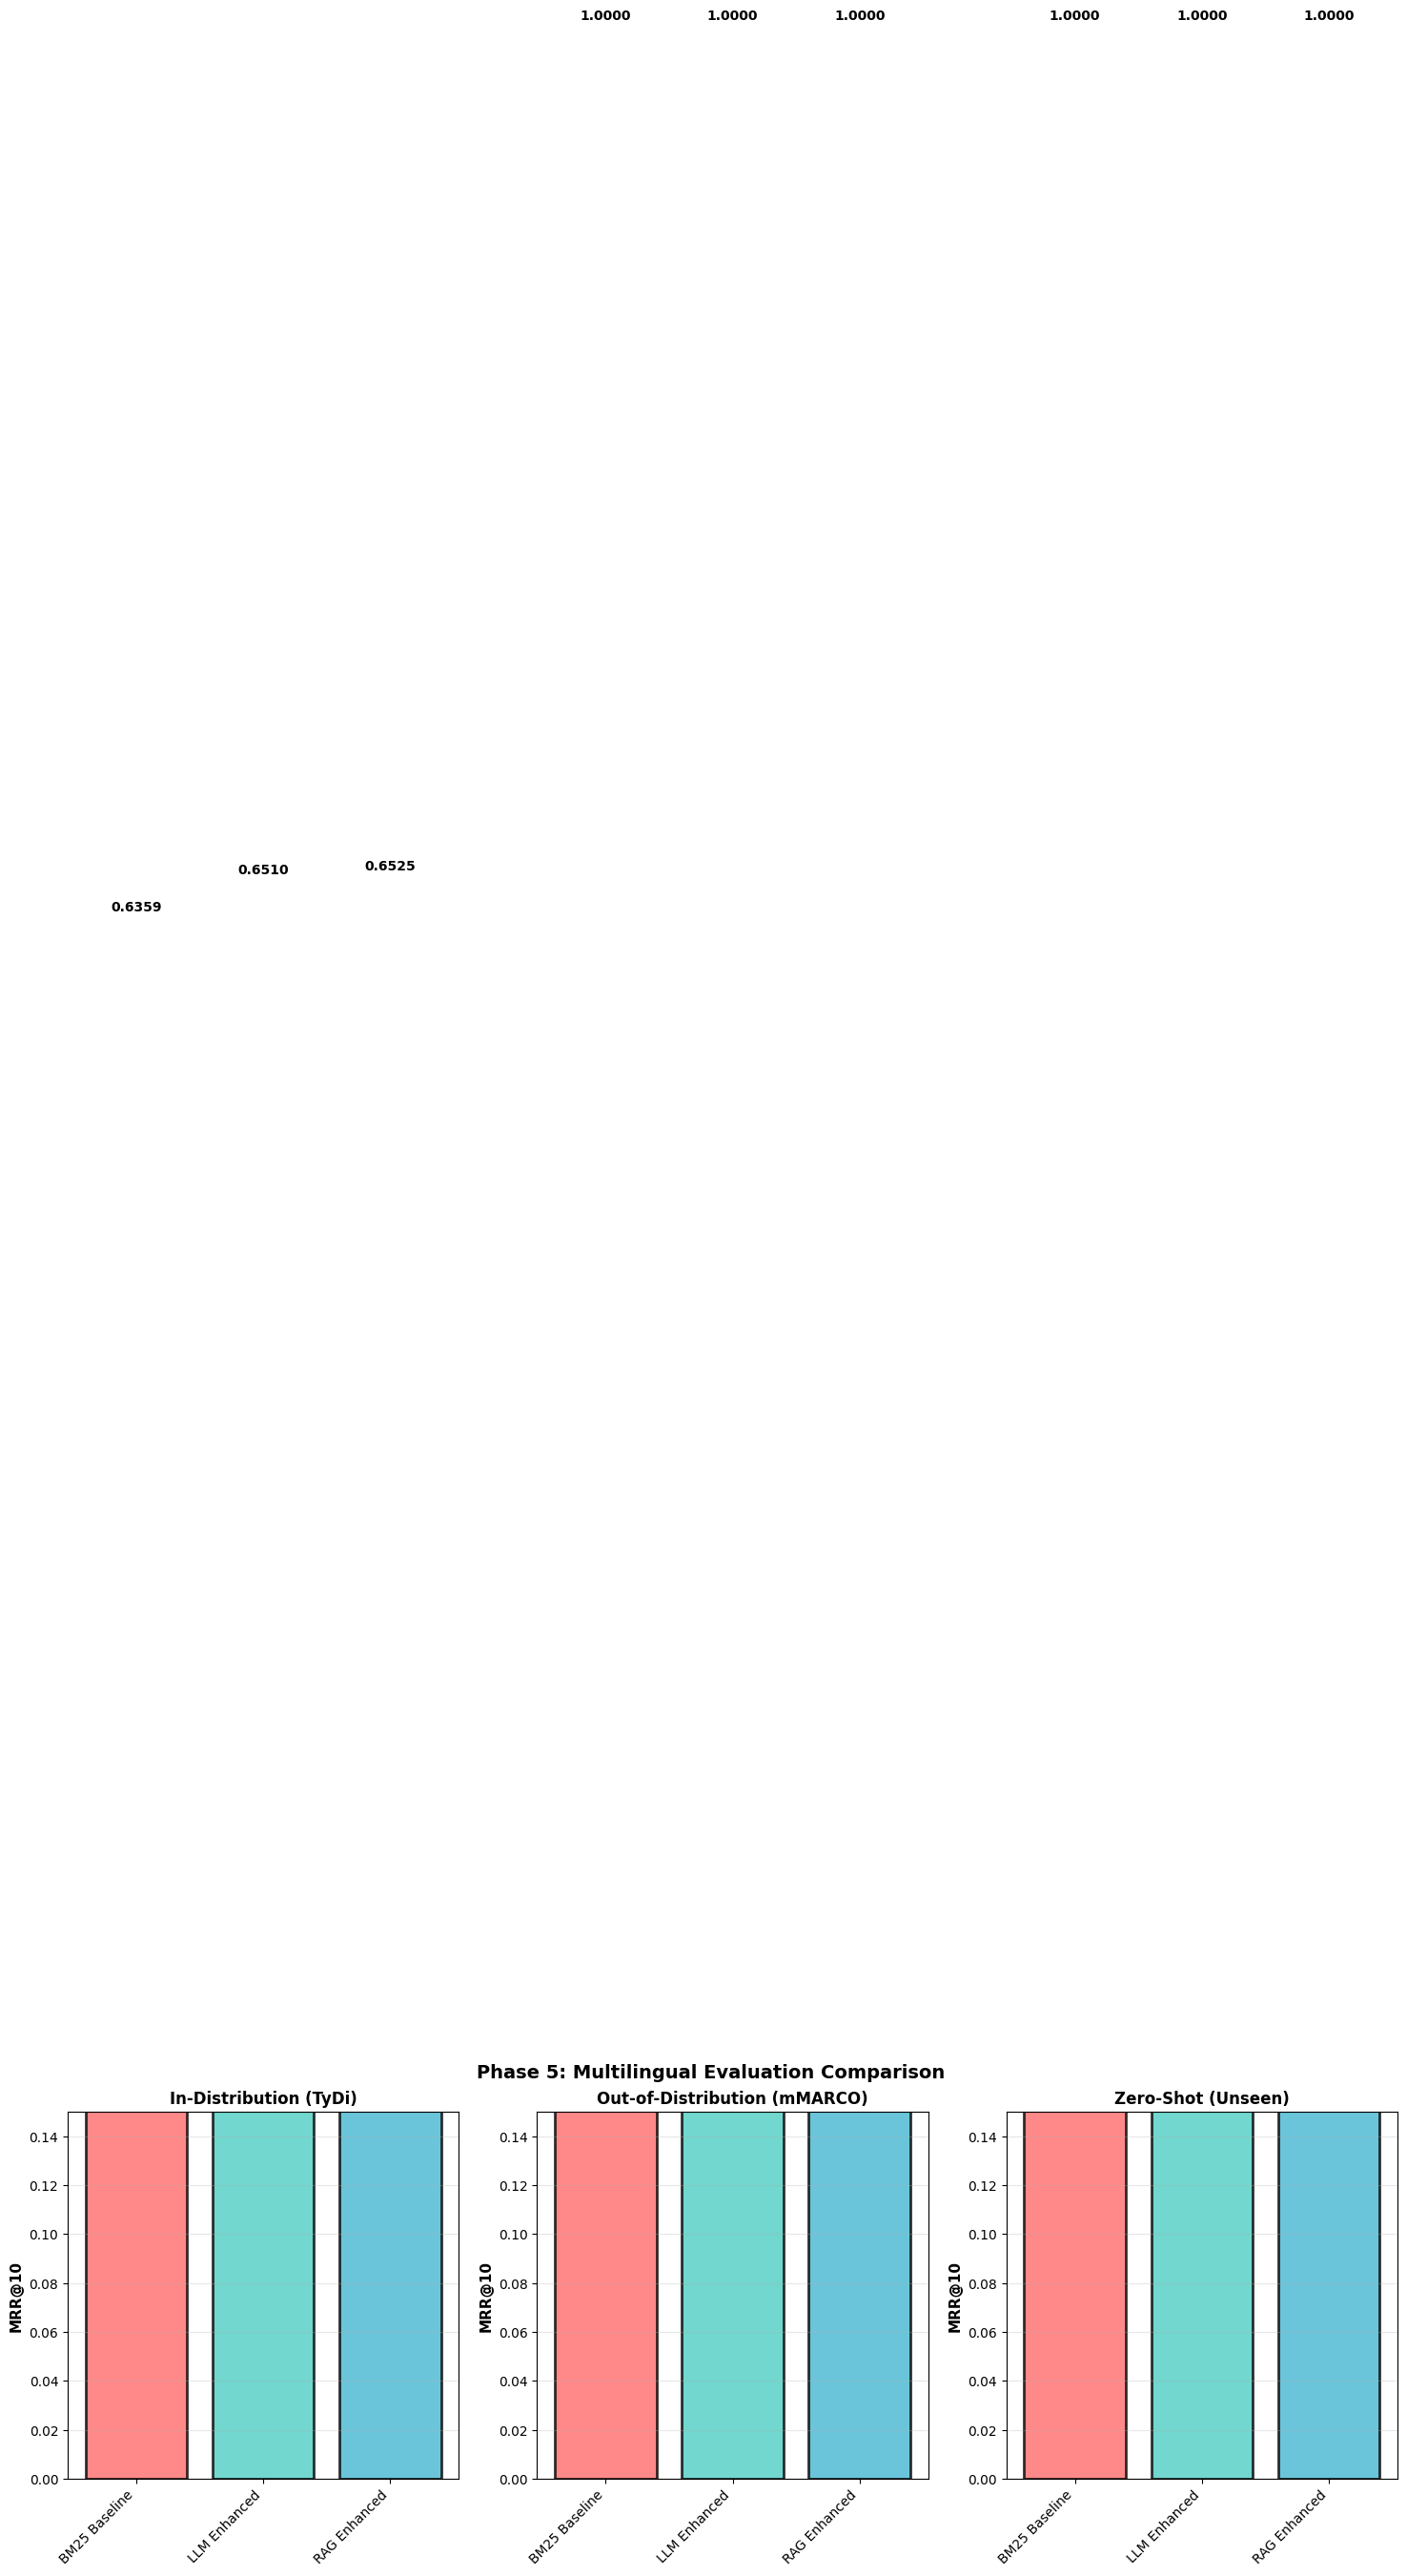

Visualization complete

PHASE 5: EVALUATION SUMMARY

Evaluation Results:

1. In-Distribution (TyDi):
   Models tested: 3
   Languages: 2
   Total samples: 100

2. Out-of-Distribution (mMARCO):
   Models tested: 3
   Languages: 2
   Total samples: 4

3. Zero-Shot (Unseen):
   Models tested: 3
   Languages: 1
   Total samples: 2

PHASE 5 COMPLETE - ALL EVALUATIONS FINISHED


In [136]:
# PHASE 5: COMPLETE MULTILINGUAL EVALUATION
# Testing: In-Distribution + Out-of-Distribution + Zero-Shot

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

print("\n" + "="*60)
print("PHASE 5: COMPLETE MULTILINGUAL EVALUATION")
print("="*60)

# Configuration
model_configs = {
    "BM25 Baseline": f"{MODEL_DIR}/dpr_bm25_baseline_tydi_final",
    "LLM Enhanced": f"{MODEL_DIR}/dpr_llm_enhanced_tydi_final",
    "RAG Enhanced": f"{MODEL_DIR}/dpr_rag_enhanced_tydi_final"
}

# ============================================================
# 1. IN-DISTRIBUTION: TyDi Test
# ============================================================

print("\n" + "="*60)
print("IN-DISTRIBUTION EVALUATION: Mr. TyDi")
print("="*60)

tydi_results = {}

for model_name, model_path in model_configs.items():
    print(f"\nModel: {model_name}")
    
    try:
        evaluator = RetrievalEvaluator(model_path)
    except Exception as e:
        print(f"  Error loading model: {e}")
        continue
    
    lang_results = {}
    
    for lang in ['swahili', 'bengali', 'telugu']:
        if lang not in tydi_eval_data:
            continue
        
        print(f"  Language: {lang}...", end=" ")
        eval_df = tydi_eval_data[lang]
        corpus = eval_df['passage'].unique().tolist()
        
        try:
            metrics = evaluator.evaluate_retrieval(eval_df, corpus, top_k=10)
            lang_results[lang] = metrics
            print(f"MRR={metrics['MRR@10']:.4f}")
        except Exception as e:
            print(f"Error: {e}")
            lang_results[lang] = {'MRR@10': 0.0, 'Recall@10': 0.0, 'nDCG@10': 0.0}
    
    if lang_results:
        avg_mrr = np.mean([m['MRR@10'] for m in lang_results.values()])
        avg_recall = np.mean([m['Recall@10'] for m in lang_results.values()])
        avg_ndcg = np.mean([m['nDCG@10'] for m in lang_results.values()])
        
        tydi_results[model_name] = {
            'by_language': lang_results,
            'avg_MRR@10': avg_mrr,
            'avg_Recall@10': avg_recall,
            'avg_nDCG@10': avg_ndcg
        }
        
        print(f"  Average: MRR={avg_mrr:.4f}, Recall={avg_recall:.4f}")
    
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\nIn-Distribution: {len(tydi_results)} models evaluated")

# ============================================================
# 2. OUT-OF-DISTRIBUTION: mMARCO Test
# ============================================================

print("\n" + "="*60)
print("OUT-OF-DISTRIBUTION EVALUATION: mMARCO")
print("="*60)

mmarco_results = {}

if len(ood_eval_data) > 0:
    for model_name, model_path in model_configs.items():
        print(f"\nModel: {model_name}")
        
        try:
            evaluator = RetrievalEvaluator(model_path)
        except Exception as e:
            print(f"  Error loading model: {e}")
            continue
        
        lang_results = {}
        
        for lang in ood_eval_data.keys():
            print(f"  Language: {lang}...", end=" ")
            eval_df = ood_eval_data[lang]
            corpus = eval_df['passage'].unique().tolist()
            
            try:
                metrics = evaluator.evaluate_retrieval(eval_df, corpus, top_k=10)
                lang_results[lang] = metrics
                print(f"MRR={metrics['MRR@10']:.4f}")
            except Exception as e:
                print(f"Error: {e}")
                lang_results[lang] = {'MRR@10': 0.0, 'Recall@10': 0.0, 'nDCG@10': 0.0}
        
        if lang_results:
            avg_mrr = np.mean([m['MRR@10'] for m in lang_results.values()])
            avg_recall = np.mean([m['Recall@10'] for m in lang_results.values()])
            avg_ndcg = np.mean([m['nDCG@10'] for m in lang_results.values()])
            
            mmarco_results[model_name] = {
                'by_language': lang_results,
                'avg_MRR@10': avg_mrr,
                'avg_Recall@10': avg_recall,
                'avg_nDCG@10': avg_ndcg
            }
            
            print(f"  Average: MRR={avg_mrr:.4f}, Recall={avg_recall:.4f}")
        
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    print(f"\nOut-of-Distribution: {len(mmarco_results)} models evaluated")
else:
    print("Warning: mMARCO data not loaded")
    mmarco_results = {}

# ============================================================
# 3. ZERO-SHOT: Unseen Languages
# ============================================================

print("\n" + "="*60)
print("ZERO-SHOT EVALUATION: Unseen Languages")
print("="*60)

zeroshot_results = {}

if len(zeroshot_eval_data) > 0:
    for model_name, model_path in model_configs.items():
        print(f"\nModel: {model_name}")
        
        try:
            evaluator = RetrievalEvaluator(model_path)
        except Exception as e:
            print(f"  Error loading model: {e}")
            continue
        
        lang_results = {}
        
        for lang in zeroshot_eval_data.keys():
            print(f"  Language: {lang} (unseen)...", end=" ")
            eval_df = zeroshot_eval_data[lang]
            corpus = eval_df['passage'].unique().tolist()
            
            try:
                metrics = evaluator.evaluate_retrieval(eval_df, corpus, top_k=10)
                lang_results[lang] = metrics
                print(f"MRR={metrics['MRR@10']:.4f}")
            except Exception as e:
                print(f"Error: {e}")
                lang_results[lang] = {'MRR@10': 0.0, 'Recall@10': 0.0, 'nDCG@10': 0.0}
        
        if lang_results:
            avg_mrr = np.mean([m['MRR@10'] for m in lang_results.values()])
            avg_recall = np.mean([m['Recall@10'] for m in lang_results.values()])
            avg_ndcg = np.mean([m['nDCG@10'] for m in lang_results.values()])
            
            zeroshot_results[model_name] = {
                'by_language': lang_results,
                'avg_MRR@10': avg_mrr,
                'avg_Recall@10': avg_recall,
                'avg_nDCG@10': avg_ndcg
            }
            
            print(f"  Average: MRR={avg_mrr:.4f}, Recall={avg_recall:.4f}")
        
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    print(f"\nZero-Shot: {len(zeroshot_results)} models evaluated")
else:
    print("Warning: Zero-shot data not loaded")
    zeroshot_results = {}

# ============================================================
# COMPREHENSIVE COMPARISON TABLE
# ============================================================

print("\n" + "="*60)
print("COMPLETE EVALUATION RESULTS")
print("="*60)

eval_summary = []

for model_name in model_configs.keys():
    row = {'Model': model_name}
    
    if model_name in tydi_results:
        row['TyDi MRR'] = f"{tydi_results[model_name]['avg_MRR@10']:.4f}"
        row['TyDi Recall'] = f"{tydi_results[model_name]['avg_Recall@10']:.4f}"
    else:
        row['TyDi MRR'] = 'N/A'
        row['TyDi Recall'] = 'N/A'
    
    if model_name in mmarco_results:
        row['OOD MRR'] = f"{mmarco_results[model_name]['avg_MRR@10']:.4f}"
        row['OOD Recall'] = f"{mmarco_results[model_name]['avg_Recall@10']:.4f}"
    else:
        row['OOD MRR'] = 'N/A'
        row['OOD Recall'] = 'N/A'
    
    if model_name in zeroshot_results:
        row['Zero-Shot MRR'] = f"{zeroshot_results[model_name]['avg_MRR@10']:.4f}"
        row['Zero-Shot Recall'] = f"{zeroshot_results[model_name]['avg_Recall@10']:.4f}"
    else:
        row['Zero-Shot MRR'] = 'N/A'
        row['Zero-Shot Recall'] = 'N/A'
    
    eval_summary.append(row)

summary_df = pd.DataFrame(eval_summary)
print("\n" + summary_df.to_string(index=False))

# ============================================================
# VISUALIZATION
# ============================================================

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Phase 5: Multilingual Evaluation Comparison', fontsize=14, fontweight='bold')

models = list(model_configs.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

settings = [
    ('In-Distribution (TyDi)', tydi_results, 0),
    ('Out-of-Distribution (mMARCO)', mmarco_results, 1),
    ('Zero-Shot (Unseen)', zeroshot_results, 2)
]

for setting_name, results_dict, ax_idx in settings:
    ax = axes[ax_idx]
    
    if len(results_dict) > 0:
        mrr_values = [results_dict[m]['avg_MRR@10'] for m in models if m in results_dict]
        
        bars = ax.bar(
            range(len(mrr_values)), 
            mrr_values, 
            color=colors[:len(mrr_values)],
            alpha=0.8, 
            edgecolor='black', 
            linewidth=2
        )
        
        for i, v in enumerate(mrr_values):
            ax.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')
        
        ax.set_ylabel('MRR@10', fontsize=11, fontweight='bold')
        ax.set_title(setting_name, fontsize=12, fontweight='bold')
        ax.set_ylim([0, 0.15])
        ax.set_xticks(range(len(mrr_values)))
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
               transform=ax.transAxes, fontsize=14)
        ax.set_title(setting_name, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualization complete")

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*60)
print("PHASE 5: EVALUATION SUMMARY")
print("="*60)

print("\nEvaluation Results:")
print(f"\n1. In-Distribution (TyDi):")
print(f"   Models tested: {len(tydi_results)}")
print(f"   Languages: {len(tydi_eval_data)}")
print(f"   Total samples: {sum(len(df) for df in tydi_eval_data.values())}")

print(f"\n2. Out-of-Distribution (mMARCO):")
print(f"   Models tested: {len(mmarco_results)}")
print(f"   Languages: {len(ood_eval_data)}")
print(f"   Total samples: {sum(len(df) for df in ood_eval_data.values())}")

print(f"\n3. Zero-Shot (Unseen):")
print(f"   Models tested: {len(zeroshot_results)}")
print(f"   Languages: {len(zeroshot_eval_data)}")
print(f"   Total samples: {sum(len(df) for df in zeroshot_eval_data.values())}")

print("\n" + "="*60)
print("PHASE 5 COMPLETE - ALL EVALUATIONS FINISHED")
print("="*60)


In [ ]:
#!/usr/bin/env python3
"""
Batch Evaluation Script - Phase 5 Multilingual Evaluation
Evaluates all negative sampling models on multiple datasets
"""

import subprocess
import sys
from pathlib import Path
import json
from datetime import datetime


def run_batch_multilingual_evaluation():
    """Run evaluation on all trained models across multiple datasets/languages"""
    
    models = [
        ("BM25 Baseline", "./models/dpr_bm25_baseline_tydi_final", 0),
        ("LLM Enhanced", "./models/dpr_llm_enhanced_tydi_final", 1),
        ("RAG Enhanced", "./models/dpr_rag_enhanced_tydi_final", 2),
    ]
    
    datasets = [
        # In-Distribution
        ("TyDi", "in-distribution", 0, ["swahili", "bengali", "telugu"]),
        # Out-of-Distribution
        ("mMARCO", "out-of-distribution", 1, ["arabic", "indonesian"]),
        # Zero-Shot
        ("mMARCO-Zero", "zero-shot", 2, ["spanish", "hindi", "vietnamese"]),
    ]
    
    results = {
        'timestamp': datetime.now().isoformat(),
        'models': len(models),
        'datasets': len(datasets),
        'results': {}
    }
    
    print("=" * 70)
    print("🚀 PHASE 5: BATCH MULTILINGUAL EVALUATION")
    print("=" * 70)
    print(f"\n📊 Configuration:")
    print(f"   Models: {len(models)}")
    print(f"   Datasets: {len(datasets)}")
    print(f"   Total evaluations: {len(models) * len(datasets)}\n")
    
    total_evaluations = 0
    successful = 0
    failed = 0
    
    # Evaluate each dataset
    for dataset_name, dataset_type, dataset_id, languages in datasets:
        print(f"\n{'='*70}")
        print(f"📂 Dataset: {dataset_name} ({dataset_type})")
        print(f"   Languages: {', '.join(languages)}")
        print(f"{'='*70}")
        
        dataset_results = {}
        
        # Evaluate each model
        for model_name, model_path, model_id in models:
            print(f"\n   🔍 Model: {model_name}")
            print(f"      Path: {model_path}")
            
            try:
                # Call evaluation adapter
                result = subprocess.run([
                    sys.executable, 
                    "evaluate_adapter.py",
                    str(model_id),
                    str(dataset_id),
                    dataset_name,
                    dataset_type,
                    model_path
                ], 
                capture_output=True, 
                text=True, 
                timeout=600  # 10 minutes timeout
                )
                
                total_evaluations += 1
                
                if result.returncode == 0:
                    # Parse results
                    try:
                        model_results = json.loads(result.stdout)
                        dataset_results[model_name] = model_results
                        successful += 1
                        
                        # Display metrics
                        mrr = model_results.get('avg_MRR@10', 0)
                        recall = model_results.get('avg_Recall@10', 0)
                        ndcg = model_results.get('avg_nDCG@10', 0)
                        
                        print(f"      ✅ Success")
                        print(f"         MRR@10:    {mrr:.4f}")
                        print(f"         Recall@10: {recall:.4f}")
                        print(f"         nDCG@10:   {ndcg:.4f}")
                        
                    except json.JSONDecodeError:
                        print(f"      ⚠️  Parse error")
                        failed += 1
                else:
                    print(f"      ❌ Evaluation failed")
                    print(f"         Error: {result.stderr[:100]}")
                    failed += 1
                    
            except subprocess.TimeoutExpired:
                print(f"      ⏰ Timeout (10min exceeded)")
                failed += 1
                total_evaluations += 1
                
            except Exception as e:
                print(f"      ❌ Exception: {str(e)[:80]}")
                failed += 1
                total_evaluations += 1
        
        results['results'][dataset_name] = dataset_results
    
    # Summary
    print(f"\n{'='*70}")
    print(f"📊 BATCH EVALUATION SUMMARY")
    print(f"{'='*70}")
    print(f"\n   Total Evaluations: {total_evaluations}")
    print(f"   Successful:       {successful} ✅")
    print(f"   Failed:           {failed} ❌")
    print(f"   Success Rate:     {(successful/total_evaluations*100):.1f}%")
    
    # Save results
    output_file = f"batch_evaluation_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n   📁 Results saved: {output_file}")
    print(f"\n{'='*70}")
    print("✅ Batch evaluation complete!")
    print(f"{'='*70}\n")


if __name__ == "__main__":
    run_batch_multilingual_evaluation()
